In [1]:
mname = 'hill_g100'
fold = 1

In [2]:
# hillclimbing on oofs from pytorch models with folds

glist = ['air_g68','air_h68',
         'airx_h67',
         'cbam_h67',
         'iv3_g11','iv3_h11',
         'preresnet_g67','preresnet_h67',
         'se_resnext_g30','se_resnext_h30']

mnames = glist 

# special = 'airnext50_gwap_ch_030'
special = 'air_h68'

clist = []
dlist = []
flist = []
olist = []
slist = []

gpct = 90.
gscale = 1.
# gscale = 10.
nfold = 2

In [3]:
import numpy as np
import pandas as pd
import pickle
import os
from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, Concatenate, concatenate
from keras.layers import Dense, GlobalAveragePooling2D, Reshape, Lambda, Activation
from keras.layers import UpSampling2D, Dropout, BatchNormalization, MaxPooling2D
from keras.losses import binary_crossentropy
from keras import backend as K
from keras.applications import MobileNet

import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral
from skimage.color import gray2rgb
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.morphology import opening, closing

from scipy.special import logit, expit
import scipy.optimize as opt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

from sklearn.isotonic import IsotonicRegression

import gc
import cv2
from tqdm import tqdm_notebook

from sklearn.metrics import jaccard_similarity_score, f1_score, precision_score, recall_score

# from metrics import iou_metric, iou_metric_batch
# from metric import mean_iou

/home/sasrdw/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
PATH_TO_TRAIN = './train/'
PATH_TO_TEST = './test/'
PATH_TO_TARGET = './train.csv'
PATH_TO_SUB = './sample_submission.csv'

LABEL_MAP = {
0: "Nucleoplasm" ,
1: "Nuclear membrane"   ,
2: "Nucleoli"   ,
3: "Nucleoli fibrillar center",   
4: "Nuclear speckles"   ,
5: "Nuclear bodies"   ,
6: "Endoplasmic reticulum"   ,
7: "Golgi apparatus"  ,
8: "Peroxisomes"   ,
9:  "Endosomes"   ,
10: "Lysosomes"   ,
11: "Intermediate filaments"  , 
12: "Actin filaments"   ,
13: "Focal adhesion sites"  ,
14: "Microtubules"   ,
15: "Microtubule ends"   ,
16: "Cytokinetic bridge"   ,
17: "Mitotic spindle"  ,
18: "Microtubule organizing center",  
19: "Centrosome",
20: "Lipid droplets"   ,
21: "Plasma membrane"  ,
22: "Cell junctions"   ,
23: "Mitochondria"   ,
24: "Aggresome"   ,
25: "Cytosol" ,
26: "Cytoplasmic bodies",
27: "Rods & rings"}

In [5]:
df = pd.read_csv(PATH_TO_TARGET)
df.set_index('Id',inplace=True)
print(df.head())
print(df.shape)

                                       Target
Id                                           
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0     16 0
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  7 1 2 0
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0        5
000c99ba-bba4-11e8-b2b9-ac1f6b6435d0        1
001838f8-bbca-11e8-b2bc-ac1f6b6435d0       18
(31072, 1)


In [6]:
file_list = list(df.index.values)

ss = pd.read_csv(PATH_TO_SUB)
ss.set_index('Id',inplace=True)
print(ss.head())
print(ss.shape)

                                      Predicted
Id                                             
00008af0-bad0-11e8-b2b8-ac1f6b6435d0          0
0000a892-bacf-11e8-b2b8-ac1f6b6435d0          0
0006faa6-bac7-11e8-b2b7-ac1f6b6435d0          0
0008baca-bad7-11e8-b2b9-ac1f6b6435d0          0
000cce7e-bad4-11e8-b2b8-ac1f6b6435d0          0
(11702, 1)


In [7]:
# train_df["images"] = [np.array(load_img("images/{}.png".format(idx), color_mode = "grayscale")) / 255 \
#                       for idx in tqdm_notebook(train_df.index)]

# train_df["masks"] = [np.array(load_img("masks/{}.png".format(idx), color_mode = "grayscale")) / 255 \
#                      for idx in tqdm_notebook(train_df.index)]

In [8]:
df.columns

Index(['Target'], dtype='object')

In [9]:
# estimate thresholds by line search
def F1_hard(preds, targs, th=0.5):
    return -f1_score(targs,  (preds>th).astype(int))

def fit_val1(x, y, start=0.5):
    params = np.array([start])
    wd = 1e-5
#     error = lambda p: np.array(F1_hard(x,y,p), wd*(p - 0.5))
    error = lambda p: np.array(F1_hard(x,y,p))
#     p = opt.minimize_scalar(error, bounds=[0.3,0.7], method='bounded').x
#     p = opt.minimize_scalar(error, bounds=[0.1,0.9], method='bounded').x
    p = opt.minimize_scalar(error, bounds=[0.01,0.99], method='bounded').x
#     p = opt.minimize_scalar(error, bracket=[0.1,0.99], method='brent').x
#     p = opt.minimize_scalar(error, bracket=[0.1,0.99], method='golden').x
    return p

In [10]:
oof = df.copy()
# print(oof.head())
# print(oof.shape)
eps = 1e-6
num_classes = 28
np.set_printoptions(precision=3,linewidth=80,suppress=True)

c = 0
d = 0

for k,m in enumerate(mnames):
    print(' ')
    print(m)
    first = True
    for f in range(nfold):
        if m in clist:
            fname = str('oof/'+clist0[c]+'_ext_russ4/oof_pred.csv')
            # print(fname)
            o = pd.read_csv(fname)
            o = o[o.fold == f]
            idf = list(o['Id'])
            pooff = o.iloc[:,3:].values
#             print(pooff.shape)
        elif m in dlist:
            if dlist0[d] in dlist0s: s = '_' + dfold
            else: s = '_extra_' + dfold
            o = pd.read_csv('./oof/Dmytro/'+dlist0[d]+s+'__fold_'+
                            str(f)+'_'+dlist1[d]+'_oof.csv')
            # print(o.head(),o.shape)
            idf = list(o['Id'])
            pooff = np.array(o.iloc[:,:num_classes])
        elif m in slist:
            fname = 'oof/'+m+'_'+str(f)+'.pkl'
#             print(fname)
            a = pickle.load(open(fname,'rb'))
            idf = list(a[:,0])
#             pooff = [np.array(a[i,1:]).astype(float).flatten() for i in range(a.shape[0])]
            pooff = a[:,1:].astype(float)
#             print(pooff.shape)
        else:        
            idf, pooff, yooff = pickle.load(open('oof/'+m+'_'+str(f)+'.pkl','rb'))
        
        # change to probability scale
        # reduce map to single number
        if m in dlist: 
            pooff = expit(pooff)
        elif m in clist+slist:
            pass
        else: 
            pooff = np.percentile(pooff, gpct, axis=(2,3))
            pooff = 1./(1. + np.exp(-pooff/gscale))
#             for i in range(num_classes):
#                 ir = IsotonicRegression()
#                 pooff[:,i] = ir.fit_transform(pooff[:,i],yooff[:,i])
         
#         print(pooff.shape)
        if first:
            id = idf
            folds = np.zeros(len(idf)).astype(int) + f
            poof = pooff.copy()
            yoof = yooff.copy()
            first = False
        else:
            id = id + idf
            folds = np.concatenate((folds, np.zeros(len(idf)).astype(int) + f))
            poof = np.concatenate((poof,pooff))
            yoof = np.concatenate((yoof,yooff))
    
#     # determine class-specific thresholds and convert predictions to binary
#     th = np.zeros(num_classes)
#     for i in range(num_classes):
#         th[i] = fit_val1(poof[:,i],yoof[:,i])
#     print('Thresholds: ',th)
#     poof = poof > th
#     print('F1 macro: ',f1_score(yoof, poof, average='macro'))

    mdf = pd.DataFrame({'Id':id})
    print(poof.shape, poof.min(), poof.mean(), poof.max())
    if k==0: 
        mdf['fold'] = folds
        mdf['y'] = [yoof[i] for i in range(yoof.shape[0])]
    mdf[m] = [poof[i] for i in range(poof.shape[0])]
    mdf.set_index('Id',inplace=True)
    oof = oof.join(mdf)
#     print(oof.shape)
      
    if m in clist: c += 1
    elif m in dlist: d += 1

 
air_g68
(31072, 28) 5.199339475012162e-10 0.10856166392899642 0.9999999200061678
 
air_h68
(31072, 28) 9.017364594412242e-11 0.13291015708227766 0.9999999943362174
 
airx_h67
(31072, 28) 8.785416845878402e-07 0.15794095011510392 0.9999476969311245
 
cbam_h67
(31072, 28) 1.490742170761279e-06 0.14490588687198672 0.9999638433132007
 
iv3_g11
(31072, 28) 1.890722579368819e-15 0.18436057236015854 0.9999999870846621
 
iv3_h11
(31072, 28) 2.41603052774414e-13 0.18299899477567702 0.9999997216177055
 
preresnet_g67
(31072, 28) 5.15687356979823e-09 0.11409260331704822 0.9999988713299672
 
preresnet_h67
(31072, 28) 1.3114515330332025e-09 0.13314753023669737 0.9999965263197891
 
se_resnext_g30
(31072, 28) 4.998406239369011e-08 0.10705229990052367 0.9999747502237741
 
se_resnext_h30
(31072, 28) 1.1202183529134713e-07 0.12729151282084192 0.9999303639699844


In [11]:
# # replace 3 missing values due to dropping bad images in slist models
# nav = oof['shai_res18'].isna()
# # nav = oof.isna()
# print(nav.sum())

In [12]:
# num_classes = 28
# for i in range(oof.shape[0]):
#     if nav[i]:
#         for s in slist:
#             oof[s][i] = np.zeros(num_classes) 

In [13]:
# print(oof.head())
print(oof.shape)

(31072, 13)


In [14]:
oof.columns

Index(['Target', 'fold', 'y', 'air_g68', 'air_h68', 'airx_h67', 'cbam_h67',
       'iv3_g11', 'iv3_h11', 'preresnet_g67', 'preresnet_h67',
       'se_resnext_g30', 'se_resnext_h30'],
      dtype='object')

In [15]:
vp = oof.loc[oof['y'].notnull()]
print(vp.shape)

(31072, 13)


In [16]:
# # compute rank transform separately for every column
# from scipy.stats import rankdata
# n = vp.shape[0] * 28
# for m in mnames:
#     a = rankdata(np.array(list(vp[m])).flatten()).reshape((vp.shape[0],28))/n
#     vp[m] = [i for i in a]
# print(vp.shape)

In [17]:
vp.head()

Target  fold  \
Id                                                    
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0     16 0     0   
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  7 1 2 0     1   
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0        5     1   
000c99ba-bba4-11e8-b2b9-ac1f6b6435d0        1     1   
001838f8-bbca-11e8-b2bc-ac1f6b6435d0       18     0   

                                                                                      y  \
Id                                                                                        
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...   
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...   
000c99ba-bba4-11e8-b2b9-ac1f6b6435d0  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
001838f8-bbca-11e8-b2bc-ac1f6b6435d0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                                                air_g68  \
Id                                                                                        
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0  [0.9938142046510011, 0.0037916844887311307, 0....   
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  [0.9271292091812569, 0.9984812691958725, 0.097...   
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0  [0.8719980781234266, 0.008140209451856626, 0.3...   
000c99ba-bba4-11e8-b2b9-ac1f6b6435d0  [0.9585714848369201, 0.9944451332457828, 0.051...   
001838f8-bbca-11e8-b2bc-ac1f6b6435d0  [0.7084975848106435, 5.112335699132039e-05, 0....   

                                                                                air_h68  \
Id                                                                                        
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0  [0.9835724695027714, 0.008632446082215098, 0.0...   
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  [0.9436852760526215, 0.9998462239647582, 0.168...   
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0  [0.9614538788526873, 0.02156667464916855, 0.31...   
000c99ba-bba4-11e8-b2b9-ac1f6b6435d0  [0.8337132020420748, 0.9995023747283224, 0.010...   
001838f8-bbca-11e8-b2bc-ac1f6b6435d0  [0.9609791184646658, 0.0005009156579273469, 0....   

                                                                               airx_h67  \
Id                                                                                        
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0  [0.9934669401661846, 0.006963515153203707, 0.0...   
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  [0.9901062579191326, 0.9989106680249538, 0.178...   
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0  [0.977937452507024, 0.030957779346692832, 0.30...   
000c99ba-bba4-11e8-b2b9-ac1f6b6435d0  [0.9106319916666994, 0.9987898744577565, 0.060...   
001838f8-bbca-11e8-b2bc-ac1f6b6435d0  [0.7681555904276774, 0.00281168217801685, 0.24...   

                                                                               cbam_h67  \
Id                                                                                        
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0  [0.9723048627239375, 0.006949169927073222, 0.0...   
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  [0.8885783897992546, 0.9956250263370134, 0.652...   
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0  [0.8977109247885934, 0.04155724538466728, 0.46...   
000c99ba-bba4-11e8-b2b9-ac1f6b6435d0  [0.798920745332107, 0.9866330973221051, 0.0571...   
001838f8-bbca-11e8-b2bc-ac1f6b6435d0  [0.5882571001000663, 0.0022788295230577013, 0....   

                                                                                iv3_g11  \
Id                                                                                        
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0  [0.9987159988761126, 0.00698739714781295, 0.07...   
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  [0.8641792694358255, 0.9992822883547582, 0.997...   
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0  [0.9743035937189628, 0.0764655144301097, 0.900...   
000c99ba

In [18]:
offset = 3
nm = vp.shape[1] - offset
folds = oof['fold'].values.astype(int)
print(offset, nm, folds.shape)

3 10 (31072,)


In [19]:
y = np.array([a for a in vp.y])
y.shape

(31072, 28)

In [20]:
ys = np.sum(y,axis=1)
print(ys.shape)
print(ys.min(),ys.mean(),ys.max())

(31072,)
1.0 1.6343331 5.0


In [21]:
c_val = np.sum(y,axis=0)
for k,v in LABEL_MAP.items():
    print(k,v, 'count', c_val[k],
             'prop', '%6.4f' % (c_val[k]/y.shape[0]))

0 Nucleoplasm count 12885.0 prop 0.4147
1 Nuclear membrane count 1254.0 prop 0.0404
2 Nucleoli count 3621.0 prop 0.1165
3 Nucleoli fibrillar center count 1561.0 prop 0.0502
4 Nuclear speckles count 1858.0 prop 0.0598
5 Nuclear bodies count 2513.0 prop 0.0809
6 Endoplasmic reticulum count 1008.0 prop 0.0324
7 Golgi apparatus count 2822.0 prop 0.0908
8 Peroxisomes count 53.0 prop 0.0017
9 Endosomes count 45.0 prop 0.0014
10 Lysosomes count 28.0 prop 0.0009
11 Intermediate filaments count 1093.0 prop 0.0352
12 Actin filaments count 688.0 prop 0.0221
13 Focal adhesion sites count 537.0 prop 0.0173
14 Microtubules count 1066.0 prop 0.0343
15 Microtubule ends count 21.0 prop 0.0007
16 Cytokinetic bridge count 530.0 prop 0.0171
17 Mitotic spindle count 210.0 prop 0.0068
18 Microtubule organizing center count 902.0 prop 0.0290
19 Centrosome count 1482.0 prop 0.0477
20 Lipid droplets count 172.0 prop 0.0055
21 Plasma membrane count 3777.0 prop 0.1216
22 Cell junctions count 802.0 prop 0.0258
23

In [22]:
# idx = range(28)
# loc = [LABEL_MAP[j] for j in idx]
# lb = [c_val[j]/y.shape[0] for j in idx]

# df = pd.DataFrame({'idx':idx, 'loc':loc, 'training':lb})
# fname = 'train_props.csv'
# df.to_csv(fname,index=False)
# print(fname)

In [23]:
# train_sum_vec = np.sum(np.stack(subm['target_vec'].values, 0), 0)
# _ = plt.bar(n_keys, [train_sum_vec[k] for k in n_keys])

In [24]:
ymean = np.mean(y,axis=0)
print(ymean)

[0.415 0.04  0.117 0.05  0.06  0.081 0.032 0.091 0.002 0.001 0.001 0.035 0.022
 0.017 0.034 0.001 0.017 0.007 0.029 0.048 0.006 0.122 0.026 0.095 0.01  0.265
 0.011 0.   ]


In [25]:
ysum = np.sum(y,axis=0)
print(ysum)

[12885.  1254.  3621.  1561.  1858.  2513.  1008.  2822.    53.    45.    28.
  1093.   688.   537.  1066.    21.   530.   210.   902.  1482.   172.  3777.
   802.  2965.   322.  8228.   328.    11.]


(-0.03034705803458428, 0.4436122904074585)

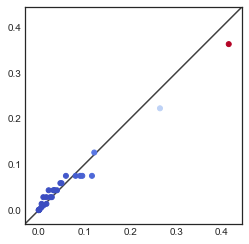

In [26]:
# plot training class frequencies versus those from leaderboard probing by iafoss
lb_prob = np.array([
0.36239782, 0.043841336, 0.075268817, 0.059322034, 0.075268817,
0.075268817, 0.043841336, 0.075268817, 0.0018, 0.0014,
0.0009, 0.043841336, 0.043841336, 0.014198783, 0.043841336,
0.0007, 0.028806584, 0.014198783, 0.028806584, 0.059322034,
0.0056, 0.126126126, 0.028806584, 0.075268817, 0.0104,
0.222493888, 0.028806584, 0.0004
])
   
# sns.regplot(ymean, lb_prob)

c = ymean**2 + lb_prob**2

fig, ax = plt.subplots()
ax.scatter(ymean, lb_prob, s=25, c=c, cmap=plt.cm.coolwarm, zorder=10)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
# fig.savefig('/Users/paul/Desktop/so.png', dpi=300)

In [27]:
# lb probing resuluts from iafoss
# print lower and upper bound on frequencies
probe = {
0 : 0.019,
1 : 0.003,
2 : 0.005,
3 : 0.004,
4 : 0.005,
5 : 0.005,
6 : 0.003,
7 : 0.005,
8 : 0.000,
9 : 0.000,
10 : 0.000,
11 : 0.003,
12 : 0.003,
13 : 0.001,
14 : 0.003,
15 : 0.000,
16 : 0.002,
17 : 0.001,
18 : 0.002,
19 : 0.004,
20 : 0.000,
21 : 0.008,
22 : 0.002,
23 : 0.005,
24 : 0.000,
25 : 0.013,
26 : 0.002,
27 : 0.000
}

r = 0.000499
for k in range(28):

    # si = 0.019*28
    si = probe[k]*28
    fi = si/(2-si)
    si0 = max(0,(probe[k] - r)*28)
    fi0 = si0/(2-si0)
    si1 = (probe[k] + r)*28
    fi1 = si1/(2-si1)
    ci = np.round(fi*11702)
    print(k,'%6.4f %6.4f %6.4f %6.4f %d %d' % (fi0,fi,fi1,ymean[k],ci,ysum[k]),LABEL_MAP[k])

0 0.3496 0.3624 0.3755 0.4147 4241 12885 Nucleoplasm
1 0.0363 0.0438 0.0515 0.0404 513 1254 Nuclear membrane
2 0.0673 0.0753 0.0834 0.1165 881 3621 Nucleoli
3 0.0515 0.0593 0.0672 0.0502 694 1561 Nucleoli fibrillar center
4 0.0673 0.0753 0.0834 0.0598 881 1858 Nuclear speckles
5 0.0673 0.0753 0.0834 0.0809 881 2513 Nuclear bodies
6 0.0363 0.0438 0.0515 0.0324 513 1008 Endoplasmic reticulum
7 0.0673 0.0753 0.0834 0.0908 881 2822 Golgi apparatus
8 0.0000 0.0000 0.0070 0.0017 0 53 Peroxisomes
9 0.0000 0.0000 0.0070 0.0014 0 45 Endosomes
10 0.0000 0.0000 0.0070 0.0009 0 28 Lysosomes
11 0.0363 0.0438 0.0515 0.0352 513 1093 Intermediate filaments
12 0.0363 0.0438 0.0515 0.0221 513 688 Actin filaments
13 0.0071 0.0142 0.0214 0.0173 166 537 Focal adhesion sites
14 0.0363 0.0438 0.0515 0.0343 513 1066 Microtubules
15 0.0000 0.0000 0.0070 0.0007 0 21 Microtubule ends
16 0.0215 0.0288 0.0363 0.0171 337 530 Cytokinetic bridge
17 0.0071 0.0142 0.0214 0.0068 166 210 Mitotic spindle
18 0.0215 0.0288 

In [28]:
order = np.argsort(ymean)
order

array([27, 15, 10,  9,  8, 20, 17, 24, 26, 16, 13, 12, 22, 18,  6, 14, 11,  1,
       19,  3,  4,  5,  7, 23,  2, 21, 25,  0])

In [29]:
# sort by training frequency
for j in range(28):
    k = order[j]
    # si = 0.019*28
    si = probe[k]*28
    fi = si/(2-si)
    si0 = max(0,(probe[k] - r)*28)
    fi0 = si0/(2-si0)
    si1 = (probe[k] + r)*28
    fi1 = si1/(2-si1)
    ci = np.round(fi*11702)
    print(k,'%6.4f %6.4f %6.4f %6.4f %d %d' % (fi0,fi,fi1,ymean[k],ci,ysum[k]),LABEL_MAP[k])

27 0.0000 0.0000 0.0070 0.0004 0 11 Rods & rings
15 0.0000 0.0000 0.0070 0.0007 0 21 Microtubule ends
10 0.0000 0.0000 0.0070 0.0009 0 28 Lysosomes
9 0.0000 0.0000 0.0070 0.0014 0 45 Endosomes
8 0.0000 0.0000 0.0070 0.0017 0 53 Peroxisomes
20 0.0000 0.0000 0.0070 0.0055 0 172 Lipid droplets
17 0.0071 0.0142 0.0214 0.0068 166 210 Mitotic spindle
24 0.0000 0.0000 0.0070 0.0104 0 322 Aggresome
26 0.0215 0.0288 0.0363 0.0106 337 328 Cytoplasmic bodies
16 0.0215 0.0288 0.0363 0.0171 337 530 Cytokinetic bridge
13 0.0071 0.0142 0.0214 0.0173 166 537 Focal adhesion sites
12 0.0363 0.0438 0.0515 0.0221 513 688 Actin filaments
22 0.0215 0.0288 0.0363 0.0258 337 802 Cell junctions
18 0.0215 0.0288 0.0363 0.0290 337 902 Microtubule organizing center
6 0.0363 0.0438 0.0515 0.0324 513 1008 Endoplasmic reticulum
14 0.0363 0.0438 0.0515 0.0343 513 1066 Microtubules
11 0.0363 0.0438 0.0515 0.0352 513 1093 Intermediate filaments
1 0.0363 0.0438 0.0515 0.0404 513 1254 Nuclear membrane
19 0.0515 0.0593 0.

In [30]:
# save
ka = []
fi0a = []
fia = []
fi1a = []
yma = []
ca = []
for j in range(28):
    k = order[j]
    # si = 0.019*28
    si = probe[k]*28
    fi = si/(2-si)
    si0 = max(0,(probe[k] - r)*28)
    fi0 = si0/(2-si0)
    si1 = (probe[k] + r)*28
    fi1 = si1/(2-si1)
    ci = fi*11702.
    ka.append(k)
    fi0a.append(fi0)
    fia.append(fi)
    fi1a.append(fi1)
    yma.append(ymean[k])
    ca.append(LABEL_MAP[k])
    print(k,'%6.4f %6.4f %6.4f %6.4f %d %d' % (fi0,fi,fi1,ymean[k],ci,
                                               ysum[k]),LABEL_MAP[k])
              
tf = pd.DataFrame({'class':ka,'name':ca,'dataset':'test',
                   'fi0':fi0a,'freq':fia,'fi1':fi1a,'ym':yma})
fname = 'test_freq.csv'
tf.to_csv(fname,index=False)
print(fname)

27 0.0000 0.0000 0.0070 0.0004 0 11 Rods & rings
15 0.0000 0.0000 0.0070 0.0007 0 21 Microtubule ends
10 0.0000 0.0000 0.0070 0.0009 0 28 Lysosomes
9 0.0000 0.0000 0.0070 0.0014 0 45 Endosomes
8 0.0000 0.0000 0.0070 0.0017 0 53 Peroxisomes
20 0.0000 0.0000 0.0070 0.0055 0 172 Lipid droplets
17 0.0071 0.0142 0.0214 0.0068 166 210 Mitotic spindle
24 0.0000 0.0000 0.0070 0.0104 0 322 Aggresome
26 0.0215 0.0288 0.0363 0.0106 337 328 Cytoplasmic bodies
16 0.0215 0.0288 0.0363 0.0171 337 530 Cytokinetic bridge
13 0.0071 0.0142 0.0214 0.0173 166 537 Focal adhesion sites
12 0.0363 0.0438 0.0515 0.0221 513 688 Actin filaments
22 0.0215 0.0288 0.0363 0.0258 337 802 Cell junctions
18 0.0215 0.0288 0.0363 0.0290 337 902 Microtubule organizing center
6 0.0363 0.0438 0.0515 0.0324 513 1008 Endoplasmic reticulum
14 0.0363 0.0438 0.0515 0.0343 513 1066 Microtubules
11 0.0363 0.0438 0.0515 0.0352 513 1093 Intermediate filaments
1 0.0363 0.0438 0.0515 0.0404 513 1254 Nuclear membrane
19 0.0515 0.0593 0.

In [31]:
w = 1.0/np.mean(y,axis=0)
np.set_printoptions(precision=4,linewidth=80,suppress=True)
print(w)
print(w/sum(w))

[   2.4115   24.7783    8.5811   19.9052   16.7234   12.3645   30.8254
   11.0106  586.2642  690.4889 1109.7142   28.4282   45.1628   57.8622
   29.1482 1479.6191   58.6264  147.9619   34.4479   20.9663  180.6512
    8.2266   38.7431   10.4796   96.4969    3.7764   94.7317 2824.727 ]
[0.0003 0.0032 0.0011 0.0026 0.0022 0.0016 0.004  0.0014 0.0764 0.09   0.1446
 0.0037 0.0059 0.0075 0.0038 0.1928 0.0076 0.0193 0.0045 0.0027 0.0235 0.0011
 0.005  0.0014 0.0126 0.0005 0.0123 0.3681]


In [32]:
wc = np.clip(w,0.,1000.)
print(wc)
print(wc/sum(wc))

[   2.4115   24.7783    8.5811   19.9052   16.7234   12.3645   30.8254
   11.0106  586.2642  690.4889 1000.       28.4282   45.1628   57.8622
   29.1482 1000.       58.6264  147.9619   34.4479   20.9663  180.6512
    8.2266   38.7431   10.4796   96.4969    3.7764   94.7317 1000.    ]
[0.0005 0.0047 0.0016 0.0038 0.0032 0.0024 0.0059 0.0021 0.1115 0.1313 0.1901
 0.0054 0.0086 0.011  0.0055 0.1901 0.0111 0.0281 0.0066 0.004  0.0344 0.0016
 0.0074 0.002  0.0183 0.0007 0.018  0.1901]


In [33]:
# https://www.kaggle.com/c/human-protein-atlas-image-classification/discussion/74065 

import math

# mu in "create_class_weight" is a dampening parameter that could be tuned
def create_class_weight(labels_dict, mu=0.5):
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()
    class_weight_log = dict()

    for key in keys:
        score = total / float(labels_dict[key])
        score_log = math.log(mu * total / float(labels_dict[key]))
        class_weight[key] = round(score, 2) if score > 1.0 else round(1.0, 2)
        class_weight_log[key] = round(score_log, 2) if score_log > 1.0 else round(1.0, 2)

    return class_weight, class_weight_log

# Class abundance for protein dataset
labels_dict = {
    0: 12885,
    1: 1254,
    2: 3621,
    3: 1561,
    4: 1858,
    5: 2513,
    6: 1008,
    7: 2822,
    8: 53,
    9: 45,
    10: 28,
    11: 1093,
    12: 688,
    13: 537,
    14: 1066,
    15: 21,
    16: 530,
    17: 210,
    18: 902,
    19: 1482,
    20: 172,
    21: 3777,
    22: 802,
    23: 2965,
    24: 322,
    25: 8228,
    26: 328,
    27: 11
}

ccw = create_class_weight(labels_dict, mu=1.0)
# print('\nTrue class weights:')
# print(create_class_weight(labels_dict)[0])
# print('\nLog-dampened class weights:')
# print(create_class_weight(labels_dict)[1])
for i in range(num_classes):
    print(i,ccw[0][i],ccw[1][i])

0 3.94 1.37
1 40.5 3.7
2 14.02 2.64
3 32.53 3.48
4 27.33 3.31
5 20.21 3.01
6 50.38 3.92
7 18.0 2.89
8 958.15 6.87
9 1128.49 7.03
10 1813.64 7.5
11 46.46 3.84
12 73.81 4.3
13 94.57 4.55
14 47.64 3.86
15 2418.19 7.79
16 95.82 4.56
17 241.82 5.49
18 56.3 4.03
19 34.27 3.53
20 295.24 5.69
21 13.45 2.6
22 63.32 4.15
23 17.13 2.84
24 157.71 5.06
25 6.17 1.82
26 154.82 5.04
27 4616.55 8.44


In [34]:
# results for single model designated as special
x = np.array([x for x in vp[special]])
x = np.clip(x,-20,20)
print(x.shape, x.min(), x.mean(), x.max())

(31072, 28) 9.017364594412242e-11 0.13291015708227757 0.9999999943362174


/home/sasrdw/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


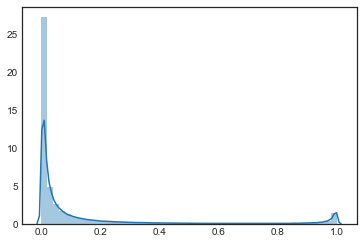

In [35]:
sns.distplot(x.flatten())

In [36]:
# t = -0.12
t = 0.5
xp = np.int32(x > t)
xps = np.sum(xp,axis=1)
print(xps.shape)
print(xps.min(),xps.mean(),xps.max())

(31072,)
0 2.898300720906282 8


In [37]:
print(np.mean(xp,axis=0))

[0.6493 0.0694 0.1469 0.0904 0.096  0.1532 0.0821 0.1211 0.0024 0.0025 0.0018
 0.0484 0.0474 0.0301 0.0466 0.0009 0.0886 0.028  0.0851 0.1628 0.0165 0.1925
 0.0569 0.1217 0.0277 0.4841 0.0451 0.001 ]


In [38]:
# proportion of zero predictions
print(sum(xps==0)/x.shape[0])

0.00035401647785787845


In [39]:
f1_score(y, xp, average='macro')

0.5595538090870308

In [40]:
# make sure every image has at least one prediction
x1 = x.copy()
for i in range(x.shape[0]):
    x1[i,np.argmax(x[i])] = 30

In [41]:
t = 0.53
x1p = np.int32(x1 > t)
x1ps = np.sum(x1p,axis=1)
print(x1ps.shape)
print(x1ps.min(),x1ps.mean(),x1ps.max())

# proportion of zero predictions
print(sum(x1ps==0)/x1.shape[0])

f1_score(y, x1p, average='macro')

(31072,)
1 2.787203913491246 8
0.0


0.570087685441356

In [42]:
# custom thresholds to match observed proportions
thresholds = np.linspace(1.0, 0.0, 1001)
pred = x.copy()
for j in range(pred.shape[1]):
    for t in thresholds:
        pred[:,j] = (x[:,j] > t).astype(int)
        prop = np.mean(pred[:,j])
        if prop >= ymean[j]: break
    print(j,'%6.4f' % t,'%6.4f' % ymean[j],'%6.4f' % prop, LABEL_MAP[j])
print(f1_score(y, pred, average='macro'))

0 0.9380 0.4147 0.4155 Nucleoplasm
1 0.9610 0.0404 0.0404 Nuclear membrane
2 0.7090 0.1165 0.1167 Nucleoli
3 0.8740 0.0502 0.0502 Nucleoli fibrillar center
4 0.9120 0.0598 0.0598 Nuclear speckles
5 0.7860 0.0809 0.0809 Nuclear bodies
6 0.9240 0.0324 0.0324 Endoplasmic reticulum
7 0.7250 0.0908 0.0909 Golgi apparatus
8 0.9190 0.0017 0.0017 Peroxisomes
9 0.8830 0.0014 0.0014 Endosomes
10 0.9060 0.0009 0.0009 Lysosomes
11 0.7270 0.0352 0.0353 Intermediate filaments
12 0.9290 0.0221 0.0222 Actin filaments
13 0.8070 0.0173 0.0173 Focal adhesion sites
14 0.9300 0.0343 0.0344 Microtubules
15 0.6910 0.0007 0.0007 Microtubule ends
16 0.9020 0.0171 0.0173 Cytokinetic bridge
17 0.9410 0.0068 0.0069 Mitotic spindle
18 0.8760 0.0290 0.0292 Microtubule organizing center
19 0.8410 0.0477 0.0479 Centrosome
20 0.9290 0.0055 0.0056 Lipid droplets
21 0.7790 0.1216 0.1219 Plasma membrane
22 0.8930 0.0258 0.0259 Cell junctions
23 0.7700 0.0954 0.0955 Mitochondria
24 0.9380 0.0104 0.0104 Aggresome
25 0.8860

In [43]:
# estimate thresholds by least squares, from iafoss kernel
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

def F1_soft(preds,targs,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    targs = targs.astype(np.float)
    score = 2.0*(preds*targs).sum(axis=0)/((preds+targs).sum(axis=0) + 1e-6)
    return score

def fit_val(x,y):
    params = 0.95*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((F1_soft(x,y,p) - 1.0,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params, maxfev=10000)
    return p

In [44]:
# #  pred = sigmoid_np(x)
# pred = x
# print(pred.min(),pred.mean(),pred.max())
# name_label_dict = LABEL_MAP
# th = fit_val(pred,y)
# # th[th<0.1] = 0.1
# print('Thresholds: ',th)
# print('F1 macro: ',f1_score(y, pred>th, average='macro'))
# # print('F1 macro (th = 0.5): ',f1_score(y, pred>0.5, average='macro'))
# print('F1 micro: ',f1_score(y, pred>th, average='micro'))

In [45]:
pred = x
num_classes = x.shape[1]
print(pred.min(),pred.mean(),pred.max(),num_classes)
name_label_dict = LABEL_MAP
th = np.zeros(num_classes)
for i in range(num_classes):
    th[i] = fit_val1(pred[:,i],y[:,i])
# th[th<0.1] = 0.1
print('Thresholds: ',th)
print('F1 macro: ',f1_score(y, pred>th, average='macro'))
print('F1 micro: ',f1_score(y, pred>th, average='micro'))

9.017364594412242e-11 0.13291015708227757 0.9999999943362174 28
Thresholds:  [0.8984 0.963  0.7587 0.9023 0.9011 0.847  0.913  0.7841 0.9334 0.8686 0.8917
 0.8552 0.932  0.8804 0.9016 0.9343 0.8569 0.9612 0.8316 0.847  0.946  0.7408
 0.8836 0.8022 0.9658 0.8215 0.9606 0.8812]
F1 macro:  0.6863033614512318
F1 micro:  0.7504861530208544


In [46]:
# estimate thresholds by line search on observed proportions
def prop_mse(preds, targs, th=0.5):
    pm = np.mean((preds>th))
    tm = np.mean(targs)
#     print(th,pm,tm)
    return (tm - pm)**2
#     return (np.mean(targs) - np.mean((preds>th)))**2

def fit_val2(x, y, start=0.54):
    params = np.array([start])
    wd = 1e-5
#     error = lambda p: np.array(F1_hard(x,y,p), wd*(p - 0.5))
    error = lambda p: np.array(prop_mse(x,y,p))
#     p = opt.minimize_scalar(error, bounds=[0.,1.0], method='bounded').x
    p = opt.minimize_scalar(error, bounds=[0.4,0.6], method='bounded').x
#     p = opt.minimize_scalar(error, bracket=[0.1,0.99], method='brent').x
#     p = opt.minimize_scalar(error, bracket=[0.1,0.99], method='golden').x
    return p

In [47]:
# prop_mse(pred[:,0],y[:,0], 0.618)

In [48]:
# fit_val2(pred[:,0],y[:,0])

In [49]:
pred = x
num_classes = x.shape[1]
print(pred.min(),pred.mean(),pred.max(),num_classes)
name_label_dict = LABEL_MAP
th = np.zeros(num_classes)
for i in range(num_classes):
    th[i] = fit_val2(pred[:,i],y[:,i])
# th[th<0.1] = 0.1
print('Thresholds: ',th)
print('F1 macro: ',f1_score(y, pred>th, average='macro'))
print('F1 micro: ',f1_score(y, pred>th, average='micro'))

9.017364594412242e-11 0.13291015708227757 0.9999999943362174 28
Thresholds:  [0.5998 0.5988 0.5983 0.5984 0.5984 0.5996 0.5996 0.5961 0.5528 0.5515 0.5688
 0.5981 0.599  0.5932 0.5973 0.5528 0.5997 0.5988 0.5998 0.5999 0.5942 0.5995
 0.5996 0.5994 0.5967 0.5999 0.5984 0.5901]
F1 macro:  0.5934412912025333
F1 micro:  0.6811934191196264


In [50]:
np.mean(pred[:,0] > 0.618)

0.60923017507724

In [51]:
# model- and class-specific thresholds 
# compute best threshold to maximize f1 score by grid search

thresholds = np.linspace(0, 1.0, 101)

fm = [[f1_score(y[:,j], (x[:,j] > t).astype(int)) \
       for t in thresholds] for j in range(y.shape[1])]

besti = [np.argmax(f) for f in fm]
bestt = [thresholds[b] for b in besti]
bests = [f[b] for f,b in zip(fm,besti)]

# td = {}
# print(special)
# for j in range(y.shape[1]):
#     # print(j, "%4.2f" % bestt[j], "%6.4f" % bests[j], LABEL_MAP[j])
    
#     plt.plot(thresholds, fm[j])
#     plt.plot(bestt[j], bests[j], "xr", label="best")
#     plt.xlabel("threshold")
#     plt.ylabel("f1")
#     plt.title(LABEL_MAP[j] + " f1 vs threshold (%6.4f, %6.4f)" % (bestt[j], bests[j]))
#     plt.legend()
#     plt.show()
#     plt.gcf().clear()
 
print(special)
for j in range(y.shape[1]):
    print(j, "%5.3f" % bestt[j], "%6.4f" % bests[j], LABEL_MAP[j])
    
print(np.mean(bests))   

air_h68
0 0.900 0.8372 Nucleoplasm
1 0.960 0.8353 Nuclear membrane
2 0.760 0.8008 Nucleoli
3 0.900 0.7605 Nucleoli fibrillar center
4 0.910 0.7913 Nuclear speckles
5 0.830 0.6861 Nuclear bodies
6 0.910 0.5888 Endoplasmic reticulum
7 0.780 0.8022 Golgi apparatus
8 0.930 0.8952 Peroxisomes
9 0.860 0.8667 Endosomes
10 0.910 0.8571 Lysosomes
11 0.830 0.7533 Intermediate filaments
12 0.950 0.7305 Actin filaments
13 0.880 0.7156 Focal adhesion sites
14 0.900 0.8709 Microtubules
15 0.930 0.5625 Microtubule ends
16 0.860 0.3454 Cytokinetic bridge
17 0.960 0.3852 Mitotic spindle
18 0.830 0.4921 Microtubule organizing center
19 0.840 0.6053 Centrosome
20 0.970 0.5825 Lipid droplets
21 0.700 0.6895 Plasma membrane
22 0.880 0.6103 Cell junctions
23 0.800 0.8141 Mitochondria
24 0.960 0.6411 Aggresome
25 0.830 0.7028 Cytosol
26 0.960 0.5947 Cytoplasmic bodies
27 0.960 0.5000 Rods & rings
0.6898964848791919


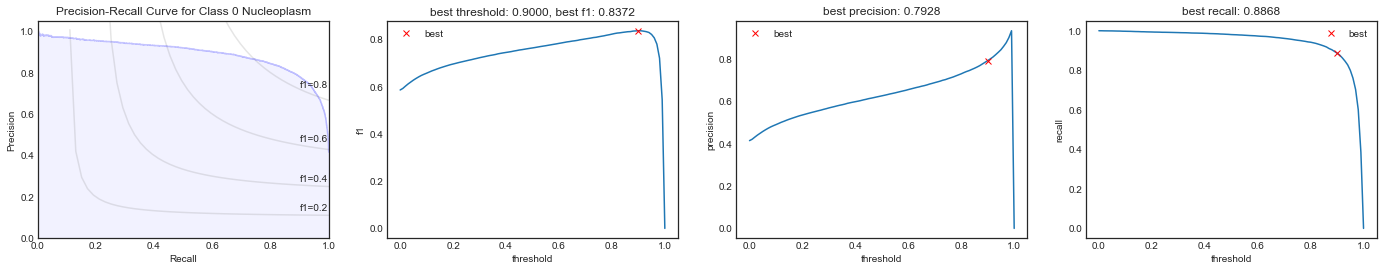

<Figure size 432x288 with 0 Axes>

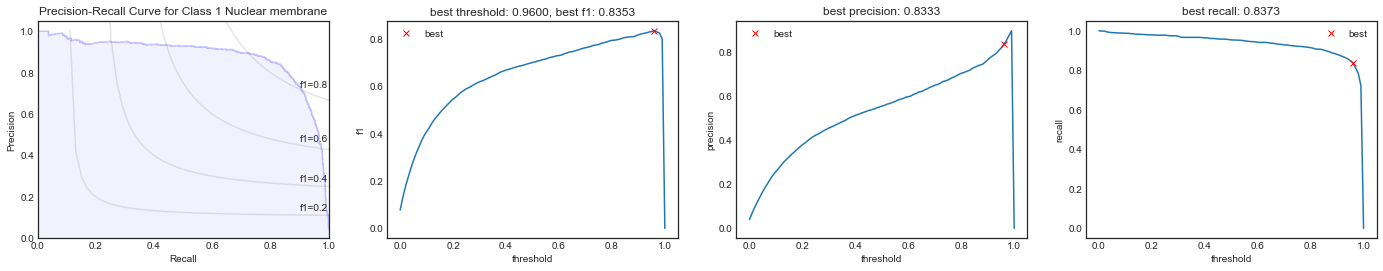

<Figure size 432x288 with 0 Axes>

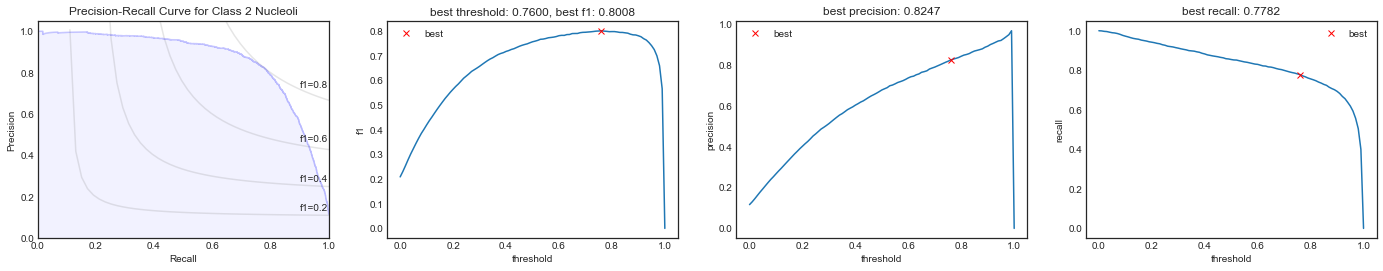

<Figure size 432x288 with 0 Axes>

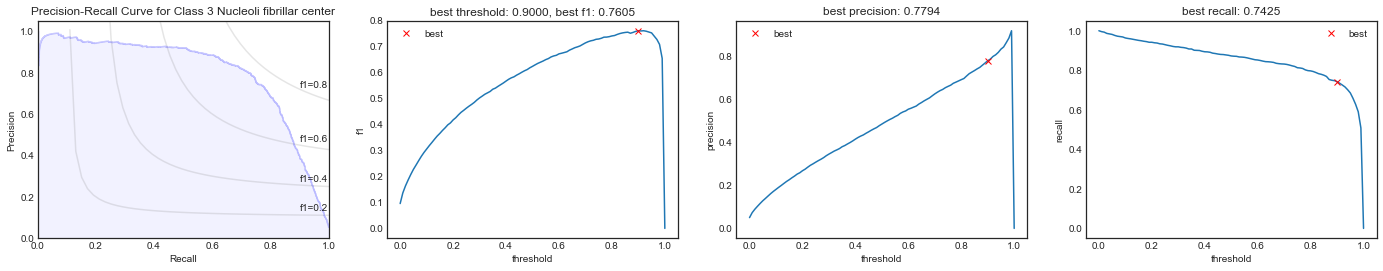

<Figure size 432x288 with 0 Axes>

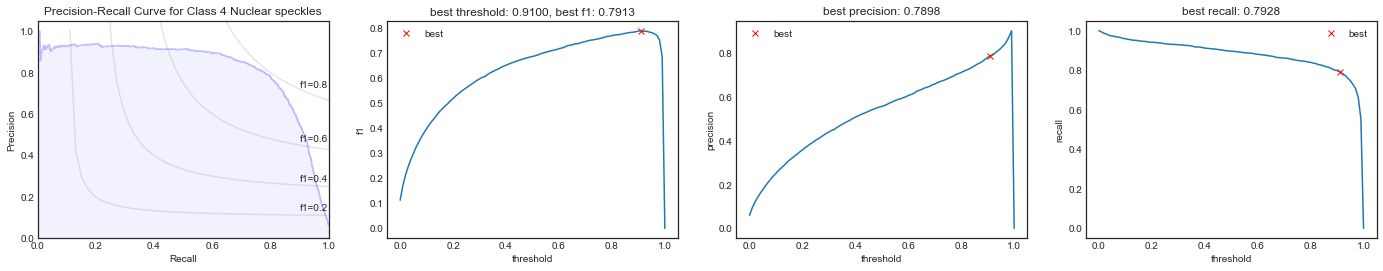

<Figure size 432x288 with 0 Axes>

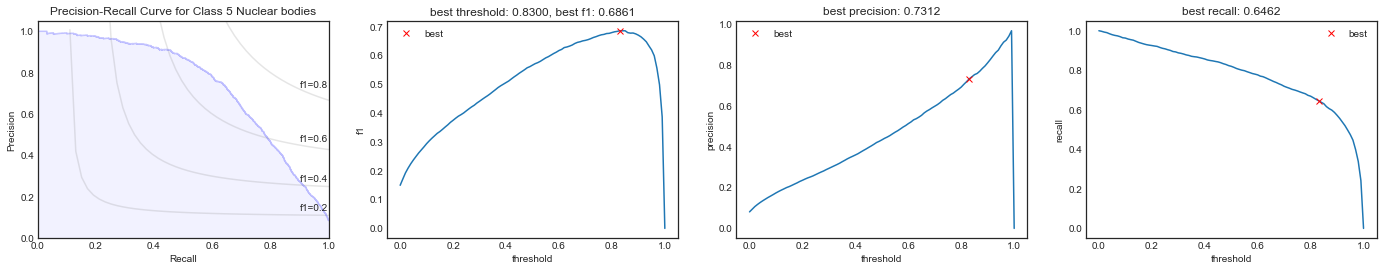

<Figure size 432x288 with 0 Axes>

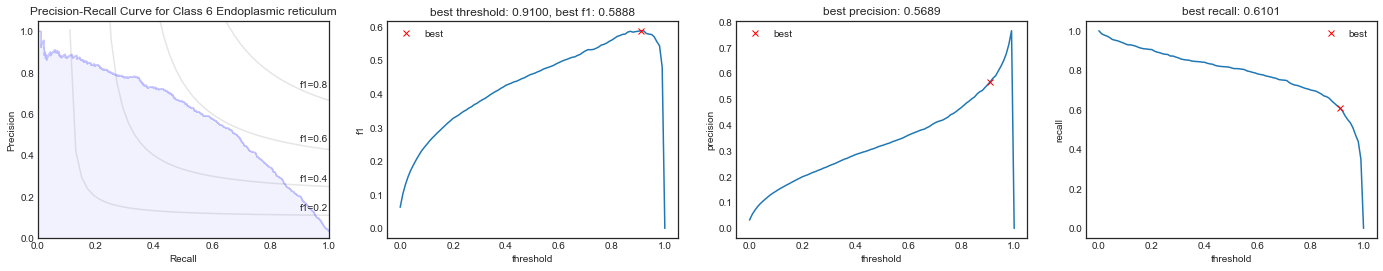

<Figure size 432x288 with 0 Axes>

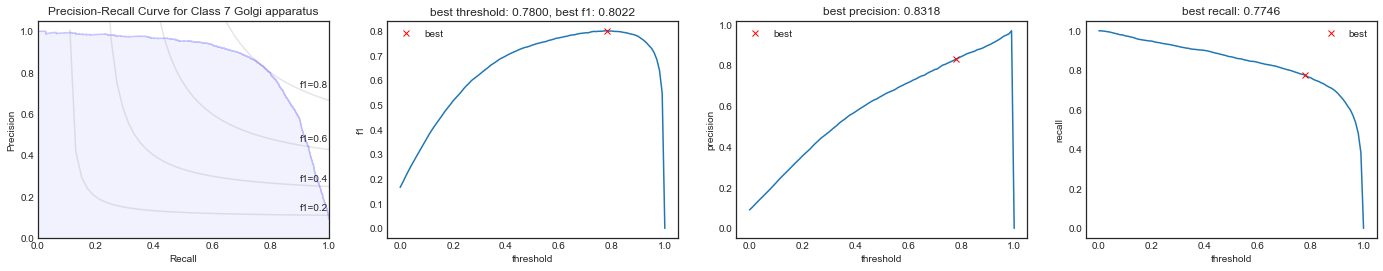

<Figure size 432x288 with 0 Axes>

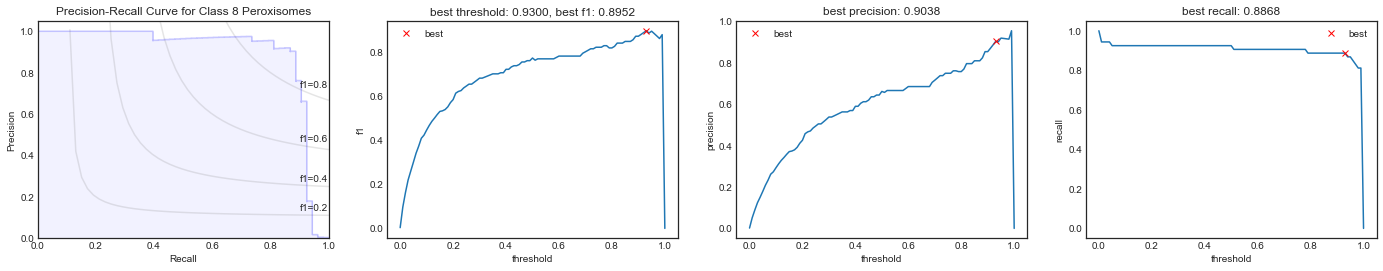

<Figure size 432x288 with 0 Axes>

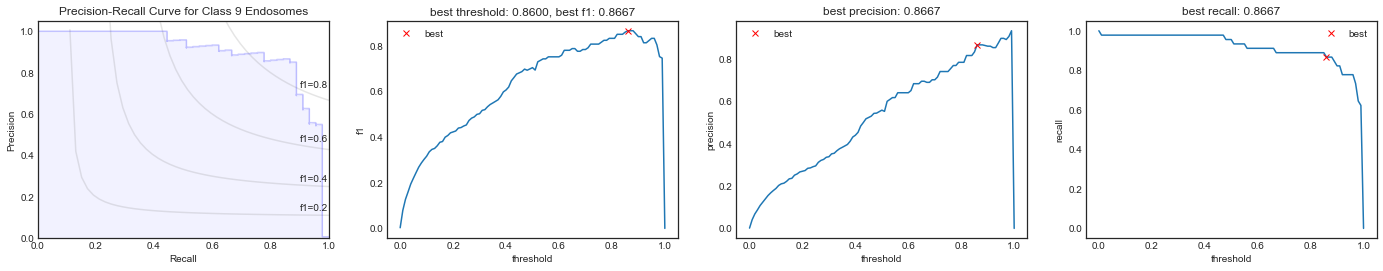

<Figure size 432x288 with 0 Axes>

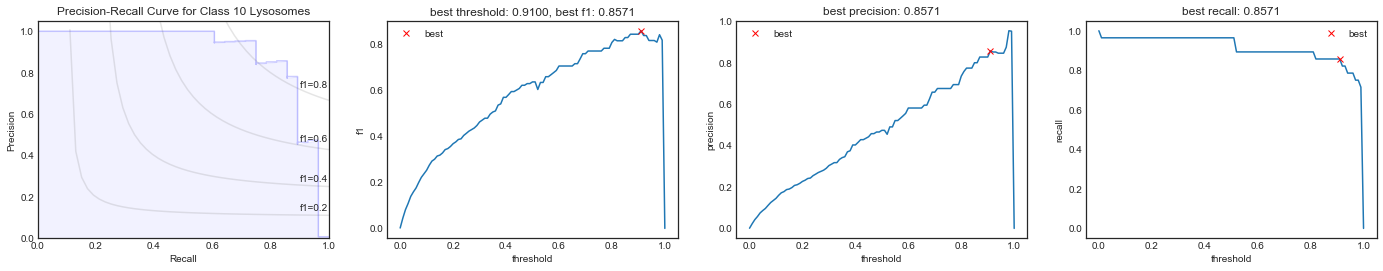

<Figure size 432x288 with 0 Axes>

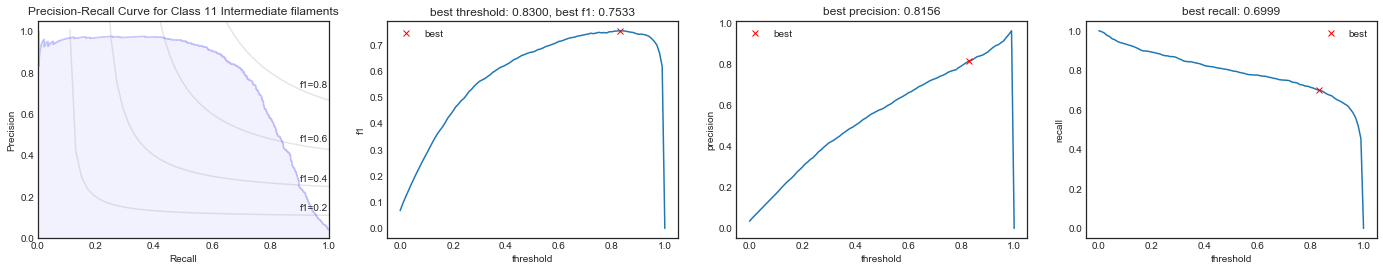

<Figure size 432x288 with 0 Axes>

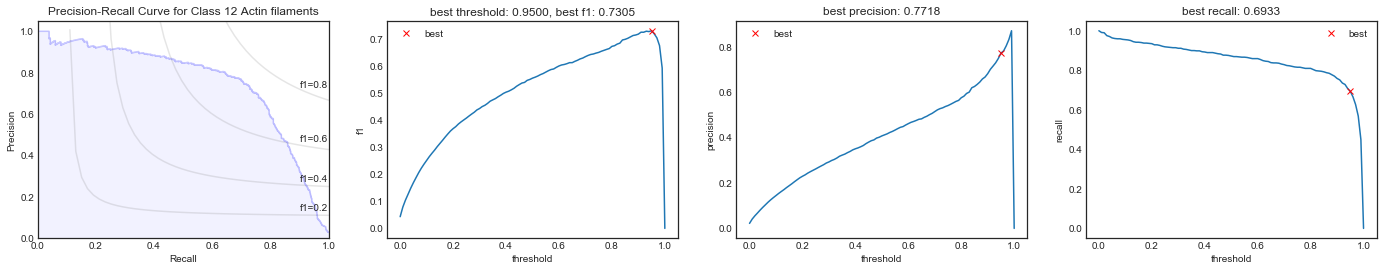

<Figure size 432x288 with 0 Axes>

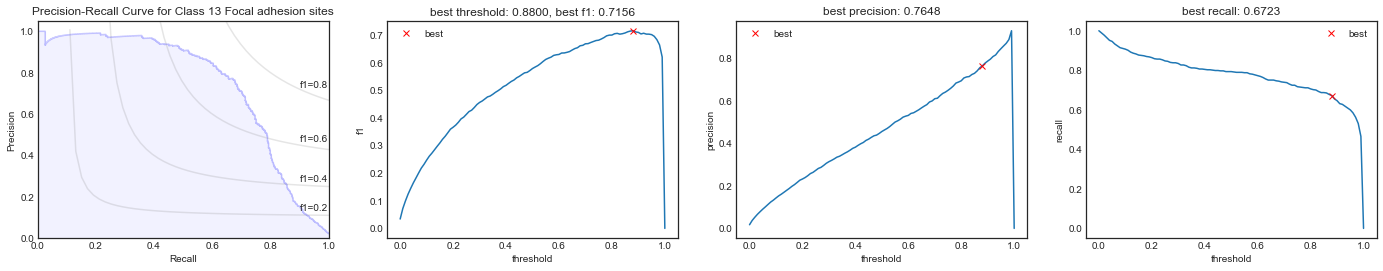

<Figure size 432x288 with 0 Axes>

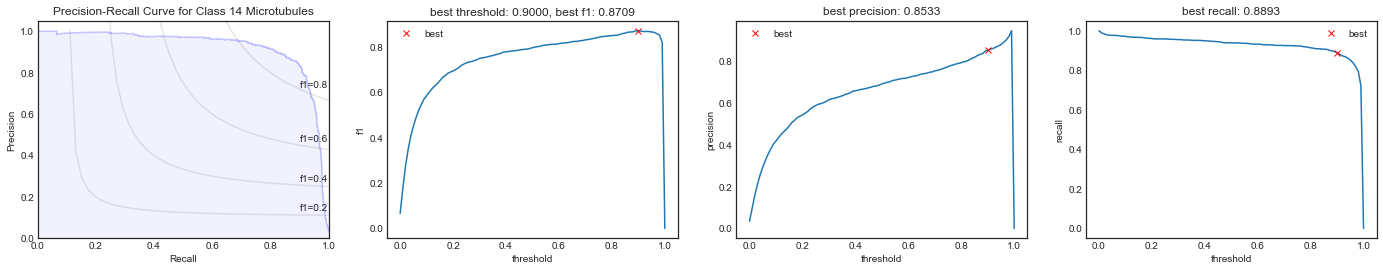

<Figure size 432x288 with 0 Axes>

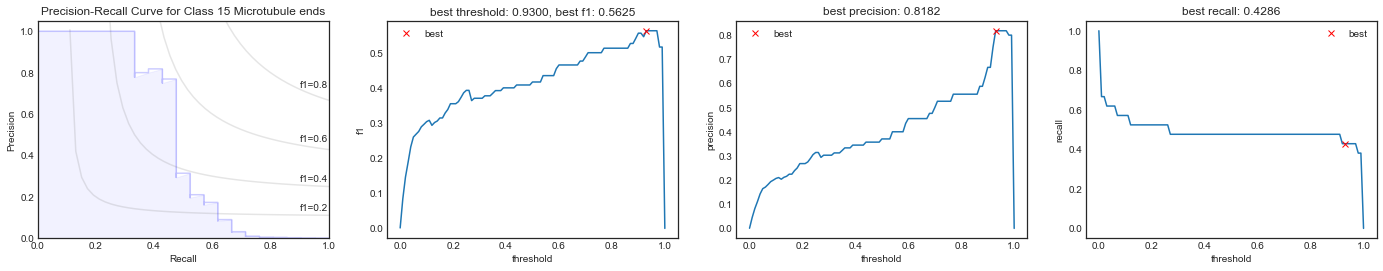

<Figure size 432x288 with 0 Axes>

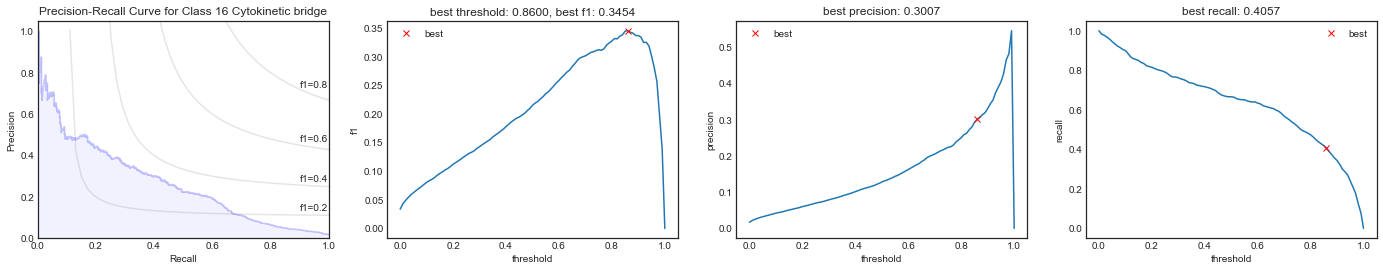

<Figure size 432x288 with 0 Axes>

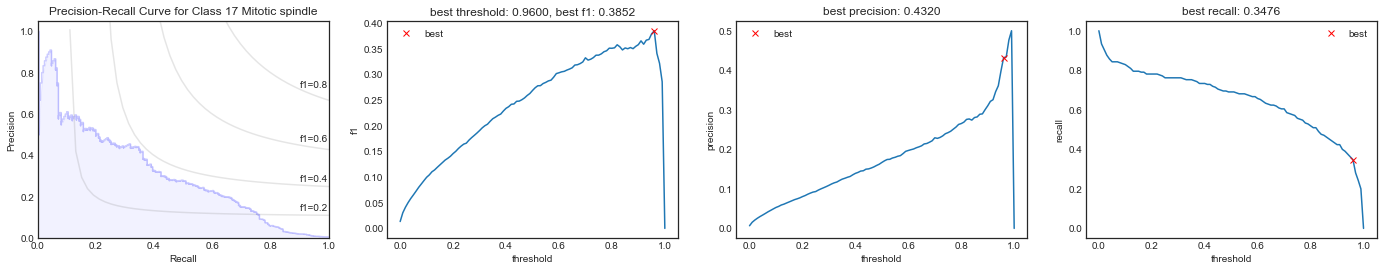

<Figure size 432x288 with 0 Axes>

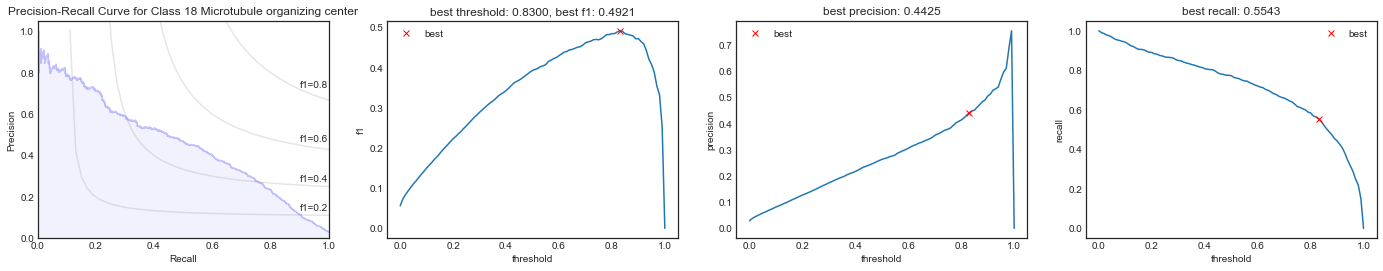

<Figure size 432x288 with 0 Axes>

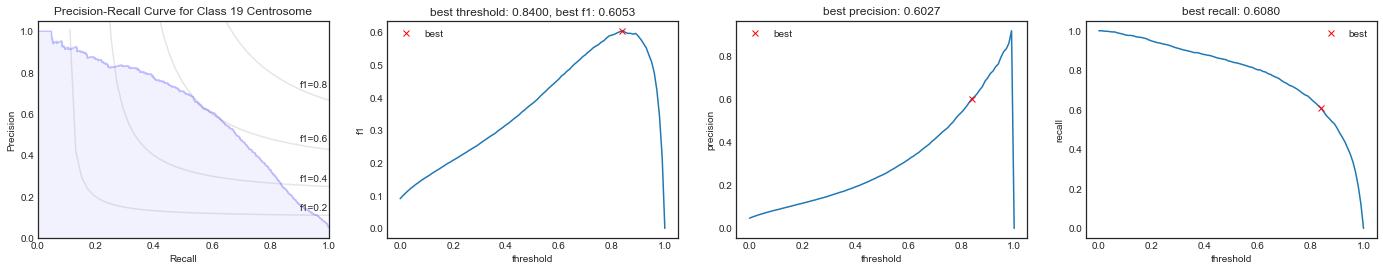

<Figure size 432x288 with 0 Axes>

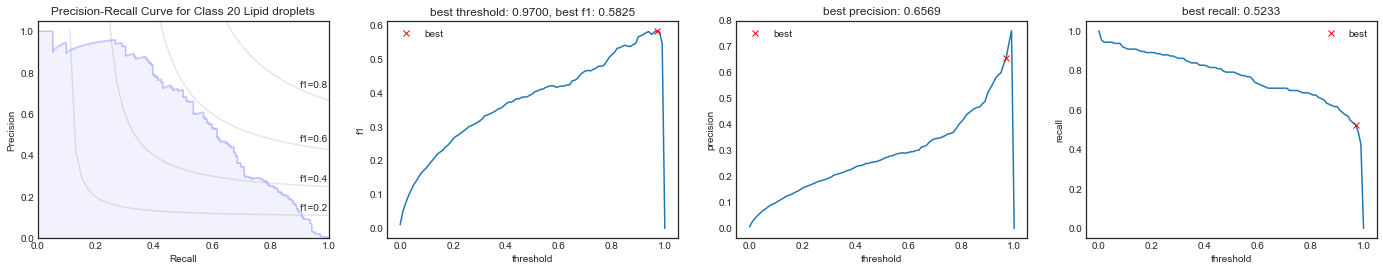

<Figure size 432x288 with 0 Axes>

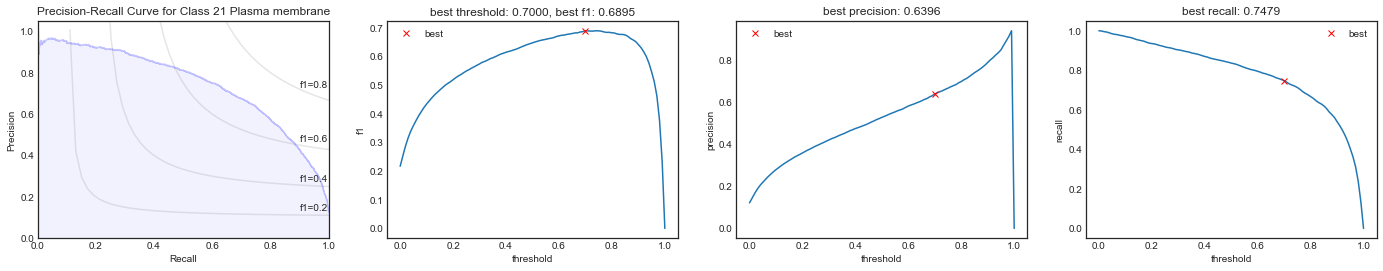

<Figure size 432x288 with 0 Axes>

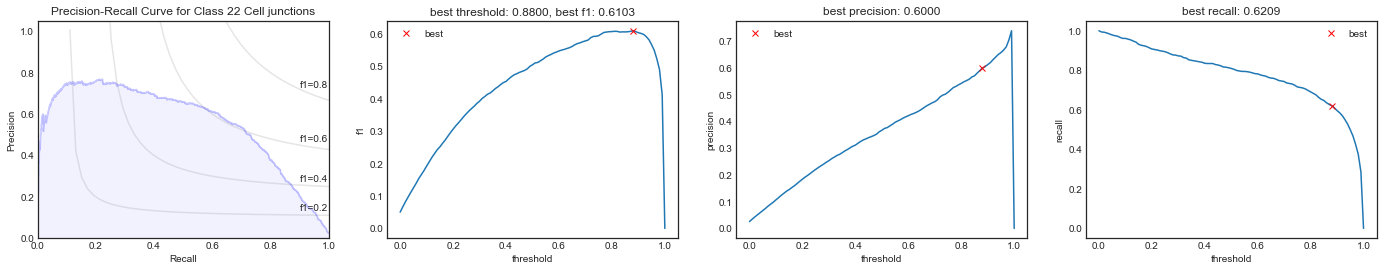

<Figure size 432x288 with 0 Axes>

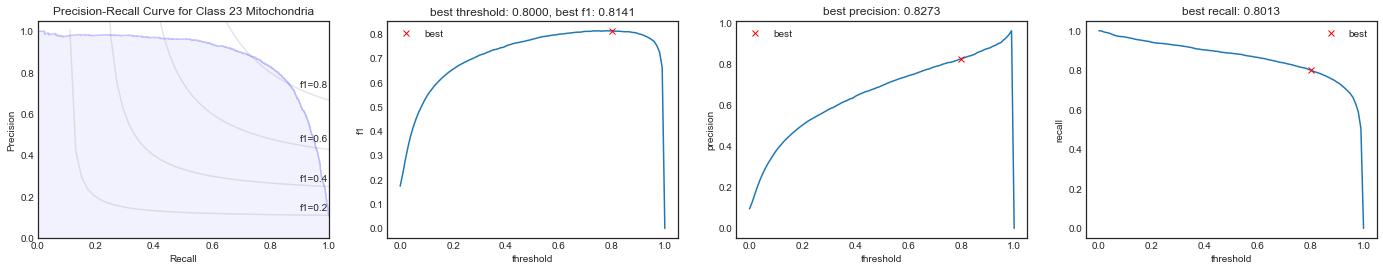

<Figure size 432x288 with 0 Axes>

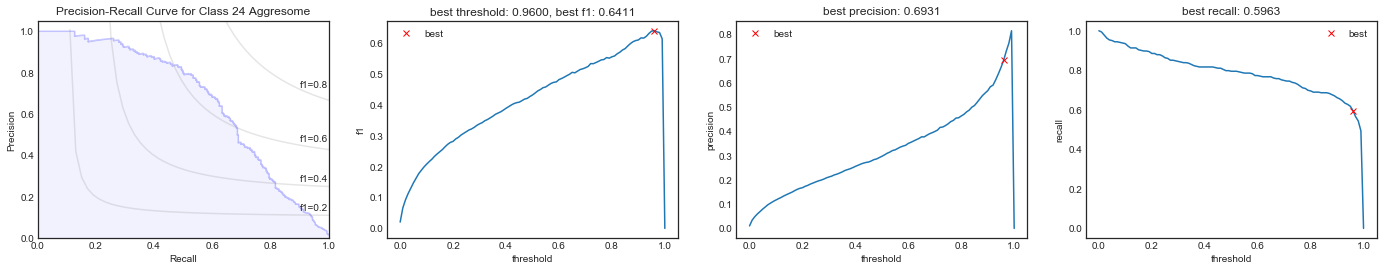

<Figure size 432x288 with 0 Axes>

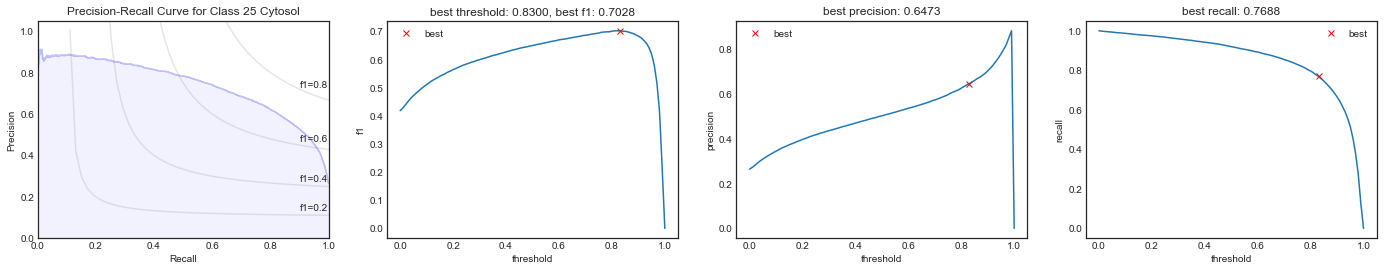

<Figure size 432x288 with 0 Axes>

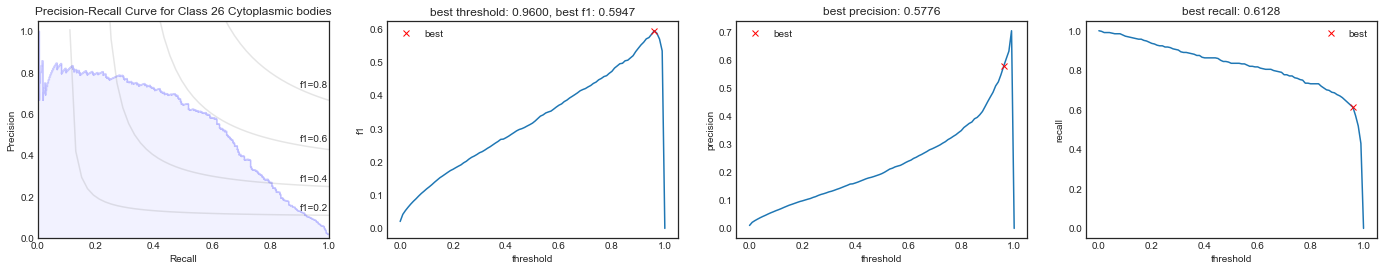

<Figure size 432x288 with 0 Axes>

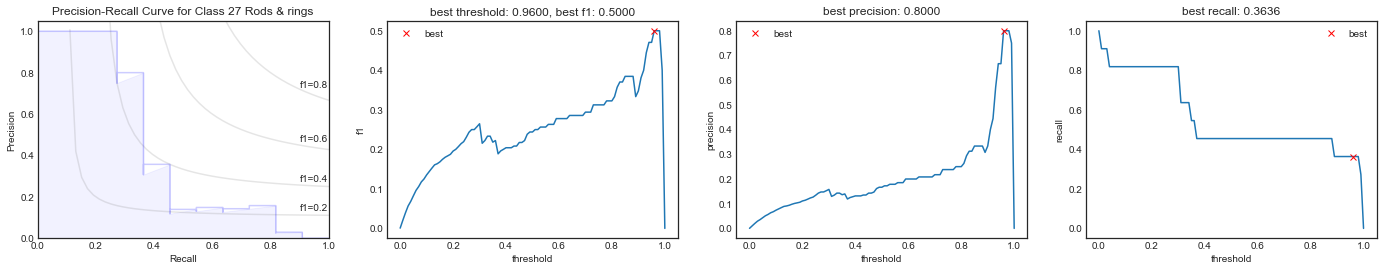

<Figure size 432x288 with 0 Axes>

In [52]:
n_classes = 28

# plot precision-recall curve for each class
precision = dict()
recall = dict()
average_precision = dict()
f_scores = np.linspace(0.2, 0.8, num=4)

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y[:, i], x[:, i])
    average_precision[i] = average_precision_score(y[:, i], x[:, i])
    
#     plt.figure()
    
#     for f_score in f_scores:
#         xf = np.linspace(0.01, 1)
#         yf = f_score * xf / (2 * xf - f_score)
#         l, = plt.plot(xf[yf >= 0], yf[yf >= 0], color='gray', alpha=0.2)
#         plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, yf[45] + 0.02))

#     plt.step(recall[i], precision[i], color='b', alpha=0.2, where='post')
#     plt.fill_between(recall[i], precision[i], alpha=0.05, color='b')

#     plt.xlabel('Recall')
#     plt.ylabel('Precision')
#     plt.ylim([0.0, 1.05])
#     plt.xlim([0.0, 1.0])
#     plt.title(LABEL_MAP[i])
    
    
    fig, axs = plt.subplots(1, 4, figsize=(24, 4))
    
    for f_score in f_scores:
        xf = np.linspace(0.01, 1)
        yf = f_score * xf / (2 * xf - f_score)
        l, = axs[0].plot(xf[yf >= 0], yf[yf >= 0], color='gray', alpha=0.2)
        axs[0].annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, yf[45] + 0.02))

    axs[0].step(recall[i], precision[i], color='b', alpha=0.2, where='post')
    axs[0].fill_between(recall[i], precision[i], alpha=0.05, color='b')

    axs[0].set_xlabel('Recall')
    axs[0].set_ylabel('Precision')
    axs[0].set_ylim([0.0, 1.05])
    axs[0].set_xlim([0.0, 1.0])
    axs[0].set_title('Precision-Recall Curve for Class ' + str(i) + ' ' + LABEL_MAP[i])
    
    
#     thresholds = np.linspace(0.4, 0.6, 101)
    thresholds = np.linspace(0., 1.0, 101)
    # for ranks
    # thresholds = np.linspace(0.8, 1.0, 101)
    fm = [f1_score(y[:,i], (x[:,i] > t).astype(int)) for t in thresholds] 

    besti = np.argmax(fm)
    bestt = thresholds[besti]
    bests = fm[besti] 
        
    axs[1].plot(thresholds, fm)
    axs[1].plot(bestt, bests, "xr", label="best")
    axs[1].set_xlabel("threshold")
    axs[1].set_ylabel("f1")
    axs[1].set_title("best threshold: %6.4f, best f1: %6.4f" % (bestt, bests))
    axs[1].legend()

    pm = [precision_score(y[:,i], (x[:,i] > t).astype(int)) for t in thresholds] 
    bestsp = pm[besti] 
        
    axs[2].plot(thresholds, pm)
    axs[2].plot(bestt, bestsp, "xr", label="best")
    axs[2].set_xlabel("threshold")
    axs[2].set_ylabel("precision")
    axs[2].set_title("best precision: %6.4f" % (bestsp))
    axs[2].legend()
    
    rm = [recall_score(y[:,i], (x[:,i] > t).astype(int)) for t in thresholds] 
    bestsr = rm[besti] 
        
    axs[3].plot(thresholds, rm)
    axs[3].plot(bestt, bestsr, "xr", label="best")
    axs[3].set_xlabel("threshold")
    axs[3].set_ylabel("recall")
    axs[3].set_title("best recall: %6.4f" % (bestsr))
    axs[3].legend()
    
    plt.show()
    plt.gcf().clear()

In [53]:
# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y.ravel(), x.ravel())

average_precision["macro"] = average_precision_score(y, x, average="macro")
print('Average precision score, macro-averaged over all classes: {0:0.3f}'
      .format(average_precision["macro"]))

average_precision["micro"] = average_precision_score(y, x, average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.3f}'
      .format(average_precision["micro"]))


Average precision score, macro-averaged over all classes: 0.704
Average precision score, micro-averaged over all classes: 0.795


In [54]:
# for i in range(len(th)):
#     print(i,np.round(th[i],decimals=2))

In [55]:
# print(np.mean(x > th,axis=0))

In [56]:
# f1_score(y, xp, average='samples')

In [57]:
f1_score(y, xp, average='micro')

0.6451525866598503

In [58]:
z = [(y,x) for y,x in zip(y,xp) if np.sum(x) == 0]
print(len(z))

11


In [59]:
# z[:5]

In [60]:
yz = np.array([t[0] for t in z])
xz = np.array([t[1] for t in z])
f1_score(yz,xz,average='macro')

0.0

0.0 0.6607037088740872 1.0


/home/sasrdw/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


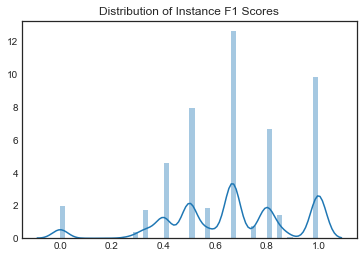

<Figure size 432x288 with 0 Axes>

In [61]:
f1b = np.array([f1_score(yi, xpi, average='binary') \
                 for yi,xpi in zip(y,xp)])
print(f1b.min(),f1b.mean(),f1b.max())
sns.distplot(f1b)
plt.title("Distribution of Instance F1 Scores")
plt.show()
plt.gcf().clear()

In [62]:
np.set_printoptions(precision=3, linewidth=200, suppress=True)
f = []
for m in mnames:
    ff = np.array(list(vp[m])).flatten()
    print(m, ff.shape)
    f.append(ff)
# print(mnames)
r = np.corrcoef(f)
print(r)   

air_g68 (870016,)
air_h68 (870016,)
airx_h67 (870016,)
cbam_h67 (870016,)
iv3_g11 (870016,)
iv3_h11 (870016,)
preresnet_g67 (870016,)
preresnet_h67 (870016,)
se_resnext_g30 (870016,)
se_resnext_h30 (870016,)
[[1.    0.923 0.867 0.884 0.818 0.832 0.93  0.907 0.904 0.901]
 [0.923 1.    0.909 0.929 0.852 0.898 0.909 0.952 0.889 0.931]
 [0.867 0.909 1.    0.915 0.837 0.886 0.873 0.916 0.855 0.897]
 [0.884 0.929 0.915 1.    0.865 0.906 0.893 0.934 0.874 0.917]
 [0.818 0.852 0.837 0.865 1.    0.919 0.828 0.855 0.82  0.856]
 [0.832 0.898 0.886 0.906 0.919 1.    0.843 0.897 0.835 0.897]
 [0.93  0.909 0.873 0.893 0.828 0.843 1.    0.933 0.902 0.903]
 [0.907 0.952 0.916 0.934 0.855 0.897 0.933 1.    0.891 0.933]
 [0.904 0.889 0.855 0.874 0.82  0.835 0.902 0.891 1.    0.943]
 [0.901 0.931 0.897 0.917 0.856 0.897 0.903 0.933 0.943 1.   ]]


In [63]:
loc = [i for i,m in enumerate(mnames) if m == special][0]
rloc = r[:,loc]
print(rloc)
order = np.argsort(rloc)
for i in range(1,min(len(rloc)+1,7)):
    print('%5.3f' % rloc[order[-i]],mnames[order[-i]])

[0.923 1.    0.909 0.929 0.852 0.898 0.909 0.952 0.889 0.931]
1.000 air_h68
0.952 preresnet_h67
0.931 se_resnext_h30
0.929 cbam_h67
0.923 air_g68
0.909 airx_h67


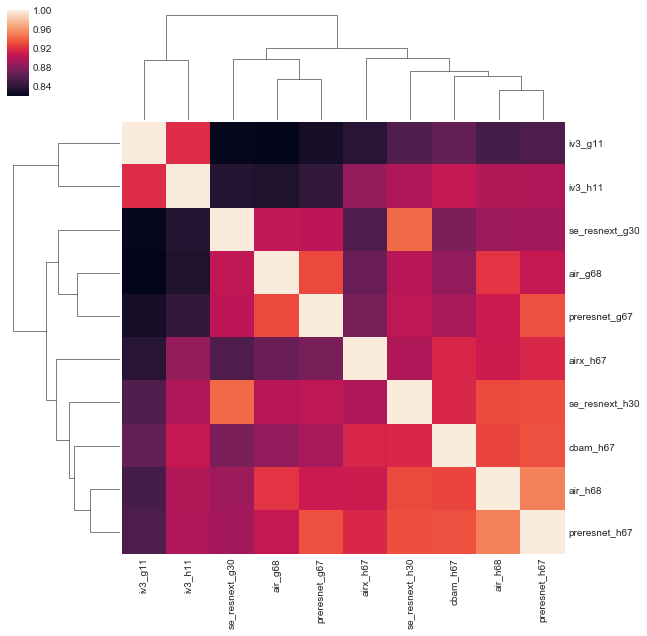

In [64]:
d = pd.DataFrame(r, columns=mnames)
d['id'] = mnames
d.set_index('id',inplace=True)
del d.index.name

sns.clustermap(d)


# import scipy.cluster.hierarchy as hc
# from matplotlib import pyplot
# link = hc.linkage(d.values, method='centroid')
# o1 = hc.leaves_list(link)

# mat = d.iloc[o1,:]
# mat = mat.iloc[:, o1[::-1]]
# pyplot.imshow(mat)

In [65]:
# f = []
# for m in mnames:
#     f.append(np.array(list(vp[m])).flatten())
# print(mnames)
# print(np.corrcoef(f))   

In [66]:
print(f[0].min(),f[0].max())

5.199339475012162e-10 0.9999999200061678


In [67]:
# # model-specific global thresholds
# # compute best single logit threshold for computed ensemble

# # for probabilities
# thresholds = np.linspace(0.1, 0.9, 1001)

# # for logits
# # thresholds = np.linspace(-1, 1, 101)

# # for ranks
# # thresholds = np.linspace(0.9, 1, 101)

# # thresholds = [-0.4]

# fname = 'mthresh.pkl'
# if os.path.isfile(fname): mthresh = pickle.load(open(fname,'rb'))
# else: mthresh = {}
# # mthresh = {}

# for i in range(nm):
# # for i in [3]:

#     mname = vp.columns[i+offset]

#     tv = np.array(list(vp.iloc[:,offset+i].values))
    
#     if mname in mthresh or np.sum(np.isnan(tv)) > 0: continue

#     scores = np.array([f1_score(y, np.int32(tv > threshold),
#                                  average='macro') for threshold in thresholds])

#     besta = np.argmax(scores)
#     threshold_best = thresholds[besta]
#     score_best = scores[besta]
#     print(i, mname, "%4.2f" % threshold_best, "%6.4f" % score_best)
#     mthresh[mname] = threshold_best
    
#     plt.plot(thresholds, scores)
#     plt.plot(threshold_best, score_best, "xr", label="best")
#     plt.xlabel("threshold")
#     plt.ylabel("f1")
# #     plt.title(mname + " f1 vs threshold (%6.4f, %6.4f)" % (threshold_best, score_best))
#     plt.title(mname + " threshold: %6.4f  f1: %6.4f" % (threshold_best, score_best))
#     plt.legend()
#     plt.show()
#     plt.gcf().clear()

# pickle.dump(mthresh,open(fname,'wb'))
# print(mthresh)

In [68]:
print(vp.columns, vp.shape)

Index(['Target', 'fold', 'y', 'air_g68', 'air_h68', 'airx_h67', 'cbam_h67',
       'iv3_g11', 'iv3_h11', 'preresnet_g67', 'preresnet_h67',
       'se_resnext_g30', 'se_resnext_h30'],
      dtype='object') (31072, 13)


In [69]:
# # model- and class-specific thresholds
# # compute best logit threshold for computed ensemble

# # thresholds = np.linspace(-2, 2, 101)

# # thresholds = [-0.4]

# fname = 'cthresh.pkl'
# # if os.path.isfile(fname): cthresh = pickle.load(open(fname,'rb'))
# cthresh = {}

# for i in range(nm):
# # for i in [2]:

#     mname = vp.columns[i+offset]
#     tv = np.array(list(vp.iloc[:,offset+i].values))

#     fm = [[f1_score(y[:,j], (tv[:,j] > t).astype(int)) \
#            for t in thresholds] for j in range(y.shape[1])]
    
#     besti = [np.argmax(f) for f in fm]
#     bestt = [thresholds[b] for b in besti]
#     bests = [f[b] for f,b in zip(fm,besti)]
#     print(mname, np.mean(bests))
    
#     td = {}
#     for j in range(y.shape[1]):
#         # print()
#         # print(j, LABEL_MAP[j], "%4.2f" % bestt[j], "%6.4f" % bests[j])
        
#         # print(j, "%4.2f" % bestt[j], "%6.4f" % bests[j], LABEL_MAP[j])
        
#         # print(cm[j], '%4.2f' % fm[j])
#         # print('')
#         td[j] = np.round(bestt[j],decimals=2)
    
#     cthresh[mname] = td
#     print()
    
# pickle.dump(cthresh,open(fname,'wb'))
# # print(cthresh)
# print(fname)



hillclimbing f1 fold 1 class 0 Nucleoplasm

model 0 f1 0.6988 0.913 0.8658 0.862 air_g68
model 1 f1 0.6829 0.912 0.8639 0.895 air_h68
model 2 f1 0.6297 0.873 0.8520 0.847 airx_h67
model 3 f1 0.6849 0.911 0.8618 0.890 cbam_h67
model 4 f1 0.6849 0.946 0.8555 0.950 iv3_g11
model 5 f1 0.6748 0.904 0.8516 0.902 iv3_h11
model 6 f1 0.6825 0.935 0.8641 0.873 preresnet_g67
model 7 f1 0.6939 0.906 0.8632 0.847 preresnet_h67
model 8 f1 0.6838 0.856 0.8602 0.846 se_resnext_g30
model 9 f1 0.6963 0.835 0.8629 0.842 se_resnext_h30
0  train 0.6988  val 0.8658*   air_g68
1  train 0.7121  val 0.8692*   se_resnext_h30
2  train 0.7125  val 0.8688    iv3_g11
3  train 0.7159  val 0.8711*   cbam_h67
4  train 0.7173  val 0.8720*   preresnet_g67
    try dropping 0 air_g68 0.7136 0.8721
    try dropping 9 se_resnext_h30 0.7138 0.8712
    try dropping 4 iv3_g11 0.7155 0.8720
    try dropping 3 cbam_h67 0.7129 0.8708
    try dropping 6 preresnet_g67 0.7151 0.8713
    try dropping 3 cbam_h67 0.7129 0.8708
5  tra

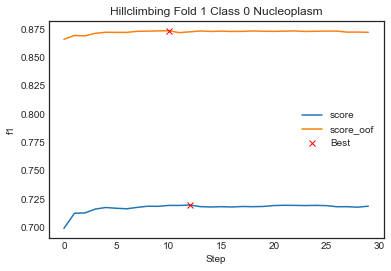

    step  midx     score  score_oof             mod      f1_0
0      0     0  0.698776   0.865808         air_g68  0.698776
1      1     9  0.712117   0.869155  se_resnext_h30  0.696277
2      2     4  0.712451   0.868811         iv3_g11  0.684858
3      3     3  0.715879   0.871066        cbam_h67  0.684872
4      4     6  0.717256   0.872000   preresnet_g67  0.682496
5      5     3  0.716557   0.871902        cbam_h67  0.684872
6      6     8  0.716127   0.871909  se_resnext_g30  0.683785
7      7     7  0.717374   0.872839   preresnet_h67  0.693933
8      8     6  0.718374   0.872990   preresnet_g67  0.682496
9      9     3  0.718276   0.873182        cbam_h67  0.684872
10    10     9  0.719095   0.873341  se_resnext_h30  0.696277

      weight             mod      f1_0
midx                                  
0          1         air_g68  0.698776
3          3        cbam_h67  0.684872
4          1         iv3_g11  0.684858
6          2   preresnet_g67  0.682496
7          1   preres

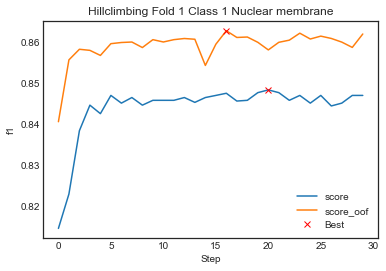

    step  midx     score  score_oof             mod      f1_0
0      0     6  0.814645   0.840607   preresnet_g67  0.814645
1      1     9  0.823009   0.855655  se_resnext_h30  0.811280
2      2     8  0.838428   0.858238  se_resnext_g30  0.803612
3      3     0  0.844639   0.857974         air_g68  0.773893
4      4     6  0.842572   0.856739   preresnet_g67  0.814645
5      5     8  0.847007   0.859599  se_resnext_g30  0.803612
6      6     4  0.845133   0.859885         iv3_g11  0.756522
7      7     9  0.846491   0.860000  se_resnext_h30  0.811280
8      8     6  0.844639   0.858659   preresnet_g67  0.814645
9      9     8  0.845815   0.860577  se_resnext_g30  0.803612
10    10     0  0.845815   0.860010         air_g68  0.773893
11    11     6  0.845815   0.860577   preresnet_g67  0.814645
12    12     4  0.846491   0.860857         iv3_g11  0.756522
13    13     9  0.845316   0.860675  se_resnext_h30  0.811280
14    14     6  0.846491   0.854301   preresnet_g67  0.814645
15    15

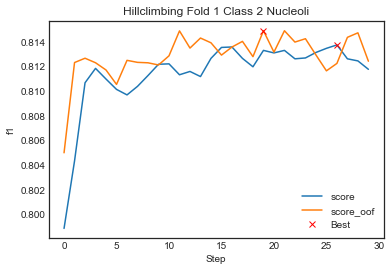

    step  midx     score  score_oof             mod      f1_0
0      0     0  0.798873   0.805010         air_g68  0.798873
1      1     9  0.804348   0.812333  se_resnext_h30  0.780303
2      2     0  0.810690   0.812683         air_g68  0.798873
3      3     7  0.811859   0.812316   preresnet_h67  0.791713
4      4     3  0.810993   0.811728        cbam_h67  0.780972
5      5     9  0.810155   0.810559  se_resnext_h30  0.780303
6      6     6  0.809708   0.812512   preresnet_g67  0.793315
7      7     8  0.810401   0.812348  se_resnext_g30  0.770968
8      8     8  0.811280   0.812312  se_resnext_g30  0.770968
9      9     7  0.812194   0.812135   preresnet_h67  0.791713
10    10     5  0.812227   0.812879         iv3_h11  0.748307
11    11     2  0.811341   0.814900        airx_h67  0.790412
12    12     3  0.811610   0.813508        cbam_h67  0.780972
13    13     8  0.811196   0.814321  se_resnext_g30  0.770968
14    14     5  0.812671   0.813936         iv3_h11  0.748307
15    15

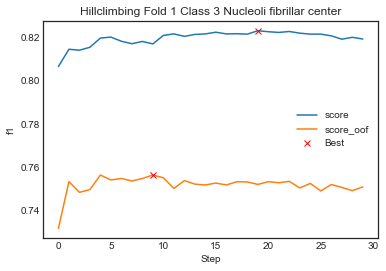

   step  midx     score  score_oof             mod      f1_0
0     0     3  0.806356   0.731707        cbam_h67  0.806356
1     1     7  0.814313   0.753286   preresnet_h67  0.790960
2     2     3  0.813886   0.748341        cbam_h67  0.806356
3     3     9  0.815238   0.749618  se_resnext_h30  0.782692
4     4     0  0.819484   0.756320         air_g68  0.794727
5     5     0  0.819923   0.754049         air_g68  0.794727
6     6     2  0.818008   0.754736        airx_h67  0.786060
7     7     4  0.816874   0.753594         iv3_g11  0.762728
8     8     1  0.817922   0.754717         air_h68  0.781784
9     9     2  0.816794   0.756353        airx_h67  0.786060

      weight             mod      f1_0
midx                                  
0          2         air_g68  0.794727
1          1         air_h68  0.781784
2          2        airx_h67  0.786060
3          2        cbam_h67  0.806356
4          1         iv3_g11  0.762728
7          1   preresnet_h67  0.790960
9          1  se

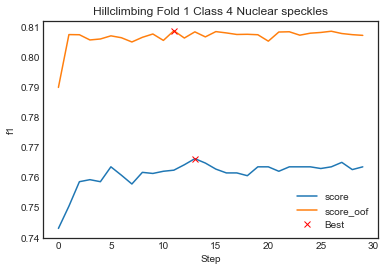

    step  midx     score  score_oof             mod      f1_0
0      0     6  0.743083   0.789972   preresnet_g67  0.743083
1      1     2  0.750476   0.807545        airx_h67  0.686941
2      2     6  0.758621   0.807497   preresnet_g67  0.743083
3      3     6  0.759295   0.805760   preresnet_g67  0.743083
4      4     8  0.758621   0.806084  se_resnext_g30  0.702595
5      5     6  0.763566   0.807129   preresnet_g67  0.743083
6      6     6  0.760784   0.806503   preresnet_g67  0.743083
7      7     1  0.757856   0.805090         air_h68  0.702259
8      8     6  0.761726   0.806637   preresnet_g67  0.743083
9      9     2  0.761364   0.807742        airx_h67  0.686941
10    10     6  0.762089   0.805609   preresnet_g67  0.743083
11    11     8  0.762452   0.808824  se_resnext_g30  0.702595

      weight             mod      f1_0
midx                                  
1          1         air_h68  0.702259
2          2        airx_h67  0.686941
6          7   preresnet_g67  0.74308

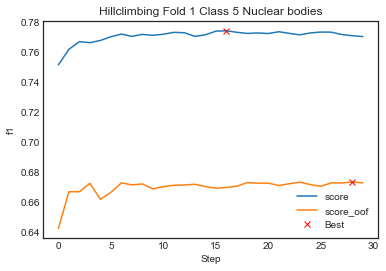

    step  midx     score  score_oof             mod      f1_0
0      0     0  0.751282   0.642208         air_g68  0.751282
1      1     1  0.761655   0.666667         air_h68  0.727038
2      2     9  0.766773   0.666667  se_resnext_h30  0.726287
3      3     3  0.766043   0.672274        cbam_h67  0.749827
4      4     8  0.767561   0.661599  se_resnext_g30  0.720253
5      5     6  0.770006   0.666248   preresnet_g67  0.750163
6      6     6  0.771795   0.672561   preresnet_g67  0.750163
7      7     3  0.770296   0.671254        cbam_h67  0.749827
8      8     0  0.771593   0.671865         air_g68  0.751282
9      9     8  0.770992   0.668546  se_resnext_g30  0.720253
10    10     1  0.771704   0.670067         air_h68  0.727038
11    11     3  0.772959   0.670980        cbam_h67  0.749827
12    12     0  0.772698   0.671150         air_g68  0.751282
13    13     1  0.770305   0.671637         air_h68  0.727038
14    14     9  0.771318   0.670135  se_resnext_h30  0.726287
15    15

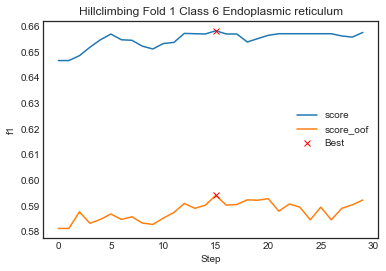

    step  midx     score  score_oof             mod      f1_0
0      0     9  0.646604   0.581140  se_resnext_h30  0.646604
1      1     9  0.646604   0.581140  se_resnext_h30  0.646604
2      2     6  0.648506   0.587595   preresnet_g67  0.580167
3      3     3  0.651786   0.583149        cbam_h67  0.594142
4      4     4  0.654709   0.584648         iv3_g11  0.592767
5      5     9  0.656934   0.586758  se_resnext_h30  0.646604
6      6     4  0.654709   0.584648         iv3_g11  0.592767
7      7     4  0.654512   0.585670         iv3_g11  0.592767
8      8     4  0.652213   0.583238         iv3_g11  0.592767
9      9     9  0.651119   0.582694  se_resnext_h30  0.646604
10    10     9  0.653240   0.585162  se_resnext_h30  0.646604
11    11     6  0.653676   0.587353   preresnet_g67  0.580167
12    12     9  0.657194   0.590858  se_resnext_h30  0.646604
13    13     0  0.657066   0.588970         air_g68  0.598177
14    14     0  0.656961   0.590198         air_g68  0.598177
15    15

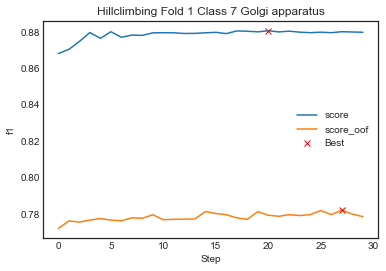

    step  midx     score  score_oof             mod      f1_0
0      0     0  0.867998   0.772056         air_g68  0.867998
1      1     9  0.870335   0.776182  se_resnext_h30  0.858472
2      2     6  0.874660   0.775524   preresnet_g67  0.855346
3      3     0  0.879561   0.776625         air_g68  0.867998
4      4     4  0.876369   0.777471         iv3_g11  0.841202
5      5     0  0.880000   0.776618         air_g68  0.867998
6      6     0  0.876935   0.776243         air_g68  0.867998
7      7     4  0.878143   0.777854         iv3_g11  0.841202
8      8     0  0.877992   0.777623         air_g68  0.867998
9      9     9  0.879377   0.779557  se_resnext_h30  0.858472
10    10     0  0.879438   0.776826         air_g68  0.867998
11    11     6  0.879405   0.777043   preresnet_g67  0.855346
12    12     0  0.879026   0.777123         air_g68  0.867998
13    13     3  0.879095   0.777235        cbam_h67  0.845767
14    14     5  0.879405   0.781335         iv3_h11  0.833333
15    15

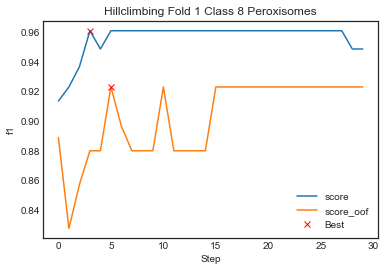

   step  midx     score  score_oof             mod      f1_0
0     0     9  0.913580   0.888889  se_resnext_h30  0.913580
1     1     4  0.923077   0.827586         iv3_g11  0.911392
2     2     8  0.936709   0.857143  se_resnext_g30  0.909091
3     3     0  0.961039   0.880000         air_g68  0.906667
4     4     8  0.948718   0.880000  se_resnext_g30  0.909091
5     5     2  0.961039   0.923077        airx_h67  0.891892

      weight             mod      f1_0
midx                                  
0          1         air_g68  0.906667
2          1        airx_h67  0.891892
4          1         iv3_g11  0.911392
8          2  se_resnext_g30  0.909091
9          1  se_resnext_h30  0.913580


hillclimbing f1 fold 1 class 9 Endosomes

model 0 f1 0.8608 0.616 0.8000 0.616 air_g68
model 1 f1 0.9000 0.874 0.7692 0.616 air_h68
model 2 f1 0.7463 0.916 0.6667 0.384 airx_h67
model 3 f1 0.8451 0.854 0.4706 0.483 cbam_h67
model 4 f1 0.7955 0.956 0.8333 0.963 iv3_g11
model 5 f1 0.7333 0.889 0.92

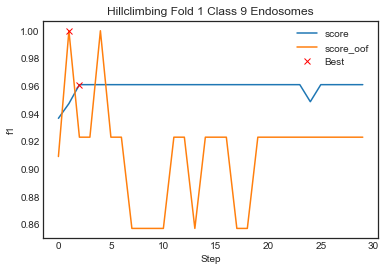

   step  midx     score  score_oof             mod      f1_0
0     0     9  0.936709   0.909091  se_resnext_h30  0.936709
1     1     6  0.947368   1.000000   preresnet_g67  0.885714

      weight             mod      f1_0
midx                                  
6          1   preresnet_g67  0.885714
9          1  se_resnext_h30  0.936709


hillclimbing f1 fold 1 class 10 Lysosomes

model 0 f1 0.8235 0.847 0.5000 0.759 air_g68
model 1 f1 0.8364 0.829 1.0000 0.902 air_h68
model 2 f1 0.8679 0.847 0.6667 0.759 airx_h67
model 3 f1 0.8462 0.815 0.6667 0.759 cbam_h67
model 4 f1 0.8333 0.985 0.4000 0.946 iv3_g11
model 5 f1 0.7586 0.956 0.6667 0.902 iv3_h11
model 6 f1 0.8148 0.532 0.5000 0.902 preresnet_g67
model 7 f1 0.9020 0.847 0.4000 0.616 preresnet_h67
model 8 f1 0.8627 0.204 1.0000 0.616 se_resnext_g30
model 9 f1 0.9020 0.384 1.0000 0.759 se_resnext_h30
0  train 0.9020  val 0.4000*   preresnet_h67
1  train 0.9200  val 0.5000*   airx_h67
2  train 0.9200  val 1.0000*   se_resnext_g30
3  tra

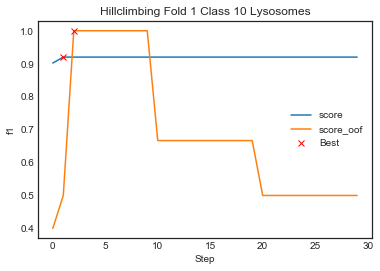

   step  midx     score  score_oof             mod      f1_0
0     0     7  0.901961        0.4   preresnet_h67  0.901961
1     1     2  0.920000        0.5        airx_h67  0.867925
2     2     8  0.920000        1.0  se_resnext_g30  0.862745

      weight             mod      f1_0
midx                                  
2          1        airx_h67  0.867925
7          1   preresnet_h67  0.901961
8          1  se_resnext_g30  0.862745


hillclimbing f1 fold 1 class 11 Intermediate filaments

model 0 f1 0.8170 0.945 0.6979 0.800 air_g68
model 1 f1 0.8098 0.864 0.7154 0.748 air_h68
model 2 f1 0.7058 0.949 0.7026 0.849 airx_h67
model 3 f1 0.7936 0.875 0.7048 0.759 cbam_h67
model 4 f1 0.7969 0.989 0.6961 0.957 iv3_g11
model 5 f1 0.8077 0.869 0.6859 0.895 iv3_h11
model 6 f1 0.8086 0.936 0.6911 0.823 preresnet_g67
model 7 f1 0.8229 0.869 0.7106 0.757 preresnet_h67
model 8 f1 0.8301 0.663 0.7281 0.581 se_resnext_g30
model 9 f1 0.8257 0.620 0.7327 0.638 se_resnext_h30
0  train 0.8301  val 0.7

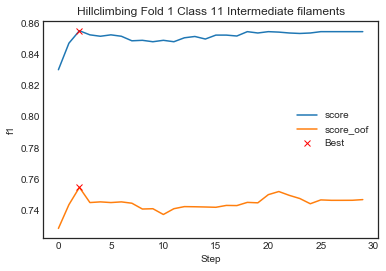

   step  midx     score  score_oof             mod      f1_0
0     0     8  0.830078   0.728078  se_resnext_g30  0.830078
1     1     0  0.847128   0.743330         air_g68  0.817038
2     2     9  0.855131   0.754448  se_resnext_h30  0.825706

      weight             mod      f1_0
midx                                  
0          1         air_g68  0.817038
8          1  se_resnext_g30  0.830078
9          1  se_resnext_h30  0.825706


hillclimbing f1 fold 1 class 12 Actin filaments

model 0 f1 0.7620 0.949 0.6158 0.953 air_g68
model 1 f1 0.8094 0.933 0.6626 0.948 air_h68
model 2 f1 0.7660 0.808 0.5847 0.842 airx_h67
model 3 f1 0.7555 0.935 0.6407 0.860 cbam_h67
model 4 f1 0.7256 0.990 0.6133 0.988 iv3_g11
model 5 f1 0.7578 0.970 0.6103 0.956 iv3_h11
model 6 f1 0.7241 0.938 0.6198 0.883 preresnet_g67
model 7 f1 0.7988 0.948 0.6378 0.854 preresnet_h67
model 8 f1 0.7478 0.865 0.6527 0.899 se_resnext_g30
model 9 f1 0.7958 0.899 0.6818 0.811 se_resnext_h30
0  train 0.8094  val 0.6626*   

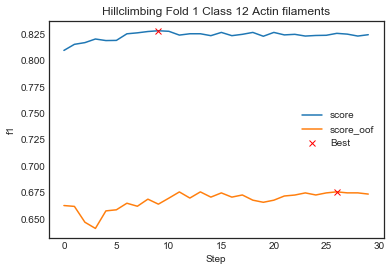

    step  midx     score  score_oof             mod      f1_0
0      0     1  0.809384   0.662595         air_h68  0.809384
1      1     5  0.815152   0.661786         iv3_h11  0.757801
2      2     7  0.816770   0.646809   preresnet_h67  0.798825
3      3     7  0.820189   0.640950   preresnet_h67  0.798825
4      4     8  0.818713   0.657534  se_resnext_g30  0.747826
5      5     2  0.818874   0.658574        airx_h67  0.766021
6      6     9  0.825112   0.664789  se_resnext_h30  0.795796
7      7     0  0.826021   0.661932         air_g68  0.762040
8      8     4  0.827273   0.668639         iv3_g11  0.725618
9      9     0  0.828006   0.663912         air_g68  0.762040
10    10     5  0.827481   0.669604         iv3_h11  0.757801
11    11     6  0.823890   0.675477   preresnet_g67  0.724092
12    12     4  0.825153   0.669683         iv3_g11  0.725618
13    13     4  0.825153   0.675516         iv3_g11  0.725618
14    14     5  0.823349   0.670571         iv3_h11  0.757801
15    15

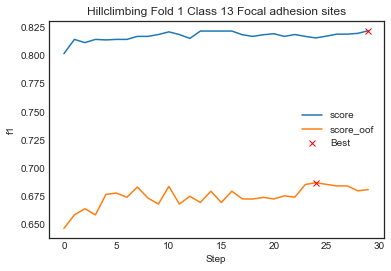

    step  midx     score  score_oof             mod      f1_0
0      0     9  0.801572   0.646341  se_resnext_h30  0.801572
1      1     4  0.814229   0.658385         iv3_g11  0.715232
2      2     4  0.811359   0.663812         iv3_g11  0.715232
3      3     9  0.814229   0.658385  se_resnext_h30  0.801572
4      4     3  0.813765   0.676533        cbam_h67  0.747628
5      5     5  0.814229   0.677755         iv3_h11  0.775934
6      6     9  0.814229   0.674009  se_resnext_h30  0.801572
7      7     1  0.816901   0.683128         air_h68  0.772816
8      8     5  0.816901   0.673387         iv3_h11  0.775934
9      9     5  0.818548   0.668000         iv3_h11  0.775934
10    10     9  0.820926   0.683652  se_resnext_h30  0.801572
11    11     4  0.818548   0.668000         iv3_g11  0.715232
12    12     9  0.815109   0.674897  se_resnext_h30  0.801572
13    13     5  0.821643   0.669355         iv3_h11  0.775934
14    14     4  0.821643   0.679406         iv3_g11  0.715232
15    15

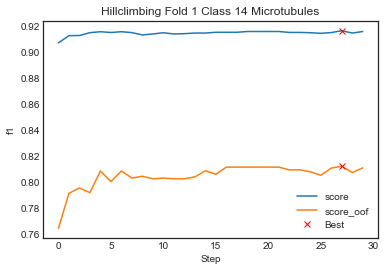

    step  midx     score  score_oof             mod      f1_0
0      0     9  0.907420   0.764706  se_resnext_h30  0.907420
1      1     2  0.912932   0.791738        airx_h67  0.896062
2      2     4  0.913043   0.795812         iv3_g11  0.893375
3      3     8  0.915233   0.792185  se_resnext_g30  0.904195
4      4     1  0.915972   0.808874         air_h68  0.903435
5      5     4  0.915385   0.800705         iv3_g11  0.893375
6      6     4  0.915972   0.808874         iv3_g11  0.893375
7      7     4  0.915276   0.803448         iv3_g11  0.893375
8      8     4  0.913517   0.804836         iv3_g11  0.893375
9      9     9  0.914249   0.802867  se_resnext_h30  0.907420
10    10     5  0.915167   0.803390         iv3_h11  0.899552
11    11     5  0.914249   0.802867         iv3_h11  0.899552
12    12     5  0.914469   0.802867         iv3_h11  0.899552
13    13     3  0.914948   0.804309        cbam_h67  0.906962
14    14     1  0.914948   0.809028         air_h68  0.903435
15    15

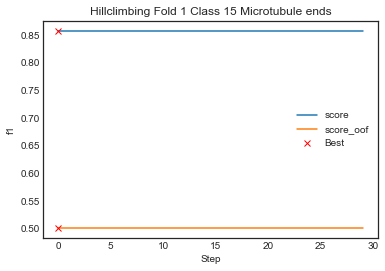

   step  midx     score  score_oof      mod      f1_0
0     0     0  0.857143        0.5  air_g68  0.857143

      weight      mod      f1_0
midx                           
0          1  air_g68  0.857143


hillclimbing f1 fold 1 class 16 Cytokinetic bridge

model 0 f1 0.4655 0.919 0.4845 0.881 air_g68
model 1 f1 0.3225 0.754 0.3718 0.858 air_h68
model 2 f1 0.3235 0.749 0.3585 0.854 airx_h67
model 3 f1 0.3190 0.845 0.2579 0.913 cbam_h67
model 4 f1 0.4404 0.945 0.3553 0.969 iv3_g11
model 5 f1 0.3189 0.957 0.2917 0.906 iv3_h11
model 6 f1 0.4759 0.949 0.4916 0.921 preresnet_g67
model 7 f1 0.3894 0.846 0.3558 0.901 preresnet_h67
model 8 f1 0.4974 0.616 0.4642 0.862 se_resnext_g30
model 9 f1 0.3885 0.616 0.3261 0.733 se_resnext_h30
0  train 0.4974  val 0.4642*   se_resnext_g30
1  train 0.5220  val 0.4863*   preresnet_g67
2  train 0.5333  val 0.4915*   se_resnext_g30
3  train 0.5337  val 0.4862    se_resnext_g30
4  train 0.5362  val 0.4780    iv3_g11
    try dropping 8 se_resnext_g30 0.5238 

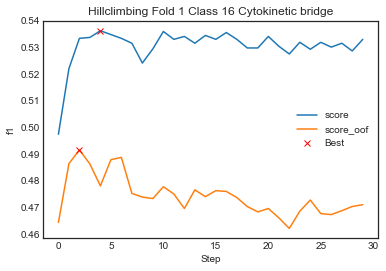

   step  midx     score  score_oof             mod      f1_0
0     0     8  0.497354   0.464223  se_resnext_g30  0.497354
1     1     6  0.521978   0.486312   preresnet_g67  0.475904
2     2     8  0.533333   0.491468  se_resnext_g30  0.497354

      weight             mod      f1_0
midx                                  
6          1   preresnet_g67  0.475904
8          2  se_resnext_g30  0.497354


hillclimbing f1 fold 1 class 17 Mitotic spindle

model 0 f1 0.5081 0.836 0.4922 0.866 air_g68
model 1 f1 0.3516 0.962 0.4300 0.951 air_h68
model 2 f1 0.2718 0.927 0.4329 0.813 airx_h67
model 3 f1 0.4375 0.952 0.4015 0.854 cbam_h67
model 4 f1 0.4524 0.983 0.4281 0.978 iv3_g11
model 5 f1 0.4560 0.969 0.4390 0.952 iv3_h11
model 6 f1 0.4948 0.903 0.4542 0.889 preresnet_g67
model 7 f1 0.4364 0.920 0.3894 0.834 preresnet_h67
model 8 f1 0.4821 0.624 0.5000 0.411 se_resnext_g30
model 9 f1 0.4093 0.757 0.3986 0.616 se_resnext_h30
0  train 0.5081  val 0.4922*   air_g68
1  train 0.5185  val 0.4873    

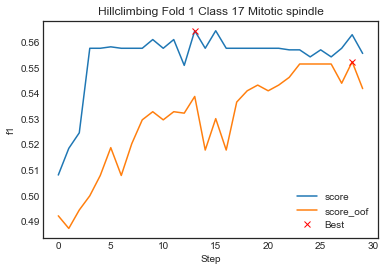

    step  midx     score  score_oof             mod      f1_0
0      0     0  0.508108   0.492188         air_g68  0.508108
1      1     6  0.518519   0.487273   preresnet_g67  0.494845
2      2     3  0.524590   0.494465        cbam_h67  0.437500
3      3     8  0.557576   0.500000  se_resnext_g30  0.482051
4      4     4  0.557576   0.507937         iv3_g11  0.452381
5      5     4  0.558140   0.518797         iv3_g11  0.452381
6      6     6  0.557576   0.507937   preresnet_g67  0.494845
7      7     4  0.557576   0.520325         iv3_g11  0.452381
8      8     4  0.557576   0.529644         iv3_g11  0.452381
9      9     4  0.560976   0.532819         iv3_g11  0.452381
10    10     4  0.557576   0.529644         iv3_g11  0.452381
11    11     4  0.560976   0.532819         iv3_g11  0.452381
12    12     4  0.550898   0.532258         iv3_g11  0.452381
13    13     4  0.564417   0.538776         iv3_g11  0.452381
14    14     4  0.557576   0.517857         iv3_g11  0.452381
15    15

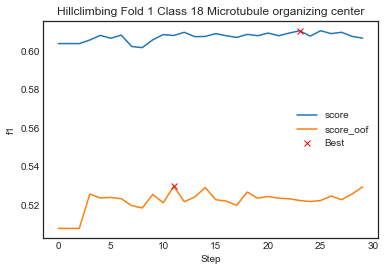

    step  midx     score  score_oof            mod      f1_0
0      0     0  0.603645   0.507993        air_g68  0.603645
1      1     0  0.603645   0.507993        air_g68  0.603645
2      2     0  0.603645   0.507993        air_g68  0.603645
3      3     6  0.605483   0.525739  preresnet_g67  0.585000
4      4     0  0.607889   0.523757        air_g68  0.603645
5      5     0  0.606407   0.524017        air_g68  0.603645
6      6     2  0.608018   0.523364       airx_h67  0.492197
7      7     6  0.602128   0.519751  preresnet_g67  0.585000
8      8     0  0.601554   0.518591        air_g68  0.603645
9      9     0  0.605587   0.525573        air_g68  0.603645
10    10     0  0.608305   0.521277        air_g68  0.603645
11    11     4  0.607821   0.529837        iv3_g11  0.515038

      weight            mod      f1_0
midx                                 
0          8        air_g68  0.603645
2          1       airx_h67  0.492197
4          1        iv3_g11  0.515038
6          2  pr

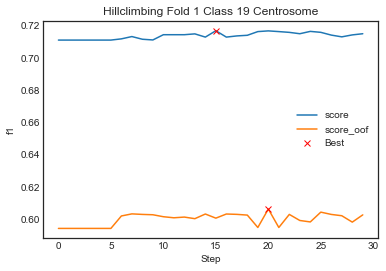

    step  midx     score  score_oof             mod      f1_0
0      0     0  0.710952   0.594177         air_g68  0.710952
1      1     0  0.710952   0.594177         air_g68  0.710952
2      2     0  0.710952   0.594177         air_g68  0.710952
3      3     0  0.710952   0.594177         air_g68  0.710952
4      4     0  0.710952   0.594177         air_g68  0.710952
5      5     0  0.710952   0.594177         air_g68  0.710952
6      6     1  0.711712   0.601898         air_h68  0.675910
7      7     0  0.713137   0.603192         air_g68  0.710952
8      8     0  0.711470   0.602860         air_g68  0.710952
9      9     0  0.711033   0.602649         air_g68  0.710952
10    10     0  0.714286   0.601429         air_g68  0.710952
11    11     0  0.714286   0.600769         air_g68  0.710952
12    12     6  0.714286   0.601207   preresnet_g67  0.683522
13    13     0  0.714801   0.600218         air_g68  0.710952
14    14     8  0.712803   0.603104  se_resnext_g30  0.644717
15    15

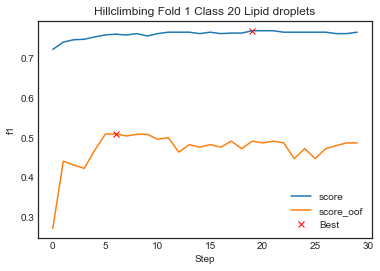

   step  midx     score  score_oof             mod      f1_0
0     0     7  0.721154   0.272727   preresnet_h67  0.721154
1     1     9  0.739336   0.440945  se_resnext_h30  0.709677
2     2     3  0.745283   0.431373        cbam_h67  0.675926
3     3     5  0.746411   0.423077         iv3_h11  0.595238
4     4     8  0.752294   0.468750  se_resnext_g30  0.676923
5     5     2  0.757282   0.508772        airx_h67  0.614108
6     6     2  0.759259   0.509434        airx_h67  0.614108

      weight             mod      f1_0
midx                                  
2          2        airx_h67  0.614108
3          1        cbam_h67  0.675926
5          1         iv3_h11  0.595238
7          1   preresnet_h67  0.721154
8          1  se_resnext_g30  0.676923
9          1  se_resnext_h30  0.709677


hillclimbing f1 fold 1 class 21 Plasma membrane

model 0 f1 0.7239 0.849 0.6420 0.739 air_g68
model 1 f1 0.7272 0.759 0.6676 0.701 air_h68
model 2 f1 0.6986 0.810 0.6391 0.761 airx_h67
model 3 f1 0

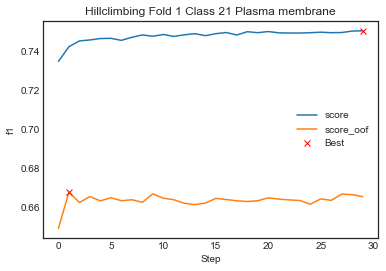

   step  midx     score  score_oof             mod      f1_0
0     0     9  0.734799   0.648885  se_resnext_h30  0.734799
1     1     1  0.742364   0.667482         air_h68  0.727154

      weight             mod      f1_0
midx                                  
1          1         air_h68  0.727154
9          1  se_resnext_h30  0.734799


hillclimbing f1 fold 1 class 22 Cell junctions

model 0 f1 0.6544 0.890 0.6159 0.853 air_g68
model 1 f1 0.6364 0.856 0.5937 0.786 air_h68
model 2 f1 0.6013 0.761 0.5847 0.741 airx_h67
model 3 f1 0.6063 0.770 0.5717 0.758 cbam_h67
model 4 f1 0.6307 0.984 0.5802 0.987 iv3_g11
model 5 f1 0.5982 0.925 0.5549 0.906 iv3_h11
model 6 f1 0.6551 0.864 0.6002 0.896 preresnet_g67
model 7 f1 0.6361 0.881 0.5895 0.837 preresnet_h67
model 8 f1 0.6713 0.757 0.6125 0.810 se_resnext_g30
model 9 f1 0.6565 0.808 0.6101 0.746 se_resnext_h30
0  train 0.6713  val 0.6125*   se_resnext_g30
1  train 0.6912  val 0.6246*   se_resnext_h30
2  train 0.6947  val 0.6328*   preresnet

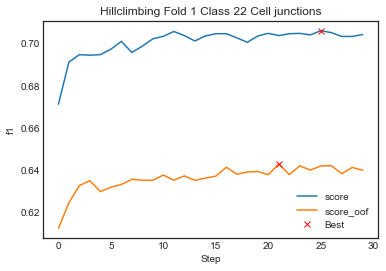

    step  midx     score  score_oof             mod      f1_0
0      0     8  0.671271   0.612472  se_resnext_g30  0.671271
1      1     9  0.691244   0.624599  se_resnext_h30  0.656535
2      2     6  0.694737   0.632757   preresnet_g67  0.655080
3      3     9  0.694486   0.635052  se_resnext_h30  0.656535
4      4     9  0.694737   0.629905  se_resnext_h30  0.656535
5      5     8  0.697329   0.631922  se_resnext_g30  0.671271
6      6     1  0.701031   0.633299         air_h68  0.636364
7      7     6  0.695783   0.635707   preresnet_g67  0.655080
8      8     8  0.698795   0.635294  se_resnext_g30  0.671271
9      9     9  0.702222   0.635246  se_resnext_h30  0.656535
10    10     0  0.703428   0.637744         air_g68  0.654402
11    11     4  0.705706   0.635294         iv3_g11  0.630657
12    12     4  0.703759   0.637339         iv3_g11  0.630657
13    13     8  0.701220   0.635220  se_resnext_g30  0.671271
14    14     9  0.703593   0.636269  se_resnext_h30  0.656535
15    15

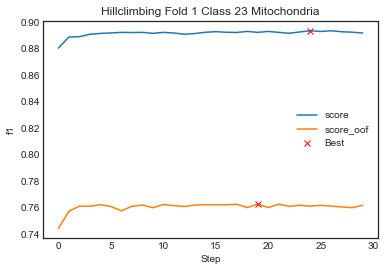

    step  midx     score  score_oof             mod      f1_0
0      0     9  0.880116   0.744243  se_resnext_h30  0.880116
1      1     0  0.888437   0.757161         air_g68  0.879539
2      2     9  0.888695   0.761047  se_resnext_h30  0.880116
3      3     8  0.890549   0.760971  se_resnext_g30  0.877254
4      4     6  0.891156   0.762107   preresnet_g67  0.871810
5      5     9  0.891504   0.760741  se_resnext_h30  0.880116
6      6     9  0.891962   0.757526  se_resnext_h30  0.880116
7      7     0  0.891830   0.760915         air_g68  0.879539
8      8     4  0.891962   0.761865         iv3_g11  0.872589
9      9     1  0.891204   0.759848         air_h68  0.871910
10    10     8  0.891954   0.762223  se_resnext_g30  0.877254
11    11     9  0.891462   0.761396  se_resnext_h30  0.880116
12    12     9  0.890562   0.760771  se_resnext_h30  0.880116
13    13     0  0.891066   0.761905         air_g68  0.879539
14    14     8  0.892024   0.762024  se_resnext_g30  0.877254
15    15

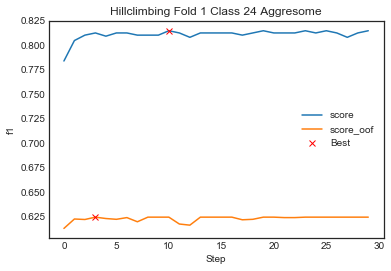

   step  midx     score  score_oof      mod      f1_0
0     0     0  0.783505   0.612613  air_g68  0.783505
1     1     4  0.804408   0.622222  iv3_g11  0.700935
2     2     0  0.809917   0.621723  air_g68  0.783505
3     3     0  0.812155   0.624113  air_g68  0.783505

      weight      mod      f1_0
midx                           
0          3  air_g68  0.783505
4          1  iv3_g11  0.700935


hillclimbing f1 fold 1 class 25 Cytosol

model 0 f1 0.6855 0.851 0.6998 0.767 air_g68
model 1 f1 0.6968 0.810 0.7064 0.819 air_h68
model 2 f1 0.6856 0.847 0.6923 0.753 airx_h67
model 3 f1 0.6915 0.775 0.7006 0.795 cbam_h67
model 4 f1 0.6873 0.911 0.6943 0.913 iv3_g11
model 5 f1 0.6843 0.831 0.6870 0.802 iv3_h11
model 6 f1 0.6936 0.848 0.6969 0.782 preresnet_g67
model 7 f1 0.7027 0.858 0.6997 0.807 preresnet_h67
model 8 f1 0.6881 0.720 0.6900 0.761 se_resnext_g30
model 9 f1 0.7007 0.691 0.6977 0.755 se_resnext_h30
0  train 0.7027  val 0.6997*   preresnet_h67
1  train 0.7060  val 0.7026*   se_r

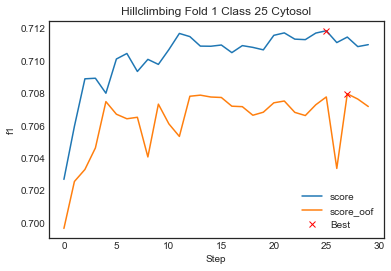

    step  midx     score  score_oof             mod      f1_0
0      0     7  0.702684   0.699655   preresnet_h67  0.702684
1      1     9  0.705962   0.702554  se_resnext_h30  0.700732
2      2     4  0.708895   0.703295         iv3_g11  0.687251
3      3     7  0.708931   0.704626   preresnet_h67  0.702684
4      4     1  0.708006   0.707486         air_h68  0.696774
5      5     6  0.710118   0.706709   preresnet_g67  0.693571
6      6     2  0.710460   0.706427        airx_h67  0.685624
7      7     7  0.709350   0.706520   preresnet_h67  0.702684
8      8     8  0.710097   0.704069  se_resnext_g30  0.688111
9      9     1  0.709787   0.707331         air_h68  0.696774
10    10     7  0.710699   0.706113   preresnet_h67  0.702684
11    11     7  0.711698   0.705337   preresnet_h67  0.702684
12    12     7  0.711503   0.707818   preresnet_h67  0.702684
13    13     7  0.710915   0.707886   preresnet_h67  0.702684
14    14     7  0.710907   0.707770   preresnet_h67  0.702684
15    15

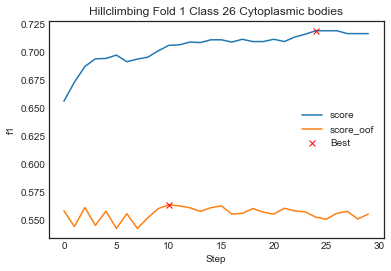

    step  midx     score  score_oof             mod      f1_0
0      0     1  0.656151   0.558511         air_h68  0.656151
1      1     0  0.673016   0.544444         air_g68  0.642045
2      2     6  0.687075   0.561404   preresnet_g67  0.632836
3      3     6  0.693878   0.545455   preresnet_g67  0.632836
4      4     0  0.694158   0.558140         air_g68  0.642045
5      5     6  0.697183   0.542773   preresnet_g67  0.632836
6      6     0  0.691275   0.555874         air_g68  0.642045
7      7     6  0.693603   0.542773   preresnet_g67  0.632836
8      8     9  0.695364   0.552326  se_resnext_h30  0.582524
9      9     4  0.701031   0.560472         iv3_g11  0.482587
10    10     4  0.705882   0.563798         iv3_g11  0.482587

      weight             mod      f1_0
midx                                  
0          3         air_g68  0.642045
1          1         air_h68  0.656151
4          2         iv3_g11  0.482587
6          4   preresnet_g67  0.632836
9          1  se_resn

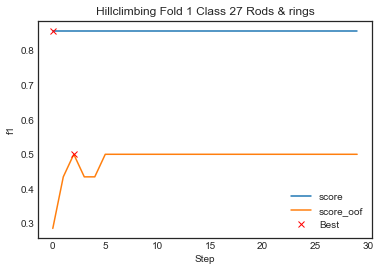

   step  midx     score  score_oof      mod      f1_0
0     0     1  0.857143   0.285714  air_h68  0.857143
1     1     0  0.857143   0.434783  air_g68  0.600000
2     2     0  0.857143   0.500000  air_g68  0.600000

      weight      mod      f1_0
midx                           
0          2  air_g68  0.600000
1          1  air_h68  0.857143

overall mean f1 0.7875713567169914  mean cut 0.8011021787705861   mean steps 15.178571428571429
mean f1 0.7027154262111942  mean cut 0.7493705548020604   mean steps 13.285714285714286


<Figure size 432x288 with 0 Axes>

In [70]:
# oof = small

# hillclimbing
# vp = oof.copy()
# offset = 5
# nm = vp.shape[1] - offset
nr = vp.shape[0]
y = np.array([y for y in vp.y])
# y = np.array(list(vp['masks'].values))

yt = y[folds != fold]
yf = y[folds == fold]

nstep = 30
back_check = 5
back_num = 2

step0fix = -1
# step0fix = 5
step1fix = -1

intercept = 0
metric = 'f1'
# metric = 'iou'

# threshold = 0.
# threshold = 0.36
threshold = 0.49
# threshold = 0.5
# print('using ' + metric + ' threshold',threshold)
# print('optimizing ' + metric + ' by hillclimbing on fold ' + str(fold))

# metric = "mcc"
# metric = "corr"
# metric = "rmse"
# metric = "mse"
# metric = "mae"
# metric = "winsorized_mae"
# metric = "auc"

cut_mets = ['mcc','f1']

num_classes = 28
th = np.zeros(num_classes)
threshold_best = threshold


rez_all = []
tb_all = []

bestEnsemble_all = []
bestStep_all = []
bestScore_all = []
bestCut_all = []

bestEnsemble_oof_all = []
bestStep_oof_all = []
bestScore_oof_all = []
bestCut_oof_all = []

for c in range(num_classes):
    
    print()
    print()
    print('hillclimbing',metric,'fold',fold,'class',c,LABEL_MAP[c])
    print()

    rez = pd.DataFrame({'step':np.zeros(nstep).astype(int),'midx':np.zeros(nstep).astype(int),
                        'score':np.zeros(nstep),'score_oof':np.zeros(nstep)})
    currEnsemble = 0 * np.array(list(vp.iloc[:,offset].values))
    currMods = []
    size = 0

    # maximizing
    bestScore = -9999999
    bestScore_oof = -9999999
    single = pd.DataFrame({'mod':np.repeat("",nm)})
    start = 0
    for step in range(start,nstep):
        single[metric+'_'+str(step)] = np.nan

    single_oof = single.copy()

    for step in range(start,nstep):
        
        currIndex = 0
        currScore = -9999999
        currScore_oof = -9999999

        # forward selection
        for i in range(nm):

            mn = vp.columns[i+offset]

            tv = np.array(list(vp.iloc[:,offset+i].values))

            # mean-center
    #         tv = tv - np.mean(tv)

            # adjust by model-specific threshold
    #         tv = tv - mthresh[mn]

            # adjust by model-class-specific thresholds
    #         for j in range(tv.shape[1]):
    #             tv[:,j] = tv[:,j] - cthresh[mn][j]

            if np.sum(np.isnan(tv)) > 0: continue

            if size==0:
                tryEnsemble = tv
            else:
                # running mean
                tryEnsemble = (size * currEnsemble + tv)/(size+1)
                # full matrix
                # choose median or mean here
                # tryEnsemble = rowMedians(cbind(currEnsemble,tv))
                # tryEnsemble = rowMeans(cbind(currEnsemble,tv))
                # quantiles are a lot slower
                # tryEnsemble = rowQuantiles(cbind(currEnsemble,tv),probs=0.6)

            if metric=="f1":
    #             # estimate new class-specific thresholds by least squares, very slow
    #             th = fit_val(tryEnsemble,y)
    #             th[th<0.1] = 0.1
    #             tryScore = f1_score(y, np.int32(tryEnsemble > th),
    #                                 average='macro')

                # estimate new class-specific thresholds by line search, slow
                et = tryEnsemble[folds != fold]
                cutt = fit_val1(et[:,c],yt[:,c])
                tryScore = f1_score(yt[:,c], np.int32(et[:,c] > cutt))

                ef = tryEnsemble[folds == fold]
                cutf = fit_val1(ef[:,c],yf[:,c])
                tryScore_oof = f1_score(yf[:,c], np.int32(ef[:,c] > cutf))

    #             # estimate new class-specific thresholds to match proportions, medium
    #             for j in range(num_classes):
    #                 th[j] = fit_val2(tryEnsemble[:,j],y[:,j])
    #             tryScore = f1_score(y, np.int32(tryEnsemble > th),
    #                                 average='macro')

    #             # fixed threshold, fast
    #             tryScore = f1_score(y, np.int32(tryEnsemble > threshold),
    #                                 average='macro')

#                 if step > 0: print('    try',i,mn,"%6.4f" % tryScore,"%6.4f" % tryScore_oof)
            elif metric=="iou":
                tryScore = iou_metric_batch(y, np.int32(tryEnsemble > threshold),
                                            pred_eps=pred_eps)
                if step > 0: print('    try',i,mn,"%6.4f" % tryScore)
            elif metric=="mse":
                tryScore = -mse(y,tryEnsemble)
            elif metric=="mae": 
                tryScore = -mae(y,tryEnsemble)
            elif metric=="winsorized_mae": 
                tryScore = -winsorized_mae(y,tryEnsemble+intercept)
            elif metric=="rmse":
                tryScore = -rmse(y,tryEnsemble)
            elif metric=="corr":
                tryScore = cor(y,tryEnsemble)
            elif metric=="mcc":
                opt = eval_mcc3(y,tryEnsemble,cut=T)
                tryScore = opt[1]
                cut = opt[2]
                # opt = optimize(mcc,c(0.1,0.3),tryEnsemble,vp$y,maximum=T)
                # tryScore = opt$objective
            elif metric=="logloss":
                # tryScore = -logLoss(vp$y,tryEnsemble,)
                tryScore = -eval_logloss2(tryEnsemble,y)
            elif metric=="auc":
                tryScore = auc2(y,tryEnsemble)
            elif metric=="auprc":
                tryScore = auprc(tryEnsemble, y)
                # tryScore = pr.curve(scores.class0 = tryEnsemble, weights.class0 = vp$y)$auc.integral
                # tryScore = pr.curve(scores.class0 = tryEnsemble, weights.class0 = vp$y)$auc.davis.goadrich
            elif metric=="aurocpr":
                auroc = auc(y,tryEnsemble)
                # auprc = pr.curve(scores.class0 = tryEnsemble, weights.class0 = vp$y)$auc.integral
                tryScore = (auroc + auprc)/2
            elif metric=="sqwk":
                tryScore = sqwk(y,tryEnsemble,1,8)

            ok = 1
            if (step==0) and (step0fix>-1) and (i!=step0fix): ok = 0 
            if (step==1) and (step1fix>-1) and (i!=step1fix): ok = 0 

            if (tryScore > currScore) and (ok==1):
                currIndex = i
                currScore = tryScore
                currScore_oof = tryScore_oof
                if (step==0):
                    saveEnsemble = tv.copy()
                else:
                    # running mean
                    saveEnsemble = tryEnsemble.copy()
                    # save whole matrix
                    # saveEnsemble = np.concatenate((currEnsemble,tv),axis=1)
                if metric in cut_mets: 
                    currCut = cutt
                    currCut_oof = cutf

            # if (step==0) or ((step==1) and (step0fix>-1)) or ((step==2) and (step1fix>-1)):
            if (step==0):
                if metric in cut_mets:
                    print("model",i,metric, "%6.4f %5.3f %6.4f %5.3f" % \
                          (tryScore,cutt,tryScore_oof,cutf), vp.columns[i+offset])
                else:
                    print("model",i,metric,"for",vp.columns[i+offset],"= %6.4f" % tryScore,
                         " oof = %6.4f" % tryScore_oof)

            if step==0:
                single.loc[i,'mod'] = vp.columns[i+offset]  
                single_oof.loc[i,'mod'] = vp.columns[i+offset]  
            single.iloc[i,step+1] = tryScore
            single_oof.iloc[i,step+1] = tryScore_oof
            
        currMods.append(currIndex)
        size += 1
        # print('   ',currMods,size)
        assert size == len(currMods)

        # backwards elimination
        if (step > 0) and (step % back_check) == 0:
            
            for b in range(back_num):
                
                dropped1 = False
                for ixi, i in enumerate(currMods):

                    mn = vp.columns[i+offset]

                    tv = np.array(list(vp.iloc[:,offset+i].values))

                    # mean-center
            #         tv = tv - np.mean(tv)

                    # adjust by model-specific threshold
            #         tv = tv - mthresh[mn]

                    # adjust by model-class-specific thresholds
            #         for j in range(tv.shape[1]):
            #             tv[:,j] = tv[:,j] - cthresh[mn][j]

                    if np.sum(np.isnan(tv)) > 0: continue

                    if size==0:
                        tryEnsemble = tv
                    else:
                        # running mean
                        tryEnsemble = (size * currEnsemble - tv)/(size-1)
                        # full matrix
                        # choose median or mean here
                        # tryEnsemble = rowMedians(cbind(currEnsemble,tv))
                        # tryEnsemble = rowMeans(cbind(currEnsemble,tv))
                        # quantiles are a lot slower
                        # tryEnsemble = rowQuantiles(cbind(currEnsemble,tv),probs=0.6)

                    if metric=="f1":
            #             # estimate new class-specific thresholds by least squares, very slow
            #             th = fit_val(tryEnsemble,y)
            #             th[th<0.1] = 0.1
            #             tryScore = f1_score(y, np.int32(tryEnsemble > th),
            #                                 average='macro')

                        # estimate new class-specific thresholds by line search, slow
                        et = tryEnsemble[folds != fold]
                        cutt = fit_val1(et[:,c],yt[:,c])
                        tryScore = f1_score(yt[:,c], np.int32(et[:,c] > cutt))

                        ef = tryEnsemble[folds == fold]
                        cutf = fit_val1(ef[:,c],yf[:,c])
                        tryScore_oof = f1_score(yf[:,c], np.int32(ef[:,c] > cutf))

            #             # estimate new class-specific thresholds to match proportions, medium
            #             for j in range(num_classes):
            #                 th[j] = fit_val2(tryEnsemble[:,j],y[:,j])
            #             tryScore = f1_score(y, np.int32(tryEnsemble > th),
            #                                 average='macro')

            #             # fixed threshold, fast
            #             tryScore = f1_score(y, np.int32(tryEnsemble > threshold),
            #                                 average='macro')

                        if step > 0: print('    try dropping',i,mn,"%6.4f" % tryScore,"%6.4f" % tryScore_oof)
                    elif metric=="iou":
                        tryScore = iou_metric_batch(y, np.int32(tryEnsemble > threshold),
                                                    pred_eps=pred_eps)
                        if step > 0: print('    try',i,mn,"%6.4f" % tryScore)
                    elif metric=="mse":
                        tryScore = -mse(y,tryEnsemble)
                    elif metric=="mae": 
                        tryScore = -mae(y,tryEnsemble)
                    elif metric=="winsorized_mae": 
                        tryScore = -winsorized_mae(y,tryEnsemble+intercept)
                    elif metric=="rmse":
                        tryScore = -rmse(y,tryEnsemble)
                    elif metric=="corr":
                        tryScore = cor(y,tryEnsemble)
                    elif metric=="mcc":
                        opt = eval_mcc3(y,tryEnsemble,cut=T)
                        tryScore = opt[1]
                        cut = opt[2]
                        # opt = optimize(mcc,c(0.1,0.3),tryEnsemble,vp$y,maximum=T)
                        # tryScore = opt$objective
                    elif metric=="logloss":
                        # tryScore = -logLoss(vp$y,tryEnsemble,)
                        tryScore = -eval_logloss2(tryEnsemble,y)
                    elif metric=="auc":
                        tryScore = auc2(y,tryEnsemble)
                    elif metric=="auprc":
                        tryScore = auprc(tryEnsemble, y)
                        # tryScore = pr.curve(scores.class0 = tryEnsemble, weights.class0 = vp$y)$auc.integral
                        # tryScore = pr.curve(scores.class0 = tryEnsemble, weights.class0 = vp$y)$auc.davis.goadrich
                    elif metric=="aurocpr":
                        auroc = auc(y,tryEnsemble)
                        # auprc = pr.curve(scores.class0 = tryEnsemble, weights.class0 = vp$y)$auc.integral
                        tryScore = (auroc + auprc)/2
                    elif metric=="sqwk":
                        tryScore = sqwk(y,tryEnsemble,1,8)

                    ok = 1
                    if (step==0) and (step0fix>-1) and (i!=step0fix): ok = 0 
                    if (step==1) and (step1fix>-1) and (i!=step1fix): ok = 0 

                    if (tryScore > currScore) and (ok==1):
                        currIxi = ixi
                        currScore = tryScore
                        currScore_oof = tryScore_oof
                        if (step==0):
                            saveEnsemble = tv.copy()
                        else:
                            # running mean
                            saveEnsemble = tryEnsemble.copy()
                            # save whole matrix
                            # saveEnsemble = np.concatenate((currEnsemble,tv),axis=1)
                        if metric in cut_mets: 
                            currCut = cutt
                            currCut_oof = cutf
                        dropped1 = True

                # adjust model list or break out of loop if nothing dropped
                if dropped1: 
                    size -= 1
                    di = currMods[currIxi]
                    print('    dropping',di,vp.columns[di+offset])
                    del currMods[currIxi]
                    assert size == len(currMods)
                else:
                    break


        currEnsemble = saveEnsemble.copy()
        if currScore > bestScore:
            bestScore = currScore
            bestStep = step
            bestEnsemble = currEnsemble.copy()
            if metric in cut_mets: 
                bestCut = currCut
        if currScore_oof > bestScore_oof:
            bestScore_oof = currScore_oof
            bestStep_oof = step
            bestEnsemble_oof = currEnsemble.copy()
            if metric in cut_mets: 
                bestCut_oof = currCut_oof
            star = '*'
        else:
            star = ' '

        if metric=="mcc":
            print("step =",step,"  index =",currIndex,"  name =", vp.columns[currIndex+offset],"  ",
                metric,"= %6.4f" % currScore,"  cut =",currCut)
        else:
            print(step," train %6.4f" % currScore,
                  " val %6.4f%s" % (currScore_oof,star),
                  " ",vp.columns[currIndex+offset])

        rez.iloc[step,0] = step
        rez.iloc[step,1] = currIndex
        rez.iloc[step,2] = currScore
        rez.iloc[step,3] = currScore_oof

    if (metric=="mcc"):
        print("best step =",bestStep,"  best",metric,"=",bestScore,"  best cut =",bestCut)
    else:
        print("best step =",bestStep,"  best",metric,"=",bestScore)
        print("best step oof =",bestStep_oof,"  best",metric,"=",bestScore_oof)

    rez0 = rez.copy()

    # tb = table(rez$index[1:bestStep])
    # names(tb) = names(vp)[(offset+1):ncol(vp)][as.integer(names(table(rez$index[1:bestStep])))]

    # if (intercept!=0) {
    #   tb["Intercept"] = intercept
    # }

    # print(tb[order(-tb)])
    # print(single[order(-single[,2]),][1:min(nrow(single),40),])

    # plot hillclimbing
    print('')
    plt.plot(rez0.step, rez0.score)
    plt.plot(rez0.step, rez0.score_oof)
    plt.plot(bestStep, bestScore, "xr", label="Best")
    plt.plot(bestStep_oof, bestScore_oof, "xr")
    plt.xlabel("Step")
    plt.ylabel(metric)
#     plt.title("Hillclimbing ({}, {})".format(bestStep, bestScore))
    plt.title("Hillclimbing Fold %d Class %d %s" % (fold,c,LABEL_MAP[c]))
    plt.legend()
    plt.show()
    plt.gcf().clear()
    
    # display the weights
    rez = rez.iloc[:(bestStep_oof+1)]
    # print(rez)

    single0 = single.iloc[:,:2]

    rez['midx'] = rez['midx'].astype(int)
    rez = rez.join(single0,how='left',on='midx')
    print(rez)
    print('')

    rez['weight'] = 1
    tb = rez.loc[:,['midx','weight']].groupby('midx').count()
    # print(tb)
    # print(single)

    tb = tb.join(single0,how='left')
    print(tb)
    
    rez_all.append(rez)
    tb_all.append(tb)
    bestEnsemble_all.append(bestEnsemble)
    bestStep_all.append(bestStep)
    bestScore_all.append(bestScore)
    bestCut_all.append(bestCut)
    bestEnsemble_oof_all.append(bestEnsemble_oof)
    bestStep_oof_all.append(bestStep_oof)
    bestScore_oof_all.append(bestScore_oof)
    bestCut_oof_all.append(bestCut_oof)

print()
print('overall mean f1',np.mean(bestScore_all),' mean cut',np.mean(bestCut_all),
      '  mean steps',np.mean(bestStep_all))  

print('mean f1',np.mean(bestScore_oof_all),' mean cut',np.mean(bestCut_oof_all),
      '  mean steps',np.mean(bestStep_oof_all))

In [71]:
print('mean f1',np.mean(bestScore_oof_all),' mean cut',np.mean(bestCut_oof_all),
      '  mean steps',np.mean(bestStep_oof_all))

mean f1 0.7027154262111942  mean cut 0.7493705548020604   mean steps 13.285714285714286


In [72]:
# tb_all

In [73]:
# save weights and thresholds
print('')
os.makedirs('weights',exist_ok=True)
fname = 'weights/'+mname+'_'+str(fold)+'.pkl'
pickle.dump(tb_all,open(fname,'wb'))
print(fname)

print('')
os.makedirs('thresholds',exist_ok=True)
fname = 'thresholds/'+mname+'_'+str(fold)+'.pkl'
pickle.dump(bestCut_all,open(fname,'wb'))
print(fname)


weights/hill_g100_1.pkl

thresholds/hill_g100_1.pkl


In [74]:
for i in range(28):
    tb_all[i]['class'] = i
tba = pd.concat(tb_all).reset_index()
print(tba.shape)

(141, 5)


In [75]:
tba.head()

midx  weight            mod      f1_0  class
0     0       1        air_g68  0.698776      0
1     3       3       cbam_h67  0.684872      0
2     4       1        iv3_g11  0.684858      0
3     6       2  preresnet_g67  0.682496      0
4     7       1  preresnet_h67  0.693933      0

In [76]:
# show most popular models
tbag = tba.groupby('mod')
ws = pd.DataFrame(tbag['weight'].sum())
ws.columns = ['ws']
ws.sort_values(['ws'],ascending=False,inplace=True)
print(ws)

                ws
mod               
air_g68         75
iv3_g11         74
se_resnext_h30  59
preresnet_g67   42
se_resnext_g30  36
air_h68         31
cbam_h67        25
preresnet_h67   25
iv3_h11         17
airx_h67        16


/home/sasrdw/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


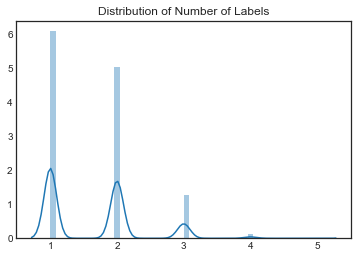

<Figure size 432x288 with 0 Axes>

In [77]:
ysum = y.sum(axis=1)
sns.distplot(np.array(ysum))
plt.title("Distribution of Number of Labels")
plt.show()
plt.gcf().clear()

In [78]:
bestens = np.zeros_like(y)
bestens_oof = np.zeros_like(y)
for j in range(num_classes):
    bestens[:,j] = bestEnsemble_all[j][:,j]
    bestens_oof[:,j] = bestEnsemble_oof_all[j][:,j]
    
bet = bestens[folds!=fold]
bev = bestens_oof[folds==fold]
yt = y[folds!=fold]
yv = y[folds==fold]
print(bet.shape,yt.shape,bev.shape,yv.shape)

(11545, 28) (11545, 28) (19527, 28) (19527, 28)


In [79]:
# breakdown by number of labels
st = np.zeros(num_classes)
sv = np.zeros(num_classes)
st1 = np.zeros(num_classes)
sv1 = np.zeros(num_classes)
st2 = np.zeros(num_classes)
sv2 = np.zeros(num_classes)
st3 = np.zeros(num_classes)
sv3 = np.zeros(num_classes)

yts1 = yt.sum(axis=1)==1
yvs1 = yv.sum(axis=1)==1

yts2 = yt.sum(axis=1)==2
yvs2 = yv.sum(axis=1)==2

yts3 = yt.sum(axis=1)>=3
yvs3 = yv.sum(axis=1)>=3

for j in range(num_classes):
    cut = fit_val1(bet[:,j],yt[:,j])
    st[j] = f1_score(yt[:,j],np.int32(bet[:,j] > cut))
    cut = fit_val1(bev[:,j],yv[:,j])
    sv[j] = f1_score(yv[:,j],np.int32(bev[:,j] > cut))
    
    s = yts1
    cut = fit_val1(bet[s,j],yt[s,j])
    st1[j] = f1_score(yt[s,j],np.int32(bet[s,j] > cut))
    s = yvs1
    cut = fit_val1(bev[s,j],yv[s,j])
    sv1[j] = f1_score(yv[s,j],np.int32(bev[s,j] > cut))
    
    s = yts2
    cut = fit_val1(bet[s,j],yt[s,j])
    st2[j] = f1_score(yt[s,j],np.int32(bet[s,j] > cut))
    s = yvs2
    cut = fit_val1(bev[s,j],yv[s,j])
    sv2[j] = f1_score(yv[s,j],np.int32(bev[s,j] > cut))
    
    s = yts3
    cut = fit_val1(bet[s,j],yt[s,j])
    st3[j] = f1_score(yt[s,j],np.int32(bet[s,j] > cut))
    s = yvs3
    cut = fit_val1(bev[s,j],yv[s,j])
    sv3[j] = f1_score(yv[s,j],np.int32(bev[s,j] > cut))
      
print(st.mean(),sv.mean())
print(st1.mean(),sv1.mean())
print(st2.mean(),sv2.mean())
print(st3.mean(),sv3.mean())

0.7875713567169914 0.7026911654612352
0.6870866030878376 0.6112399007162362
0.7399874784968258 0.6132357696020204
0.7388234319172298 0.7001924094099822


In [80]:
# mask1 = [all(tup) for tup in zip(a, b, c)]

/home/sasrdw/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


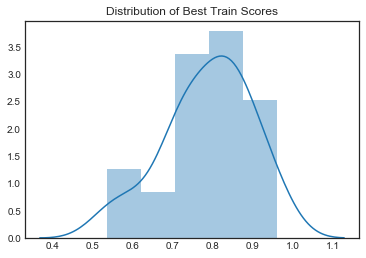

/home/sasrdw/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


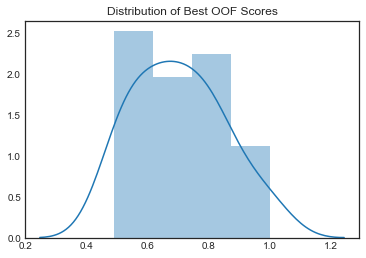

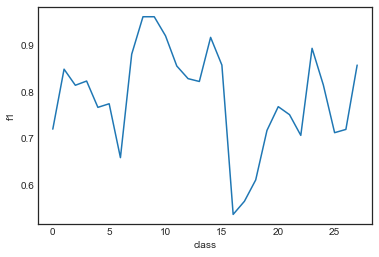

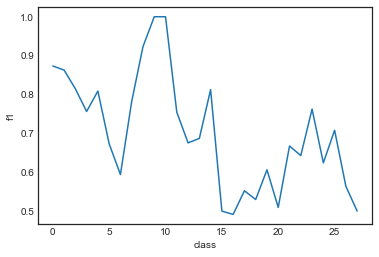

<Figure size 432x288 with 0 Axes>

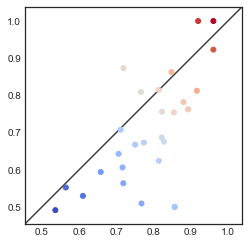

0 0.7194557823129253 0.8733413751507841
1 0.8483516483516484 0.8627450980392157
2 0.8137629710540688 0.81491344873502
3 0.8228571428571428 0.7563527653213753
4 0.7662835249042146 0.8088235294117647
5 0.7740292807129218 0.6731371321227301
6 0.6582278481012659 0.5940366972477065
7 0.8805327066196632 0.7820732124529594
8 0.961038961038961 0.9230769230769231
9 0.9610389610389611 1.0
10 0.92 1.0
11 0.8551307847082495 0.7544483985765125
12 0.828006088280061 0.6755555555555556
13 0.821917808219178 0.6869565217391305
14 0.9167204648160103 0.8125
15 0.8571428571428571 0.5
16 0.5361930294906165 0.49146757679180886
17 0.5644171779141104 0.5523012552301255
18 0.6102857142857142 0.5298372513562387
19 0.7167420814479638 0.6061946902654868
20 0.7677725118483414 0.509433962264151
21 0.7505812022583858 0.6674821610601428
22 0.706060606060606 0.642931937172775
23 0.8931759285919953 0.7625418060200668
24 0.814404432132964 0.624113475177305
25 0.711864406779661 0.7079689415610952
26 0.7188612099644128 0.5

<Figure size 432x288 with 0 Axes>

In [81]:
sns.distplot(np.array(bestScore_all))
plt.title("Distribution of Best Train Scores")
plt.show()
plt.gcf().clear()

sns.distplot(np.array(bestScore_oof_all))
plt.title("Distribution of Best OOF Scores")
plt.show()
plt.gcf().clear()

plt.plot(range(num_classes), np.array(bestScore_all))
plt.xlabel("class")
plt.ylabel("f1")
# plt.title(LABEL_MAP[c] + " " + metric + " hillclimbing (%d, %6.4f)" % (bestStep, bestScore))
# plt.legend()
plt.show()
plt.gcf().clear()

plt.plot(range(num_classes), np.array(bestScore_oof_all))
plt.xlabel("class")
plt.ylabel("f1")
# plt.title(LABEL_MAP[c] + " " + metric + " hillclimbing (%d, %6.4f)" % (bestStep, bestScore))
# plt.legend()
plt.show()
plt.gcf().clear()

c = np.array(bestScore_all)**2 + np.array(bestScore_oof_all)**2

fig, ax = plt.subplots()
ax.scatter( np.array(bestScore_all),  np.array(bestScore_oof_all), 
           s=25, c=c, cmap=plt.cm.coolwarm, zorder=10)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()
plt.gcf().clear()

for i in range(num_classes):
    print(i,bestScore_all[i],bestScore_oof_all[i])

/home/sasrdw/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


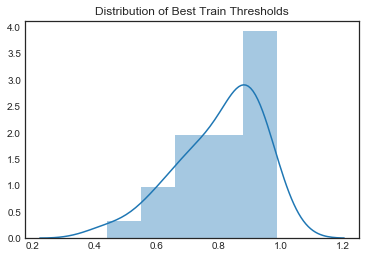

/home/sasrdw/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


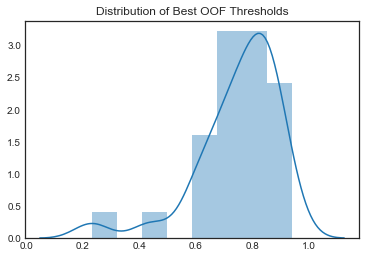

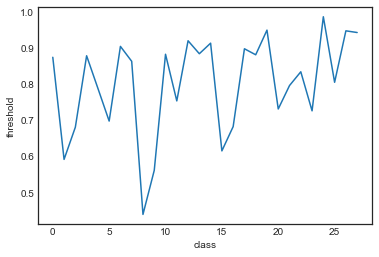

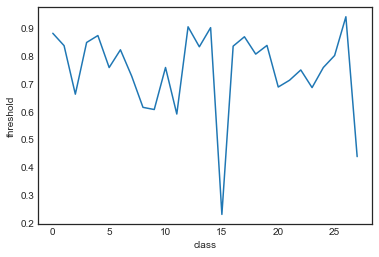

<Figure size 432x288 with 0 Axes>

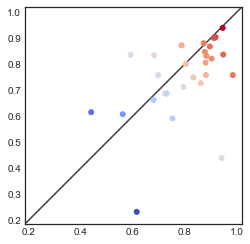

0 0.8742129270021038 0.8814476876614992
1 0.5921490582198718 0.8370687670176489
2 0.6810355242798941 0.6629075292126001
3 0.878408252220844 0.8484359709120425
4 0.7885564773916094 0.8732882073308632
5 0.6980235822961961 0.7584898180863838
6 0.9043032869080794 0.8221690955772751
7 0.863075136469031 0.7274722219090991
8 0.4401945849518623 0.6156774740707043
9 0.5618747073262126 0.6078500821912328
10 0.882553598702479 0.7586576842750771
11 0.7537058631777203 0.5916745898104656
12 0.9198293703857241 0.904666085878667
13 0.8840369239895853 0.8329918636919454
14 0.9131966469405647 0.9016369548112768
15 0.6156776133205051 0.2315049981248381
16 0.6827422058878485 0.8352464208777612
17 0.8977247533765653 0.8689126314485289
18 0.8811155441507776 0.8067182240214754
19 0.9492176732435236 0.8378399824995896
20 0.7314582582175683 0.6885949999485702
21 0.7961428677774005 0.7129106782743456
22 0.834149529619491 0.7498038772438173
23 0.7263082896855643 0.6865048830768647
24 0.986177531726102 0.75865960

<Figure size 432x288 with 0 Axes>

In [82]:
sns.distplot(np.array(bestCut_all))
plt.title("Distribution of Best Train Thresholds")
plt.show()
plt.gcf().clear()

sns.distplot(np.array(bestCut_oof_all))
plt.title("Distribution of Best OOF Thresholds")
plt.show()
plt.gcf().clear()

plt.plot(range(num_classes), np.array(bestCut_all))
plt.xlabel("class")
plt.ylabel("threshold")
# plt.title(LABEL_MAP[c] + " " + metric + " hillclimbing (%d, %6.4f)" % (bestStep, bestScore))
# plt.legend()
plt.show()
plt.gcf().clear()

plt.plot(range(num_classes), np.array(bestCut_oof_all))
plt.xlabel("class")
plt.ylabel("threshold")
# plt.title(LABEL_MAP[c] + " " + metric + " hillclimbing (%d, %6.4f)" % (bestStep, bestScore))
# plt.legend()
plt.show()
plt.gcf().clear()

c = np.array(bestCut_all)**2 + np.array(bestCut_oof_all)**2

fig, ax = plt.subplots()
ax.scatter( np.array(bestCut_all),  np.array(bestCut_oof_all), 
           s=25, c=c, cmap=plt.cm.coolwarm, zorder=10)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()
plt.gcf().clear()

for i in range(num_classes):
    print(i,bestCut_all[i],bestCut_oof_all[i])

In [83]:
bestEnsemble_all0 = bestEnsemble_oof.copy()

In [84]:
# save out-of-fold predictions
nf = np.sum(folds==fold)
print(nf)
ens = np.zeros((nf,num_classes))
for j in range(num_classes):
    ens[:,j] = bestEnsemble_oof_all[j][folds==fold,j]
     
oof_ids = oof.index.values[folds==fold]
poof = ens.copy()
yoof = y[folds==fold]

oof = [oof_ids, poof, yoof]
fname = 'oof/'+mname+'_'+str(fold)+'.pkl'
pickle.dump(oof,open(fname,'wb'))
print(fname)
    
# p = pd.DataFrame(ens)
# p.columns = ['p'+str(i) for i in range(ens.shape[1])]
# yd = pd.DataFrame(y)
# yd.names = ['y'+str(i) for i in range(ens.shape[1])]
# subp = pd.DataFrame({'id':vp.index.values[folds==fold],'data':'oof'})
# subp = pd.concat((subp,yd,p),axis=1)
# print(subp.shape)
# fname = 'oof/' + mname + '_' + str(fold) + '.csv'
# subp.to_csv(fname, index=False)
# print(fname)

19527
oof/hill_g100_1.pkl


In [85]:
pred = ens.copy()
num_classes = x.shape[1]
print(pred.shape,pred.min(),pred.mean(),pred.max(),num_classes)
name_label_dict = LABEL_MAP
th = np.zeros(num_classes)
for i in range(num_classes):
    th[i] = fit_val1(pred[:,i],y[folds==fold,i])
# th[th<0.1] = 0.1
print('Thresholds: ',th)
print('F1 macro: ',f1_score(y[folds==fold], pred>th, average='macro'))
print('F1 micro: ',f1_score(y[folds==fold], pred>th, average='micro'))

(19527, 28) 1.8442622741386128e-08 0.13784911146211432 0.9999376305174944 28
Thresholds:  [0.881 0.837 0.663 0.848 0.873 0.758 0.822 0.727 0.616 0.608 0.759 0.592 0.905 0.833 0.902 0.232 0.835 0.869 0.807 0.838 0.689 0.713 0.75  0.687 0.759 0.802 0.941 0.439]
F1 macro:  0.7027154262111942
F1 micro:  0.7711102922418437



f1_best 0.662333610188733
threshold_best 0.76



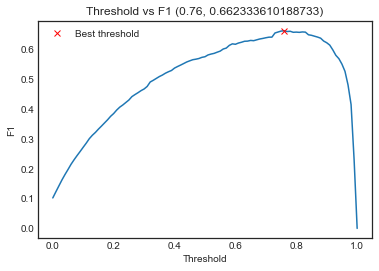

<Figure size 432x288 with 0 Axes>

In [86]:
# grid search for single best threshold
vlsp = pred.copy()

thresholds = np.linspace(0, 1., 101)
scores = np.array([f1_score(yoof, (vlsp > t).astype(int), average='macro') \
                 for t in thresholds])

threshold_best_index = np.argmax(scores)
score_best = scores[threshold_best_index]
threshold_best = thresholds[threshold_best_index]
print('')
print('f1_best',score_best)
print('threshold_best',threshold_best)
print('')

plt.plot(thresholds, scores)
plt.plot(threshold_best, score_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("F1")
plt.title("Threshold vs F1 ({}, {})".format(threshold_best, score_best))
plt.legend()
plt.show()
plt.gcf().clear()

1.8442622741386128e-08 0.13784911146211432 0.9999376305174944 (546756,)


/home/sasrdw/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


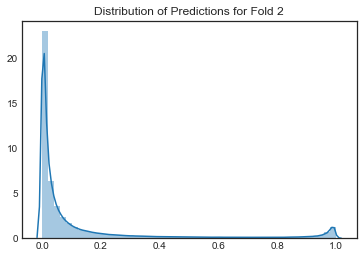

<Figure size 432x288 with 0 Axes>

In [87]:
vf = vlsp.flatten()
print(vf.min(),vf.mean(),vf.max(),vf.shape)
sns.distplot(vf)
plt.title("Distribution of Predictions for Fold " + str(fold+1))
plt.show()
plt.gcf().clear()

In [88]:
# num_rows = x.shape[0]
# c = np.zeros(num_rows)
# for i in range(num_rows):
#     c[i] = np.corrcoef(pred[i],yoof[i])[0,1]
# o = oof.iloc[:,:1]
# o['corr'] = c

# fname = 'corrs'+midx+'_'+str(fold)+'.csv'
# o.to_csv(fname)
# print(fname)

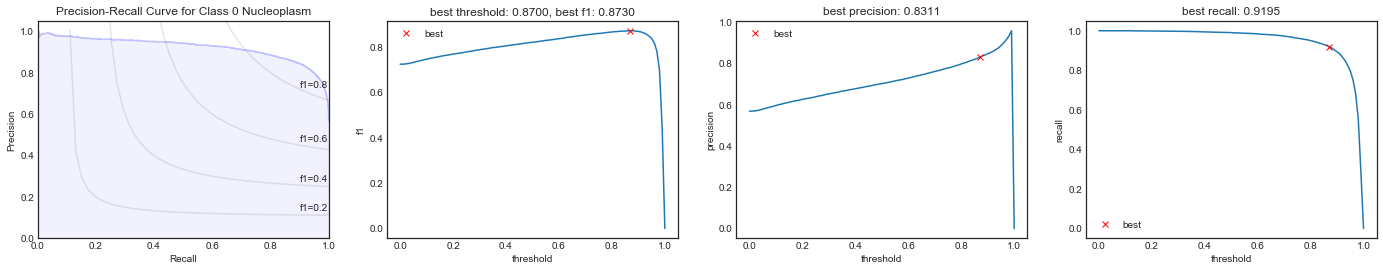

<Figure size 432x288 with 0 Axes>

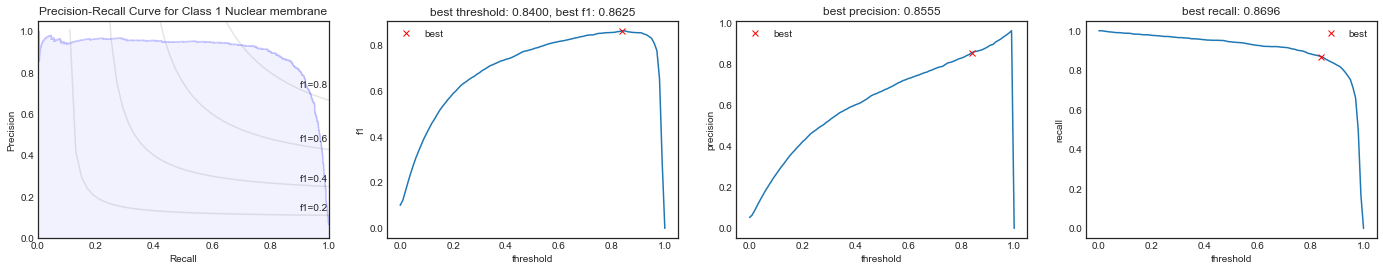

<Figure size 432x288 with 0 Axes>

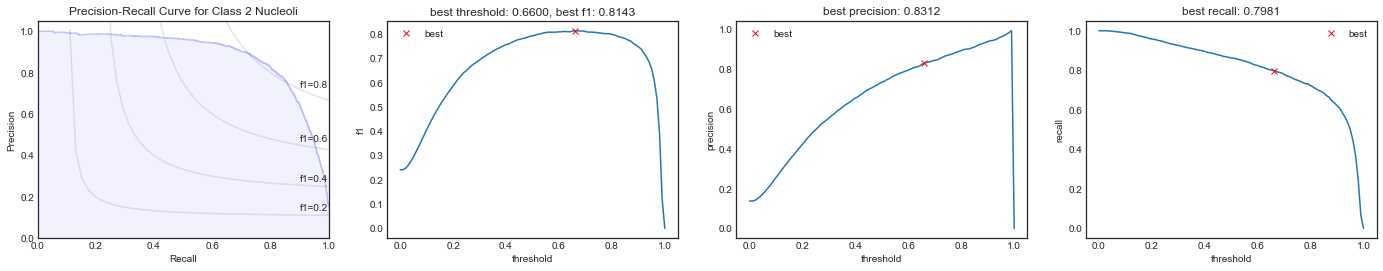

<Figure size 432x288 with 0 Axes>

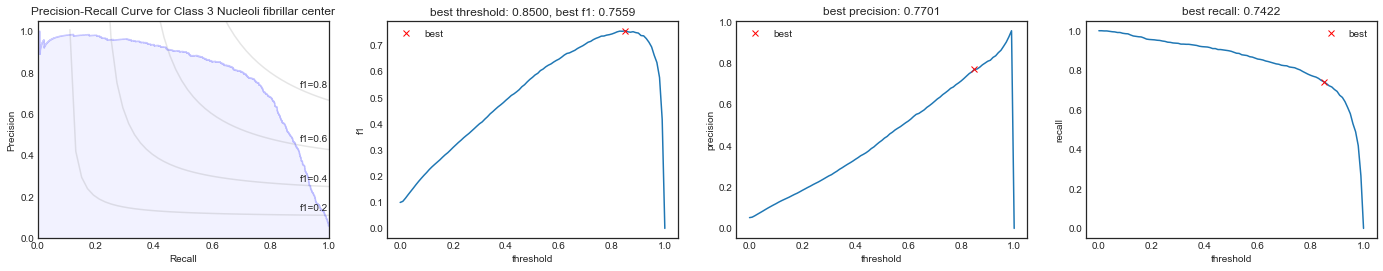

<Figure size 432x288 with 0 Axes>

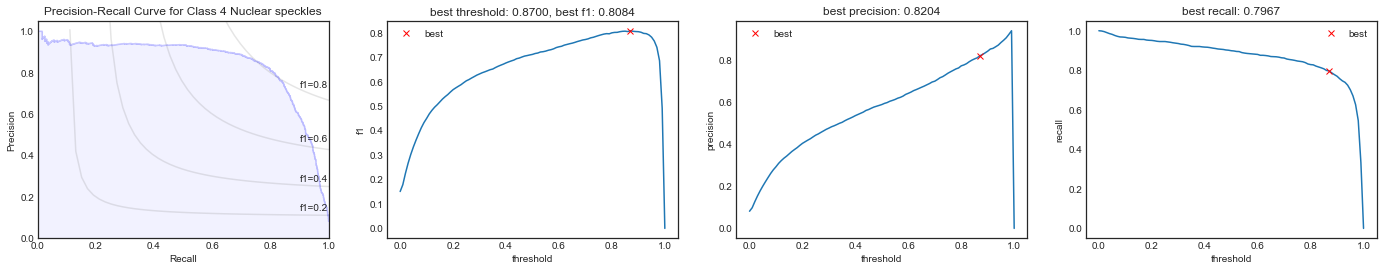

<Figure size 432x288 with 0 Axes>

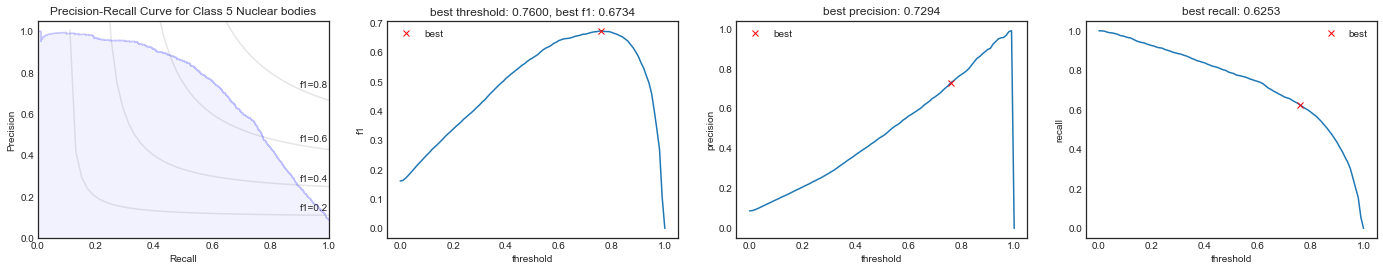

<Figure size 432x288 with 0 Axes>

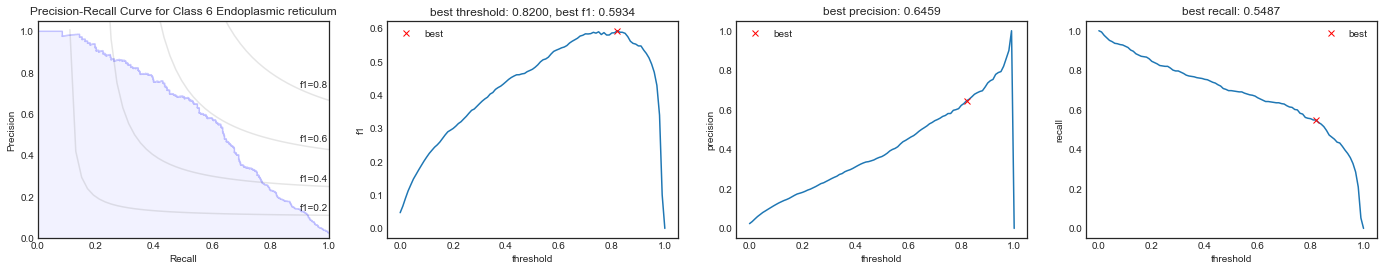

<Figure size 432x288 with 0 Axes>

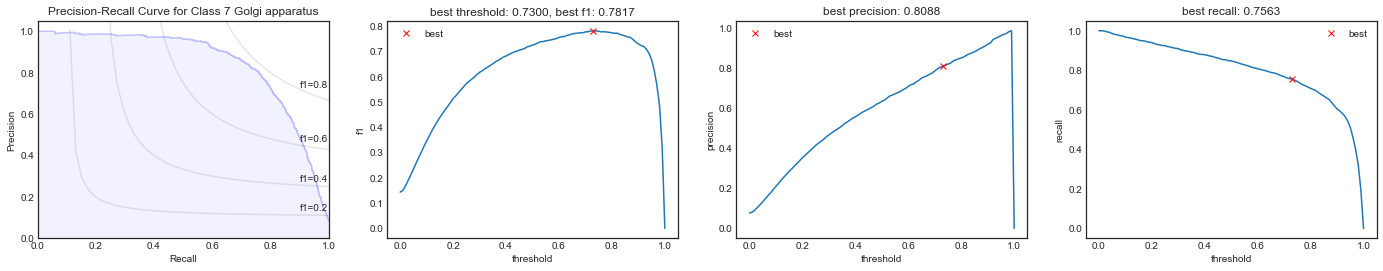

<Figure size 432x288 with 0 Axes>

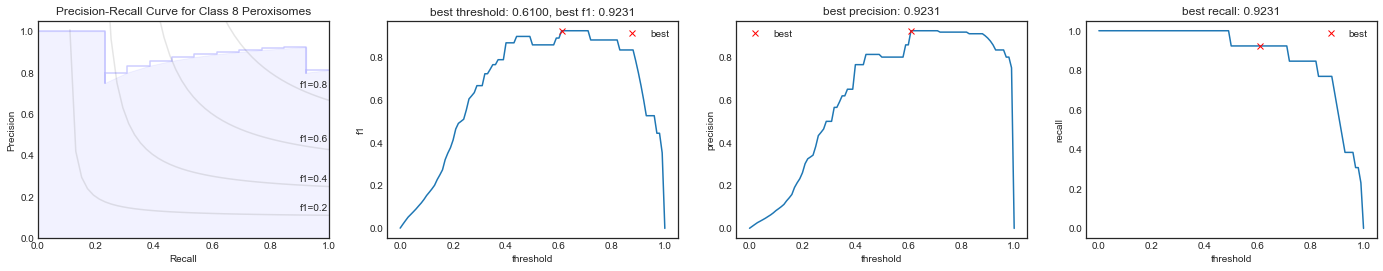

<Figure size 432x288 with 0 Axes>

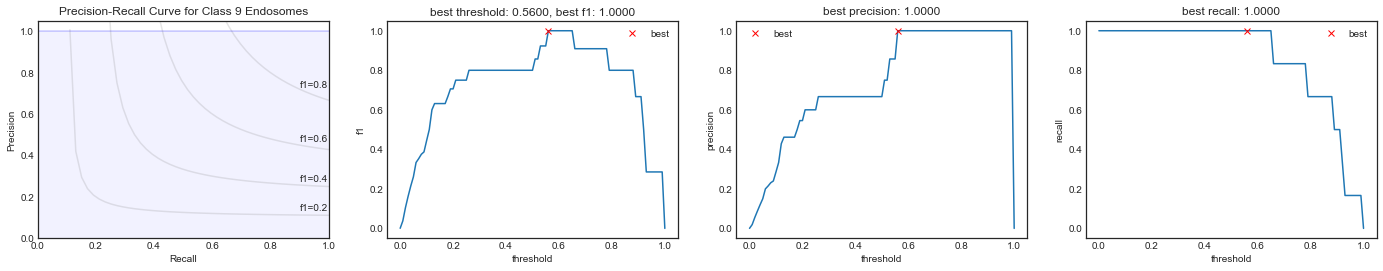

<Figure size 432x288 with 0 Axes>

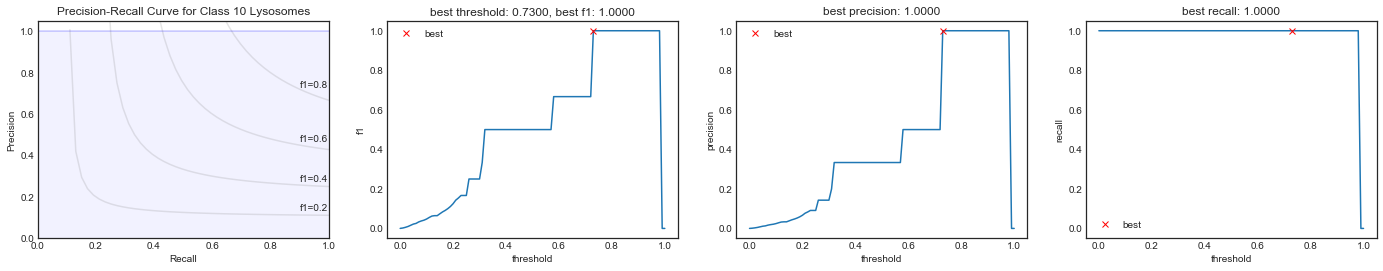

<Figure size 432x288 with 0 Axes>

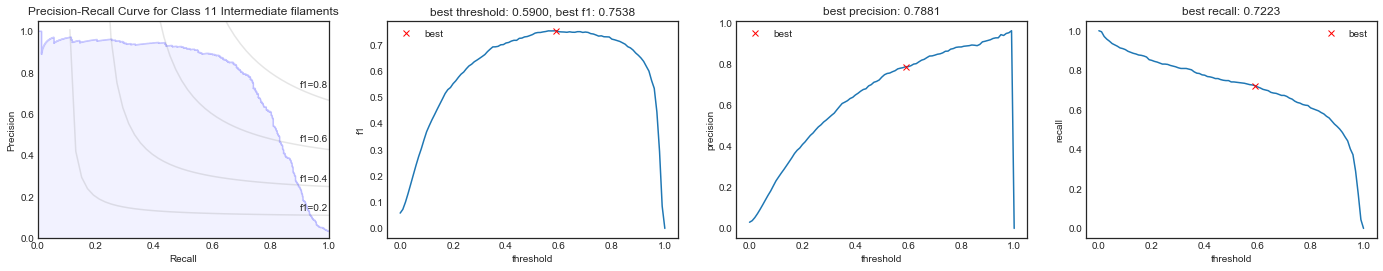

<Figure size 432x288 with 0 Axes>

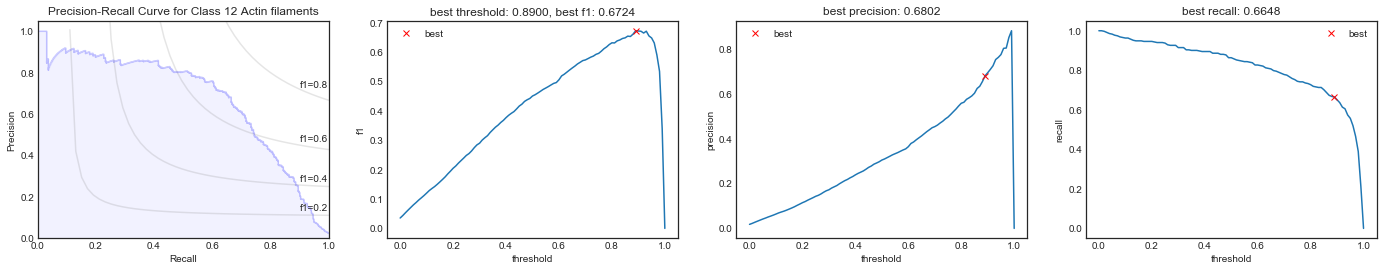

<Figure size 432x288 with 0 Axes>

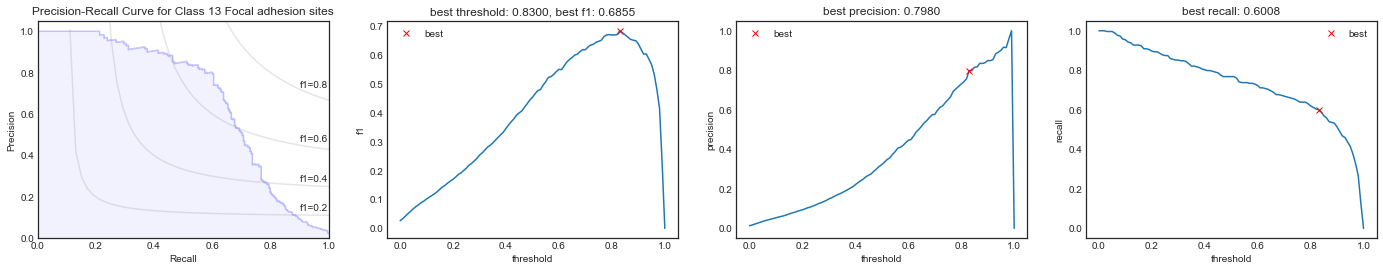

<Figure size 432x288 with 0 Axes>

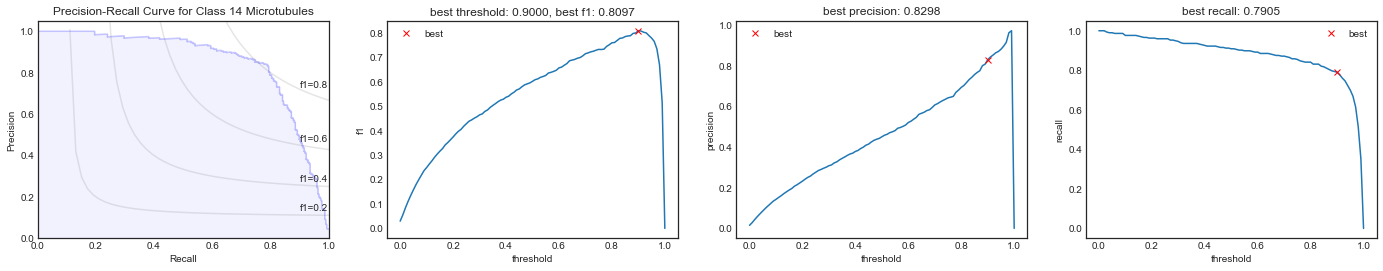

<Figure size 432x288 with 0 Axes>

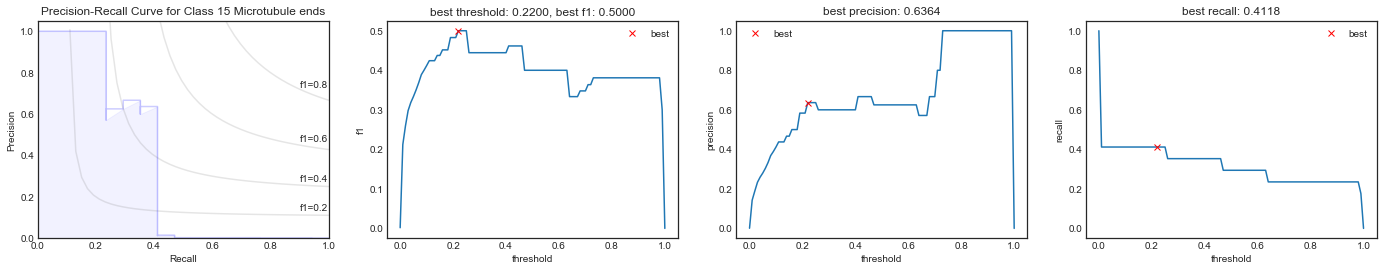

<Figure size 432x288 with 0 Axes>

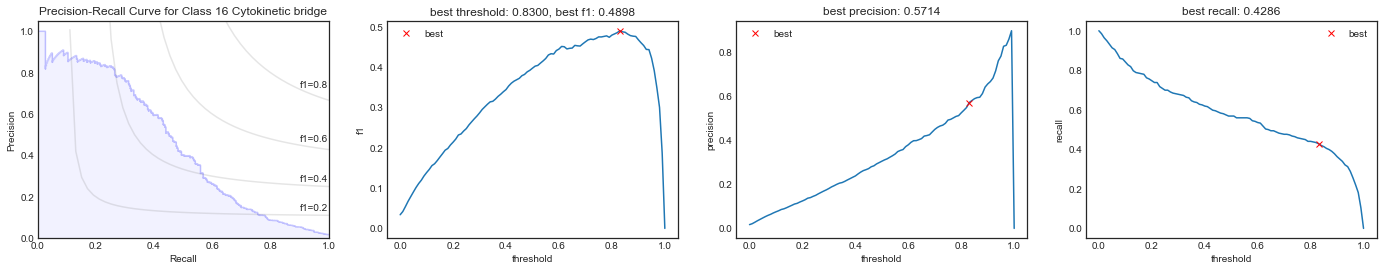

<Figure size 432x288 with 0 Axes>

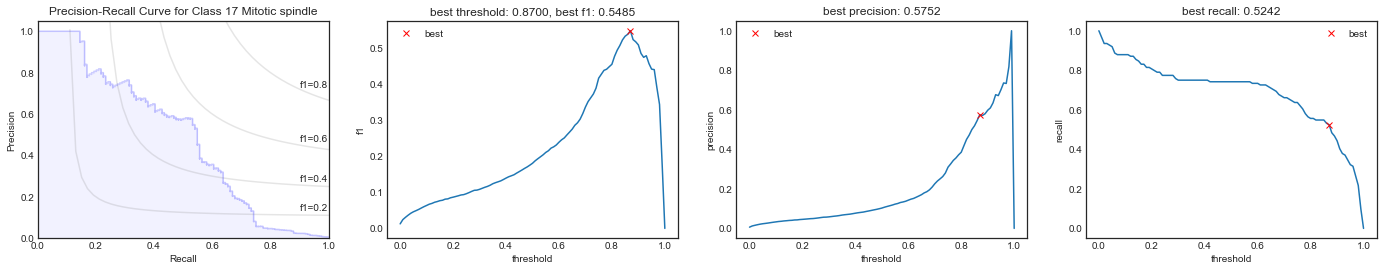

<Figure size 432x288 with 0 Axes>

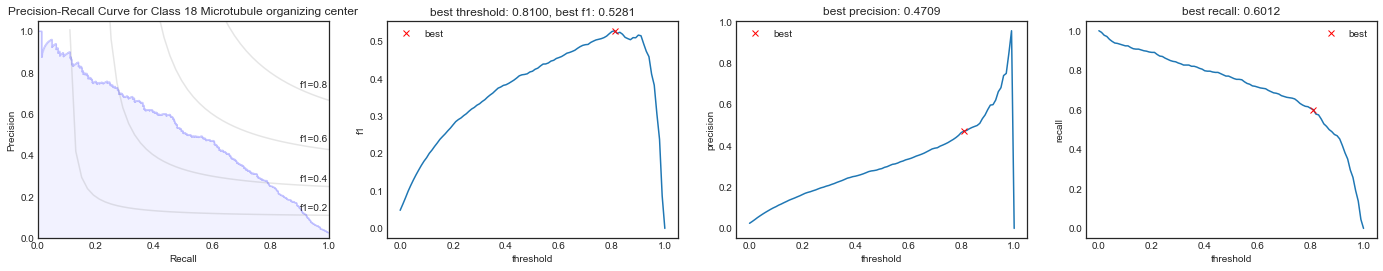

<Figure size 432x288 with 0 Axes>

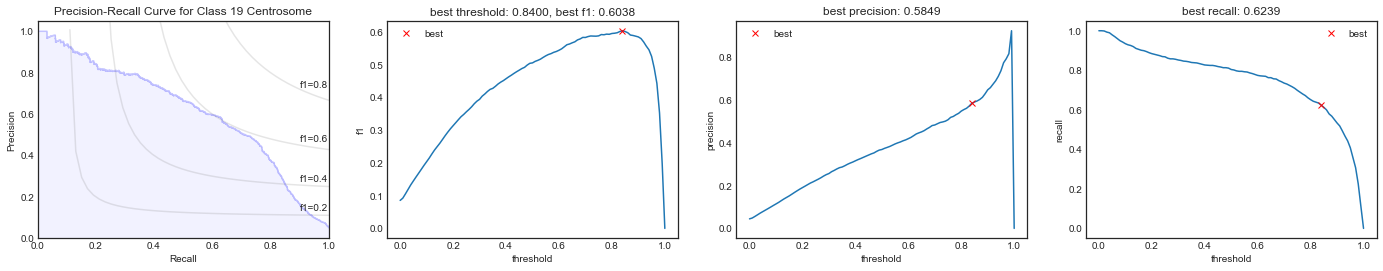

<Figure size 432x288 with 0 Axes>

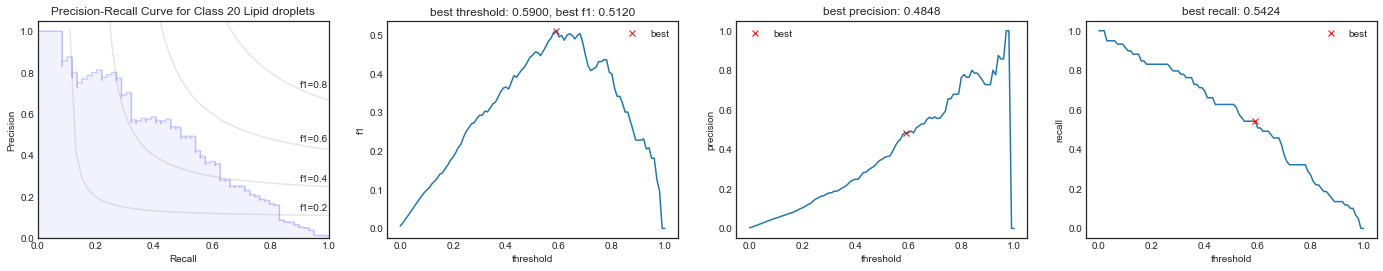

<Figure size 432x288 with 0 Axes>

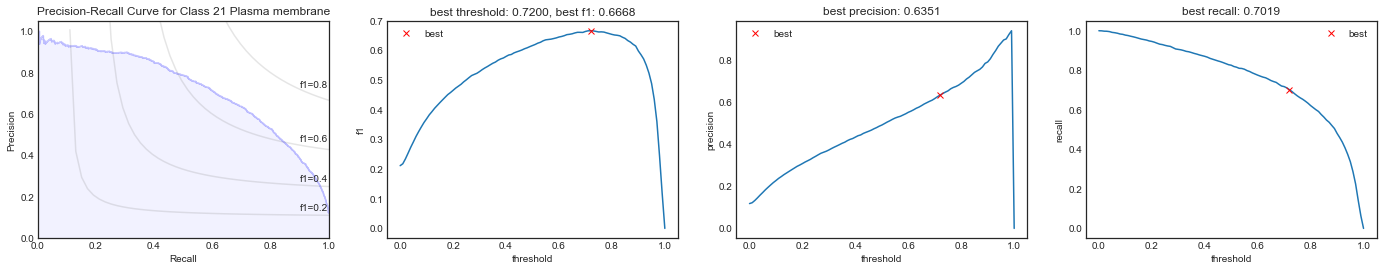

<Figure size 432x288 with 0 Axes>

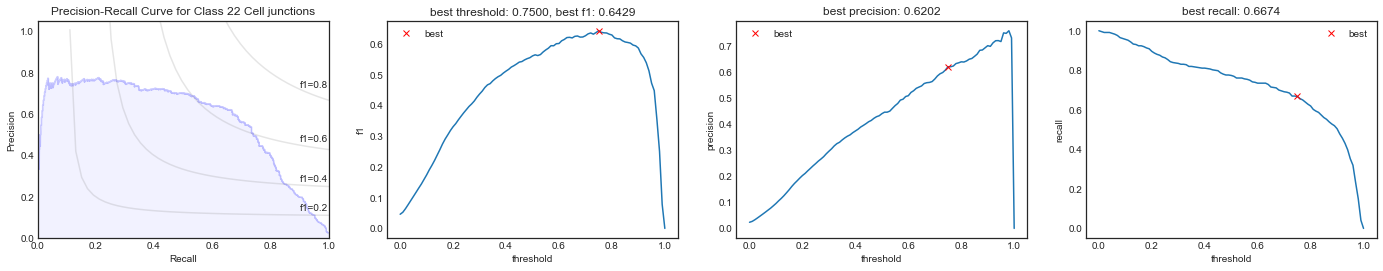

<Figure size 432x288 with 0 Axes>

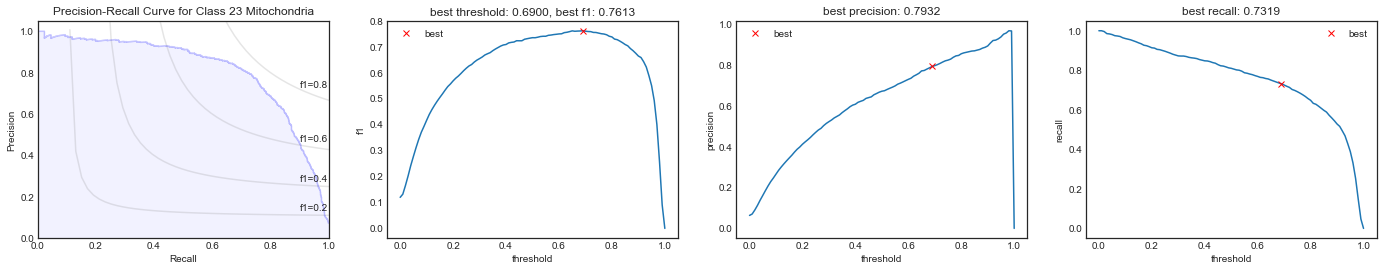

<Figure size 432x288 with 0 Axes>

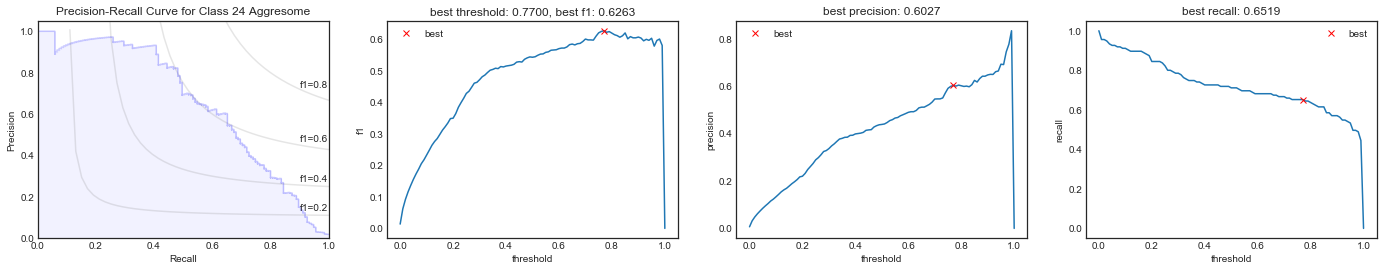

<Figure size 432x288 with 0 Axes>

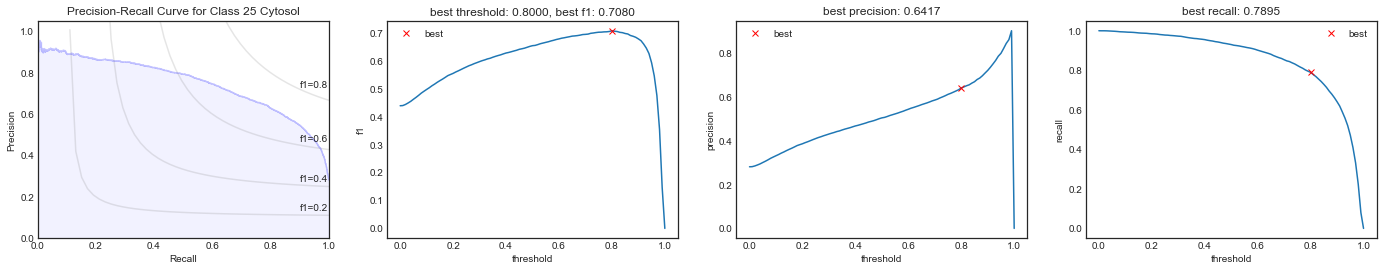

<Figure size 432x288 with 0 Axes>

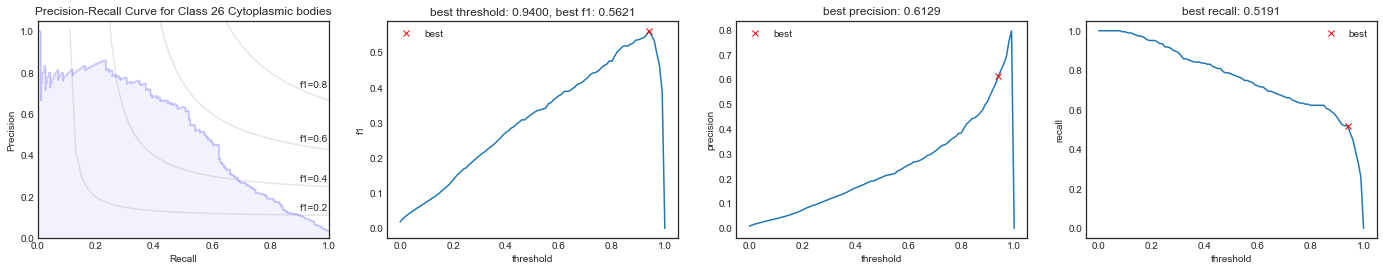

<Figure size 432x288 with 0 Axes>

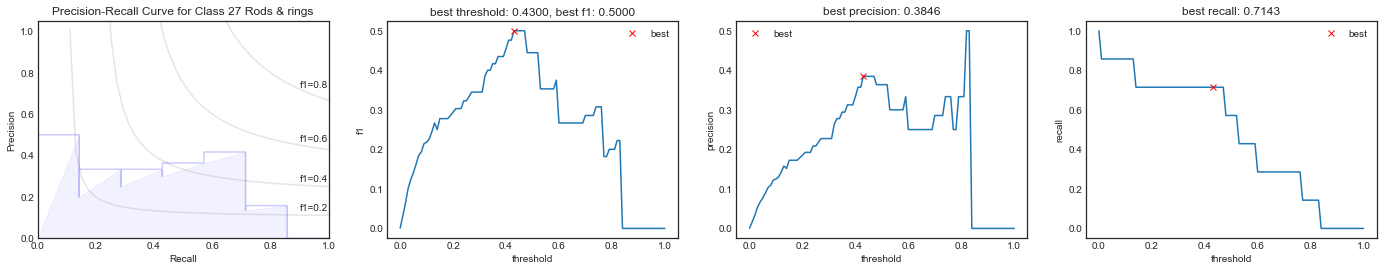

<Figure size 432x288 with 0 Axes>

In [89]:
n_classes = 28
thresholds = np.linspace(0.0, 1.0, 101)

# plot precision-recall curve for each class
precision = dict()
recall = dict()
average_precision = dict()
f_scores = np.linspace(0.2, 0.8, num=4)
ta = []
fma = []

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(yoof[:, i], pred[:, i])
    average_precision[i] = average_precision_score(yoof[:, i], pred[:, i])
    
#     plt.figure()
    
#     for f_score in f_scores:
#         xf = np.linspace(0.01, 1)
#         yf = f_score * xf / (2 * xf - f_score)
#         l, = plt.plot(xf[yf >= 0], yf[yf >= 0], color='gray', alpha=0.2)
#         plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, yf[45] + 0.02))

#     plt.step(recall[i], precision[i], color='b', alpha=0.2, where='post')
#     plt.fill_between(recall[i], precision[i], alpha=0.05, color='b')

#     plt.xlabel('Recall')
#     plt.ylabel('Precision')
#     plt.ylim([0.0, 1.05])
#     plt.xlim([0.0, 1.0])
#     plt.title(LABEL_MAP[i])
    
    
    fig, axs = plt.subplots(1, 4, figsize=(24, 4))
    
    for f_score in f_scores:
        xf = np.linspace(0.01, 1)
        yf = f_score * xf / (2 * xf - f_score)
        l, = axs[0].plot(xf[yf >= 0], yf[yf >= 0], color='gray', alpha=0.2)
        axs[0].annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, yf[45] + 0.02))

    axs[0].step(recall[i], precision[i], color='b', alpha=0.2, where='post')
    axs[0].fill_between(recall[i], precision[i], alpha=0.05, color='b')

    axs[0].set_xlabel('Recall')
    axs[0].set_ylabel('Precision')
    axs[0].set_ylim([0.0, 1.05])
    axs[0].set_xlim([0.0, 1.0])
    axs[0].set_title('Precision-Recall Curve for Class ' + str(i) + ' ' + LABEL_MAP[i])
    
    
    # for ranks
    # thresholds = np.linspace(0.8, 1.0, 101)
    fm = [f1_score(yoof[:,i], (pred[:,i] > t).astype(int)) for t in thresholds] 

    besti = np.argmax(fm)
    bestt = thresholds[besti]
    ta.append(bestt)
    bests = fm[besti] 
    fma.append(bests)
        
    axs[1].plot(thresholds, fm)
    axs[1].plot(bestt, bests, "xr", label="best")
    axs[1].set_xlabel("threshold")
    axs[1].set_ylabel("f1")
    axs[1].set_title("best threshold: %6.4f, best f1: %6.4f" % (bestt, bests))
    axs[1].legend()

    pm = [precision_score(yoof[:,i], (pred[:,i] > t).astype(int)) for t in thresholds] 
    bestsp = pm[besti] 
        
    axs[2].plot(thresholds, pm)
    axs[2].plot(bestt, bestsp, "xr", label="best")
    axs[2].set_xlabel("threshold")
    axs[2].set_ylabel("precision")
    axs[2].set_title("best precision: %6.4f" % (bestsp))
    axs[2].legend()
    
    rm = [recall_score(yoof[:,i], (pred[:,i] > t).astype(int)) for t in thresholds] 
    bestsr = rm[besti] 
        
    axs[3].plot(thresholds, rm)
    axs[3].plot(bestt, bestsr, "xr", label="best")
    axs[3].set_xlabel("threshold")
    axs[3].set_ylabel("recall")
    axs[3].set_title("best recall: %6.4f" % (bestsr))
    axs[3].legend()
    
    plt.show()
    plt.gcf().clear()

In [90]:
np.mean(fma)

0.7020218013139593

In [91]:
# error analysis
from sklearn.metrics import confusion_matrix

cm = [confusion_matrix(yoof[:,i], (pred[:,i]  > th[i]).astype(int)) \
       for i in range(yoof.shape[1])]
pma = [precision_score(yoof[:,i], (pred[:,i]  > th[i]).astype(int)) \
       for i in range(yoof.shape[1])]
rma = [recall_score(yoof[:,i], (pred[:,i]  > th[i]).astype(int)) \
       for i in range(yoof.shape[1])]

print('macro f1','%6.4f' % np.mean(fma))
print()

# sort from worst to best
order = np.array(fma).argsort()
ymean = np.mean(yoof,axis=0)

for i in range(y.shape[1]):
    oi = order[i]
    print('class', '%2d' % oi,'  prop', '%6.4f' % ymean[oi], 
                     '  f1', '%6.4f' % fma[oi],
                     '  precision', '%6.4f' % pma[oi],
                     '  recall', '%6.4f' % rma[oi],
                     '  ', LABEL_MAP[oi])
    print(cm[oi])
    print()

macro f1 0.7020

class 16   prop 0.0172   f1 0.4898   precision 0.5760   recall 0.4286    Cytokinetic bridge
[[19085   106]
 [  192   144]]

class 27   prop 0.0004   f1 0.5000   precision 0.3846   recall 0.7143    Rods & rings
[[19512     8]
 [    2     5]]

class 15   prop 0.0009   f1 0.5000   precision 0.6364   recall 0.4118    Microtubule ends
[[19506     4]
 [   10     7]]

class 20   prop 0.0030   f1 0.5120   precision 0.5745   recall 0.4576    Lipid droplets
[[19448    20]
 [   32    27]]

class 18   prop 0.0248   f1 0.5281   precision 0.4711   recall 0.6054    Microtubule organizing center
[[18714   329]
 [  191   293]]

class 17   prop 0.0064   f1 0.5485   precision 0.5739   recall 0.5323    Mitotic spindle
[[19354    49]
 [   58    66]]

class 26   prop 0.0094   f1 0.5621   precision 0.6169   recall 0.5191    Cytoplasmic bodies
[[19285    59]
 [   88    95]]

class  6   prop 0.0242   f1 0.5934   precision 0.6475   recall 0.5487    Endoplasmic reticulum
[[18914   141]
 [  213  

In [92]:
# confusion matrix of true val with single label
true_list = []
pred_list = []
for i, yi in enumerate(yoof):
#     img, y = db_val[i]

    true = np.nonzero(yi)[0]
    if len(true) > 1: continue
    
    predi = np.nonzero((pred[i] > threshold_best).astype(int))[0]
    if len(predi)==0: predi = np.array([28])
    # replace empty with max prob
    # if len(pred)==0: pred = [np.argmax(vlsp[i])]
    for j in range(len(predi)):
        true_list.append(true[0])
        pred_list.append(predi[j])
    
print(y.shape[0],len(true_list),len(pred_list))

true = np.array(true_list)
predc = np.array(pred_list)
print(true.shape,true[:5])

np.set_printoptions(linewidth=250)
cm = confusion_matrix(true,predc)
print(cm)

31072 12163 12163
(12163,) [5 1 1 0 0]
[[2054   61   33   15  177  136    0   22    0    0    3    7    3    3   17    4   24   92    2   22    8   16    5  427   31    7]
 [  90  197    0    0    0    1    2    0    0    0    0    1    0    0    0    0    0    0    0    2    0    0    0   23    0    1]
 [ 206    0  474   47   20    5    0    4    0    0    0    3    1    5    1    0    3    4    0    7    1    5    0   69    1    5]
 [  98    1   42  286    6    5    1    0    0    0    0    1    0    0    0    0    0    0    0    1    1    5    0   51    1    5]
 [ 278    0    9    7  883   20    0    7    0    0    1    0    0    4    0    0    1    7    0    8    2    5    2   46   26    3]
 [ 362    8    6   29   34  409    0    3    0    0    0    1    0    3    0    0    3    9    0    6    2    8    2   81    0    6]
 [  24    8    1    1    2    1  184    2    0    0    1    1    0    2    1    1    1    0    0   11    0   14    0   90    0    7]
 [ 138    3    2    0    3    

In [93]:
# compute test predictions
weights = pickle.load(open('weights/'+mname+'_'+str(fold)+'.pkl','rb'))
print(len(weights))

28


In [94]:
weights

[      weight             mod      f1_0
 midx                                  
 0          1         air_g68  0.698776
 3          3        cbam_h67  0.684872
 4          1         iv3_g11  0.684858
 6          2   preresnet_g67  0.682496
 7          1   preresnet_h67  0.693933
 8          1  se_resnext_g30  0.683785
 9          2  se_resnext_h30  0.696277,       weight             mod      f1_0
 midx                                  
 0          2         air_g68  0.773893
 3          1        cbam_h67  0.757576
 4          2         iv3_g11  0.756522
 6          6   preresnet_g67  0.814645
 8          3  se_resnext_g30  0.803612
 9          3  se_resnext_h30  0.811280,       weight             mod      f1_0
 midx                                  
 0          3         air_g68  0.798873
 2          3        airx_h67  0.790412
 3          2        cbam_h67  0.780972
 5          2         iv3_h11  0.748307
 6          1   preresnet_g67  0.793315
 7          2   preresnet_h67  0.791713


In [95]:
# list of unique model names

# allm = weights['mod'].values
# mnames = list(allm)

allm = [weights[i]['mod'].values for i in range(len(weights))]
mnames = list(set().union(*allm))

print(mnames)
print(len(mnames))

['air_g68', 'airx_h67', 'se_resnext_g30', 'preresnet_g67', 'cbam_h67', 'preresnet_h67', 'iv3_h11', 'iv3_g11', 'air_h68', 'se_resnext_h30']
10


In [96]:
blist = ['blend_0459']
tlist = ['iv3_a4','se_resnext_d10','se_resnext_d11']
klist = ['resnet34_46','resnet50','resnet34']
print(glist)
print(clist)
print(dlist)
print(blist)
print(tlist)
print(klist)

['air_g68', 'air_h68', 'airx_h67', 'cbam_h67', 'iv3_g11', 'iv3_h11', 'preresnet_g67', 'preresnet_h67', 'se_resnext_g30', 'se_resnext_h30']
[]
[]
['blend_0459']
['iv3_a4', 'se_resnext_d10', 'se_resnext_d11']
['resnet34_46', 'resnet50', 'resnet34']


In [97]:
clist

[]

In [98]:
name_label_dict = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}
LABEL_MAP = name_label_dict
np.set_printoptions(precision=3, suppress=True, linewidth=100)

In [99]:
test_df = pd.read_csv("sample_submission.csv", index_col="Id")
print(test_df.head())
print(test_df.shape)

                                      Predicted
Id                                             
00008af0-bad0-11e8-b2b8-ac1f6b6435d0          0
0000a892-bacf-11e8-b2b8-ac1f6b6435d0          0
0006faa6-bac7-11e8-b2b7-ac1f6b6435d0          0
0008baca-bad7-11e8-b2b9-ac1f6b6435d0          0
000cce7e-bad4-11e8-b2b8-ac1f6b6435d0          0
(11702, 1)


In [100]:
test_df.columns

Index(['Predicted'], dtype='object')

In [101]:
# save a base copy for reuse below
test_df0 = test_df.copy()
sub_dir = './sub/'

In [102]:
# build blend as weighted average
test_df = test_df0.copy()
idx = test_df.index.values
num_classes = 28
firstm = True
sumw = 0.
c = 0
d = 0
for m in mnames:

    firstf = True
    navg = 0
    if m in blist+clist: suffix = '.npy'
    elif m in klist+slist: suffix = '.pkl'
    else: suffix = '_mm.pkl'
    if True:
#     for fold in range(nfold):
#         print('')
#         print(m+'_'+str(fold))
        first = True
        nr = 0
        for rep in ['']:
            if m in blist:
                fname = sub_dir + m + rep + suffix
                if fold > 0: fname = fname + '_' + str(fold)
            elif m in clist:
                fname = 'oof/'+clist0[c]+'_ext_russ4/pred'+str(fold)+suffix
            elif m in dlist:
                if dlist0[d] in dlist0s: s = '_' + dfold
                else: s = '_extra_' + dfold
                fname = 'oof/Dmytro/'+dlist0[d]+s+'__fold_'+ \
                                str(fold)+'_'+dlist1[d]+'_test.csv'
            else:
                fname = sub_dir + m + rep + '_' + str(fold) + suffix
            if os.path.exists(fname):
                print()
                print(fname)
                if m in blist+clist:
                    ptestb = np.load(fname)
                    idb = idb0
                elif m in dlist:
                    o = pd.read_csv(fname)
                    idb = list(o['Id'])
                    ptestb = np.array(o.iloc[:,:num_classes])
                    ptestb = expit(ptestb)
                elif m in slist:
                    a = pickle.load(open(fname,'rb'))
                    idb = list(a[:,0])
                    ptestb = np.zeros((len(idb),num_classes))
                    for i in range(len(idb)):
                        ptestb[i,:] = a[i,1:].astype(float)
                elif m in klist: 
                    idb, ptestb = pickle.load(open(fname,'rb'))
                    # ptestb = logit(ptestb)
                elif m in tlist:
                    idb, ptestba, ptestb, ptestbb = pickle.load(open(fname,'rb'))
                    ptestb = expit(ptestb)
                elif m in flist+glist:
                    idb, ptestb, ptestba = pickle.load(open(fname,'rb'))
                    ptestb = np.percentile(ptestb, gpct, axis=(2,3))
                    ptestb = 1./(1. + np.exp(-ptestb/gscale))
                else:
                    idb, ptestb, ptestba = pickle.load(open(fname,'rb'))
                    ptestb = expit(ptestb)
                
                # ptestb = np.clip(ptestb,-20.0,20.0)
                # ptestb[ptestb==-inf] = -6.0
                # ptestb[ptestb==inf] = 6.0
                
                print(ptestb.min(),ptestb.mean(),ptestb.max())
                
                if first:
                    ptestf = ptestb.copy()
                    idb0 = idb
                    first = False
                else:
                    checki = [i0 != i1 for i0,i1 in zip(idb0,idb)]
                    si = np.array(checki).sum()
                    # print(si)
                    assert si == 0
                    print(np.corrcoef(np.array(ptestf).flatten(),
                                      np.array(ptestb).flatten()))

                    ptestf += ptestb
                nr += 1
                
        if nr > 0:
            ptestf /= nr
            print(ptestf.shape,ptestf.min(),ptestf.mean(),ptestf.max())

            if firstf:
                id = idb
                ptest = ptestf.copy()
                firstf = False
            else:
                print(np.corrcoef(np.array(ptest).flatten(),
                                  np.array(ptestf).flatten()))
                ptest += ptestf
                
            navg += 1
    
    if navg != 1: raise ValueError('Found %d folds for %s instead of %d' % (navg,m,nfold))
    ptest /= navg
    pmask = (ptest > threshold).astype(int)
    print(m,navg,ptest.shape,ptest.min(),ptest.mean(),ptest.max(),pmask.mean())
    td = pd.DataFrame({'id':id})
    td[m] = [a for a in ptest]
    td.set_index('id',inplace=True)
    test_df = test_df.join(td)
    
    if m in clist: c += 1
    elif m in dlist: d += 1



./sub/air_g68_1_mm.pkl
4.685959138740213e-08 0.1065618902440033 0.9999980416641511
(11702, 28) 4.685959138740213e-08 0.1065618902440033 0.9999980416641511
air_g68 1 (11702, 28) 4.685959138740213e-08 0.1065618902440033 0.9999980416641511 0.09118709866445296

./sub/airx_h67_1_mm.pkl
2.6941175806776086e-06 0.14782682896026894 0.999964515865391
(11702, 28) 2.6941175806776086e-06 0.14782682896026894 0.999964515865391
airx_h67 1 (11702, 28) 2.6941175806776086e-06 0.14782682896026894 0.999964515865391 0.10692921844861684

./sub/se_resnext_g30_1_mm.pkl
1.333371333196613e-06 0.11101928657326121 0.9999433132882609
(11702, 28) 1.333371333196613e-06 0.11101928657326121 0.9999433132882609
se_resnext_g30 1 (11702, 28) 1.333371333196613e-06 0.11101928657326121 0.9999433132882609 0.08978318724515956

./sub/preresnet_g67_1_mm.pkl
2.1506169138475962e-07 0.11441965257639922 0.9999959702590234
(11702, 28) 2.1506169138475962e-07 0.11441965257639922 0.9999959702590234
preresnet_g67 1 (11702, 28) 2.15061691

In [103]:
test_df.columns

Index(['Predicted', 'air_g68', 'airx_h67', 'se_resnext_g30', 'preresnet_g67',
       'cbam_h67', 'preresnet_h67', 'iv3_h11', 'iv3_g11', 'air_h68',
       'se_resnext_h30'],
      dtype='object')

In [104]:
print(idx[:5])

['00008af0-bad0-11e8-b2b8-ac1f6b6435d0' '0000a892-bacf-11e8-b2b8-ac1f6b6435d0'
 '0006faa6-bac7-11e8-b2b7-ac1f6b6435d0' '0008baca-bad7-11e8-b2b9-ac1f6b6435d0'
 '000cce7e-bad4-11e8-b2b8-ac1f6b6435d0']


In [105]:
f = []
tclist = list(test_df.columns[1:])
for c in tclist:
    ff = np.array(list(test_df[c])).flatten()
    print(ff.shape,c)
    f.append(ff)
# print(tclist)
r = np.corrcoef(f)
print(r)

(327656,) air_g68
(327656,) airx_h67
(327656,) se_resnext_g30
(327656,) preresnet_g67
(327656,) cbam_h67
(327656,) preresnet_h67
(327656,) iv3_h11
(327656,) iv3_g11
(327656,) air_h68
(327656,) se_resnext_h30
[[1.    0.889 0.919 0.946 0.88  0.91  0.825 0.824 0.927 0.903]
 [0.889 1.    0.884 0.899 0.935 0.936 0.903 0.871 0.932 0.921]
 [0.919 0.884 1.    0.918 0.877 0.9   0.836 0.835 0.902 0.945]
 [0.946 0.899 0.918 1.    0.893 0.937 0.84  0.84  0.919 0.909]
 [0.88  0.935 0.877 0.893 1.    0.937 0.906 0.878 0.929 0.917]
 [0.91  0.936 0.9   0.937 0.937 1.    0.896 0.871 0.958 0.937]
 [0.825 0.903 0.836 0.84  0.906 0.896 1.    0.926 0.896 0.895]
 [0.824 0.871 0.835 0.84  0.878 0.871 0.926 1.    0.867 0.869]
 [0.927 0.932 0.902 0.919 0.929 0.958 0.896 0.867 1.    0.938]
 [0.903 0.921 0.945 0.909 0.917 0.937 0.895 0.869 0.938 1.   ]]


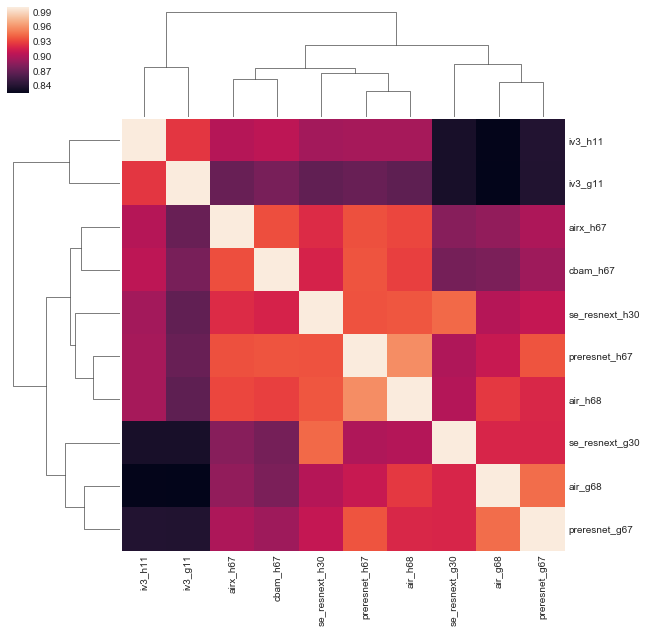

In [106]:
d = pd.DataFrame(r, columns=mnames)
d['id'] = mnames
d.set_index('id',inplace=True)
del d.index.name

sns.clustermap(d)


# import scipy.cluster.hierarchy as hc
# from matplotlib import pyplot
# link = hc.linkage(d.values, method='centroid')
# o1 = hc.leaves_list(link)

# mat = d.iloc[o1,:]
# mat = mat.iloc[:, o1[::-1]]
# pyplot.imshow(mat)

In [107]:
flat = np.transpose(np.array(f))
print(flat.shape)
fname = 'flat.csv'
fdf = pd.DataFrame(flat)
fdf.columns = tclist
fdf.to_csv(fname)
print(fname)

(327656, 10)
flat.csv


In [108]:
ens = np.zeros((test_df.shape[0],28))

# apply class-specific ensemble weights
for i in range(28):

    f = []
#     clist = weights['mod'].values
    clist = weights[i]['mod'].values
    for c in clist:
        f.append(np.array(list(test_df[c])))
    m = np.array(f)
    print(m.shape)

#     w = np.array(weights['weight'].values)
    w = np.array(weights[i]['weight'].values)
    print(i, clist, w)

    ens[:,i] = np.average(m,axis=0,weights=w)[:,i]
    
print(ens.shape)

(7, 11702, 28)
0 ['air_g68' 'cbam_h67' 'iv3_g11' 'preresnet_g67' 'preresnet_h67' 'se_resnext_g30' 'se_resnext_h30'] [1 3 1 2 1 1 2]
(6, 11702, 28)
1 ['air_g68' 'cbam_h67' 'iv3_g11' 'preresnet_g67' 'se_resnext_g30' 'se_resnext_h30'] [2 1 2 6 3 3]
(8, 11702, 28)
2 ['air_g68' 'airx_h67' 'cbam_h67' 'iv3_h11' 'preresnet_g67' 'preresnet_h67' 'se_resnext_g30'
 'se_resnext_h30'] [3 3 2 2 1 2 4 3]
(7, 11702, 28)
3 ['air_g68' 'air_h68' 'airx_h67' 'cbam_h67' 'iv3_g11' 'preresnet_h67' 'se_resnext_h30'] [2 1 2 2 1 1 1]
(4, 11702, 28)
4 ['air_h68' 'airx_h67' 'preresnet_g67' 'se_resnext_g30'] [1 2 7 2]
(8, 11702, 28)
5 ['air_g68' 'air_h68' 'cbam_h67' 'iv3_g11' 'preresnet_g67' 'preresnet_h67' 'se_resnext_g30'
 'se_resnext_h30'] [5 6 6 1 3 2 3 3]
(5, 11702, 28)
6 ['air_g68' 'cbam_h67' 'iv3_g11' 'preresnet_g67' 'se_resnext_h30'] [2 1 5 2 6]
(6, 11702, 28)
7 ['air_g68' 'cbam_h67' 'iv3_g11' 'iv3_h11' 'preresnet_g67' 'se_resnext_h30'] [12  2  4  1  4  5]
(5, 11702, 28)
8 ['air_g68' 'airx_h67' 'iv3_g11' 'se

In [109]:
print(ens[1])

[0.298 0.021 0.094 0.136 0.113 0.988 0.146 0.036 0.001 0.001 0.004 0.022 0.013 0.031 0.015 0.001
 0.026 0.014 0.029 0.035 0.017 0.135 0.02  0.05  0.22  0.709 0.097 0.   ]


In [110]:
ens.shape

(11702, 28)

In [111]:
test_ids = list(test_df.index.values)
print(len(test_ids))

11702


In [112]:
sub = [list(test_df.index.values), ens]
fname = 'sub/'+mname+'_'+str(fold)+'.pkl'
pickle.dump(sub,open(fname,'wb'))
print(fname)

sub/hill_g100_1.pkl
